## Extratégias para identificar qubras nas séries temporais

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import plotly as py

from scipy import stats

In [14]:
data_health = pd.read_csv('saude.csv')

#data_health = data_health.sort_values(by=['COD_AENV','DT_PROC','VLR_DESG'],ascending=False).reset_index(drop=True)


data_health = data_health.groupby(by=['COD_FALH','COD_AENV','DT_PROC']).median().reset_index()
data_health['id']=data_health.index
data_health.head()



COD_FALH  COD_AENV     DT_PROC   VLR_DESG  COD_EVNT  id
0         1      1011  2010-01-11  65.971769  116846.0   0
1         1      1011  2010-01-12  65.976961  116813.0   1
2         1      1011  2010-01-13  66.154564  116795.0   2
3         1      1011  2010-01-14  66.188218  116812.0   3
4         1      1011  2010-01-15  66.242378  116825.0   4

### Vizualização das séries

In [269]:
px.line(data_health[data_health.COD_FALH==1], x='DT_PROC', y='VLR_DESG', color='COD_AENV')

In [271]:
px.line(data_health[data_health.COD_FALH==35], x='DT_PROC', y='VLR_DESG', color='COD_AENV')

## Aborgens para detecção de anomalias

In [208]:
# vizualizção das séries e das falhas identificadas
def plot_discrepancy(data, fun_dis,rever=True):
#Função para plotar as séries e as falhas identificadas

    aenv= data.COD_AENV.unique() # lista de aenvs
    falh= data.COD_FALH.unique() # lista de falhas
    leg = ['discrepancy','serie'] # legenda
    for i in aenv: # loop para cada aenv
        for j in falh: # loop para cada falha
            serie=data[(data['COD_AENV']==i) & (data['COD_FALH']==j)].sort_values(by='DT_PROC')['VLR_DESG'].to_list() # serie da falha
            plt.figure(dpi=300)
            plt.plot(fun_dis(serie),color='k',linewidth=1) #plot da discrepância
            
            if rever == True: # plot da série reversa
                plt.plot(fun_dis(serie[::-1])[::-1],'r',linewidth=0.5) #plot da discrepância
                leg = ['discrepancy','discrepancy reverse','serie']
            plt.plot(serie,'.m',linewidth=0.5) #plot da série
            plt.legend(leg)
            plt.title('AENV: '+str(i)+' - FALH: '+str(j))# título        

In [232]:
def loc_discrepancy(serie,disc1, samples=30):
    #Recebe uma série, lista de discrepâncias e um intervalo de amostragem
    #Cada trecho entre discrepâncias é considerado uma nova série
    #Cada nova série recebe um idenficador
    
    #A função retorna uma série cujos trechos menores que o intervalo são substituidos por -1
    #Também retorna uma lista indicando o id de cada ponto da série
    
    d1 = 0
    remove_val = np.copy(serie) 
    parts = []
    part=1
    for i in range(0,len(disc1)): #percorre a lista de discrepâncias
        parts.append(part)
        if disc1[i]==100 or disc1[i]==200: #se a discrepância for 100, o trecho é considerado uma nova série
            part+=1 #incrementa o identificador
            if i-d1<samples: #se o trecho for menor que o intervalo de amostragem, substitui por -1
                remove_val[d1:i]=[-1]*len(disc1[d1:i]) #substitui os valores por -1
                d1=i
            else: d1=i
            
    if i-d1<samples: #se o último trecho for menor que o intervalo de amostragem
        remove_val[d1:]=[-1]*len(disc1[d1:]) #substitui os valores por -1
        
    return remove_val, parts 
    #retorna a série com os trechos menores que o intervalo substituidos por -1 e a lista de identificadores
    
    
    
    
def discrepancy_4(serie,n=5): 
    #Função que identifica diferenças entre duas amostras consecutivas de tamanho n
    #   se a diferença for maior que 3*ptp, então é considerada uma discrepância
    
    # Além disso, compara a diferença de uma amostra com o ponto seguinte
    #   se a diferença for maior que 2, então é considerada uma discrepância
    
    #Os valores foram ajustados experimentalmente
    
    # n = tamanho da janela
    
    discrip = [0]*n # inicializa a lista de discrepância
    
    for i in range(len(serie)-n):
        sample1 = serie[i:i+n] # amostra 1
        min1 = np.min(sample1) # minimo da amostra 1
        max1 = np.max(sample1) # maximo da amostra 1
        
        
        sample2 = serie[i+n:i+2*n] # amostra 2
        min2 = np.min(sample2) # minimo da amostra 2
        max2 = np.max(sample2) # maximo da amostra 2
        
        ptp1 = 3*abs(max1-min1) # amplitude da amostra 1
        ptp2 = 3*abs(max2-min2) # amplitude da amostra 2
        
        if (min2>max1+ptp1 or max2<min1-ptp1): #amostra 2 está fora da amostra 1
            discrip.append(100) #discrepancia
            
        else: # amostra 2 está dentro da amostra 1
            if serie[i+n] > max1+2 or serie[i+n] < min1-2: # ponto atual está fora da amostra 1
                discrip.append(100) #discrepancia
            else:
                discrip.append(0) #sem discrepancia

    return np.array(discrip) #lista de discrepancias
        

c:\Users\CepaTech\Documents\Miniconda\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



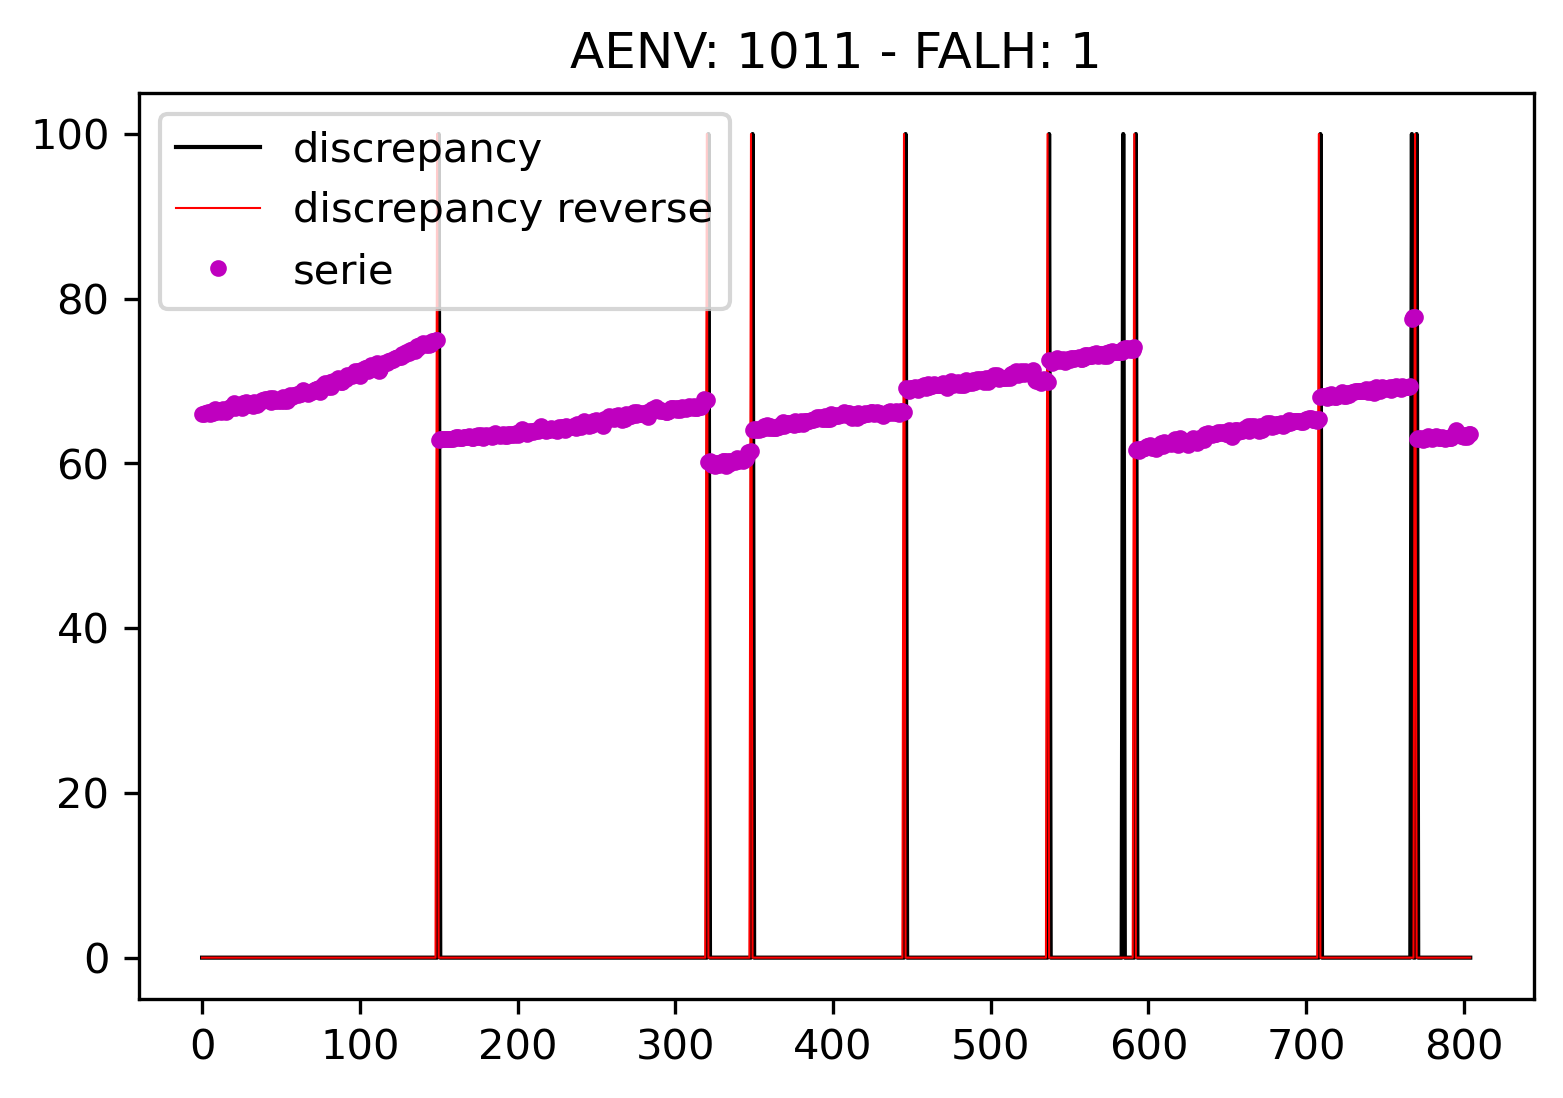

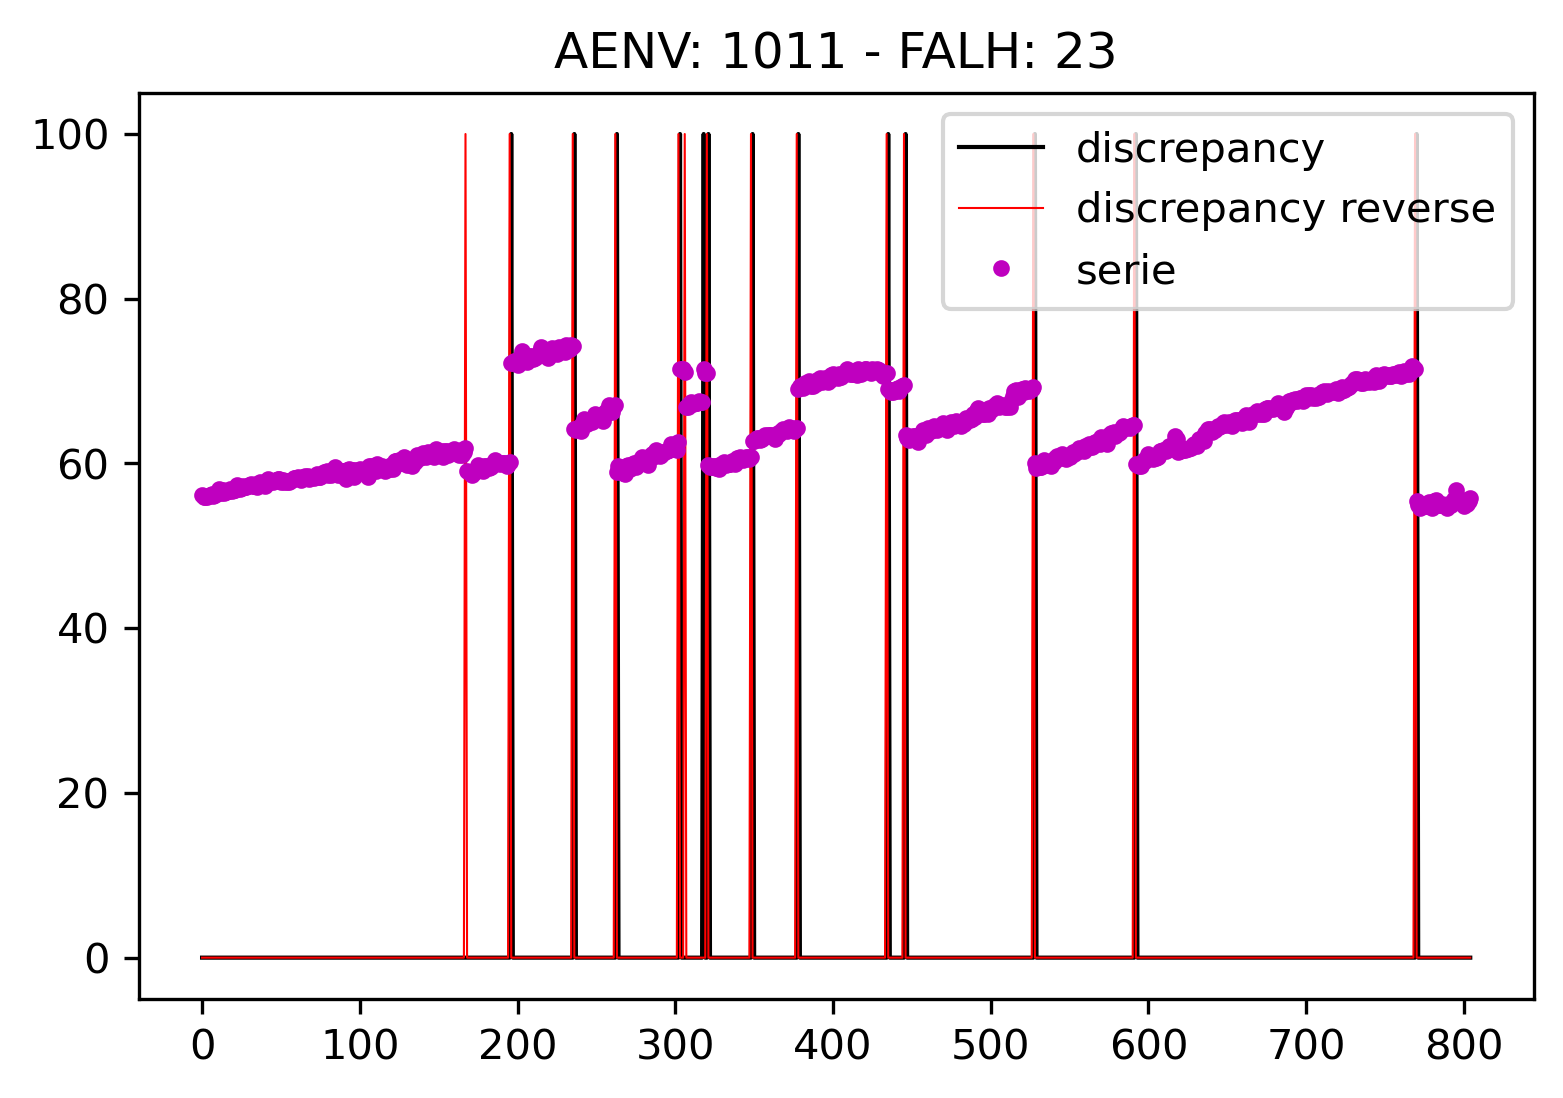

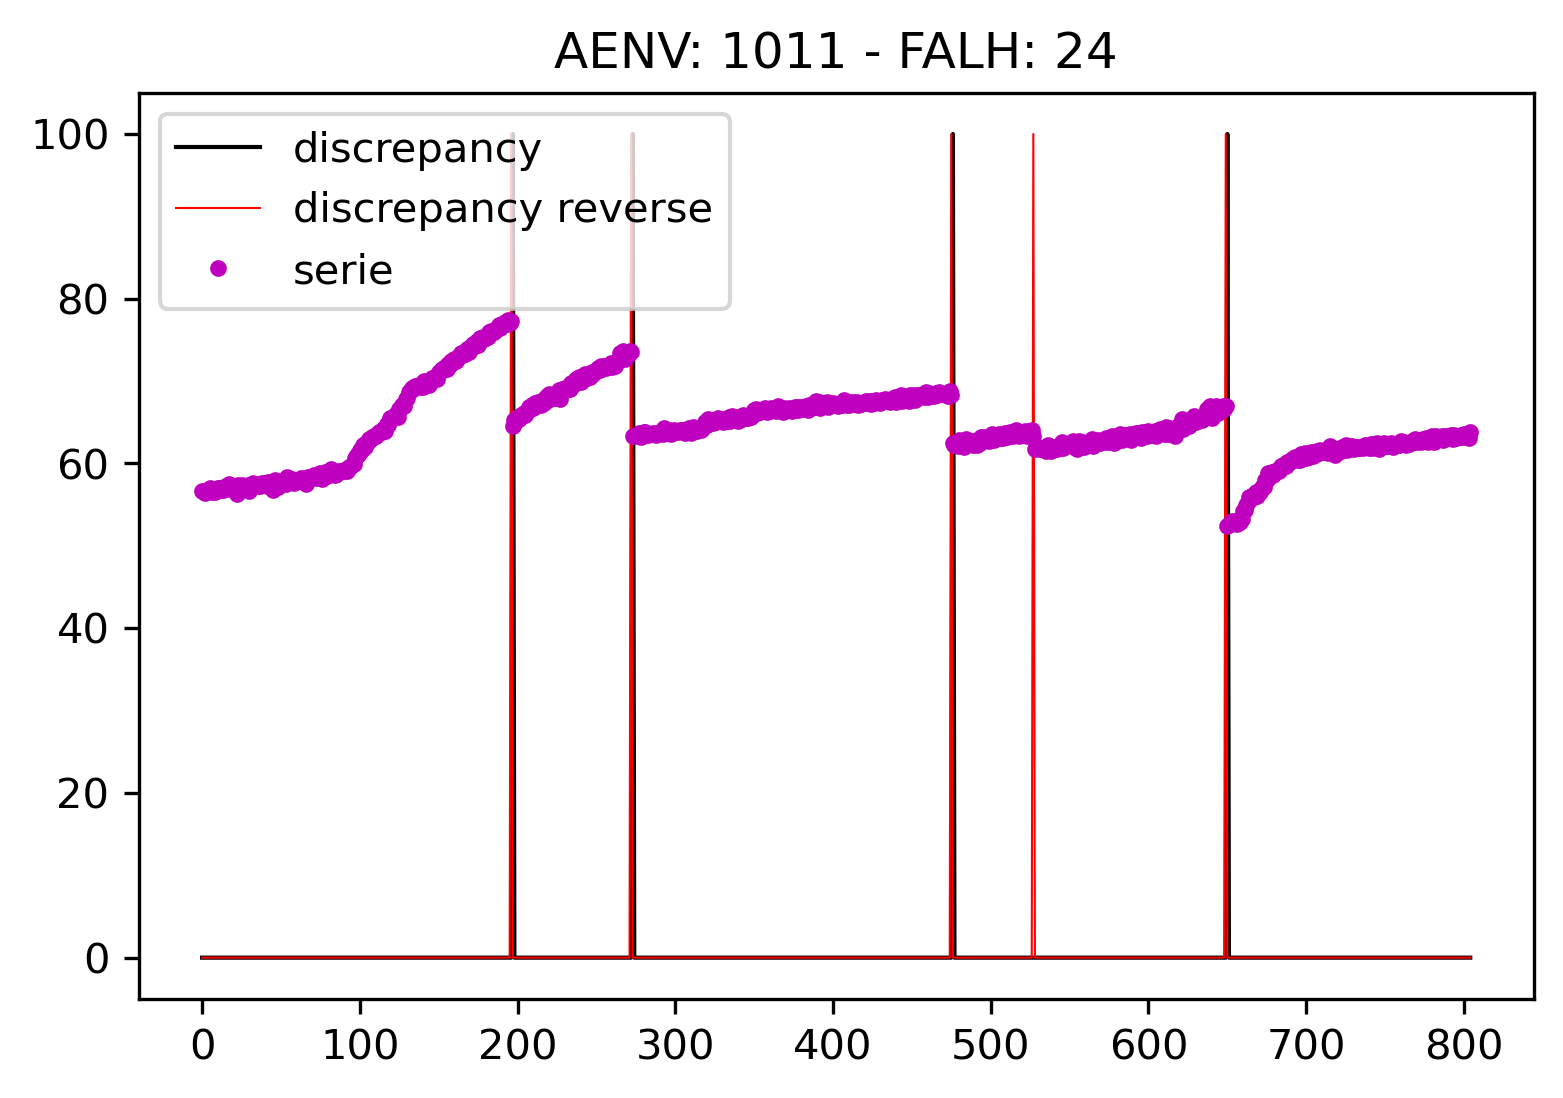

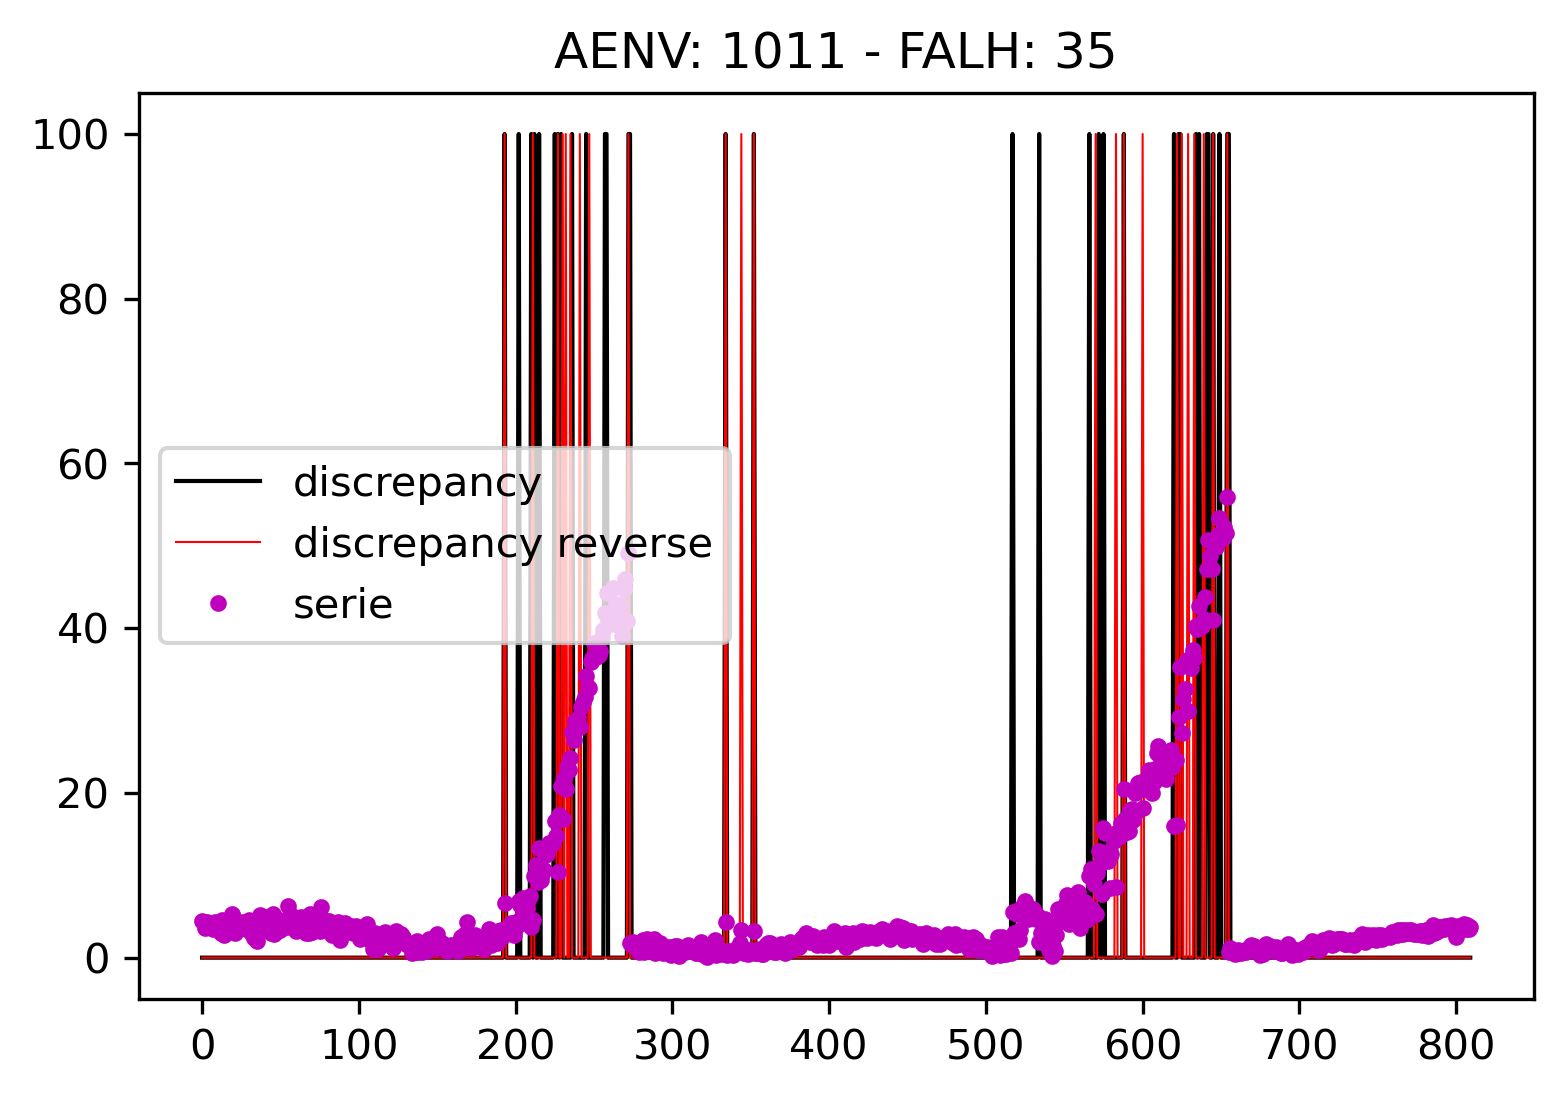

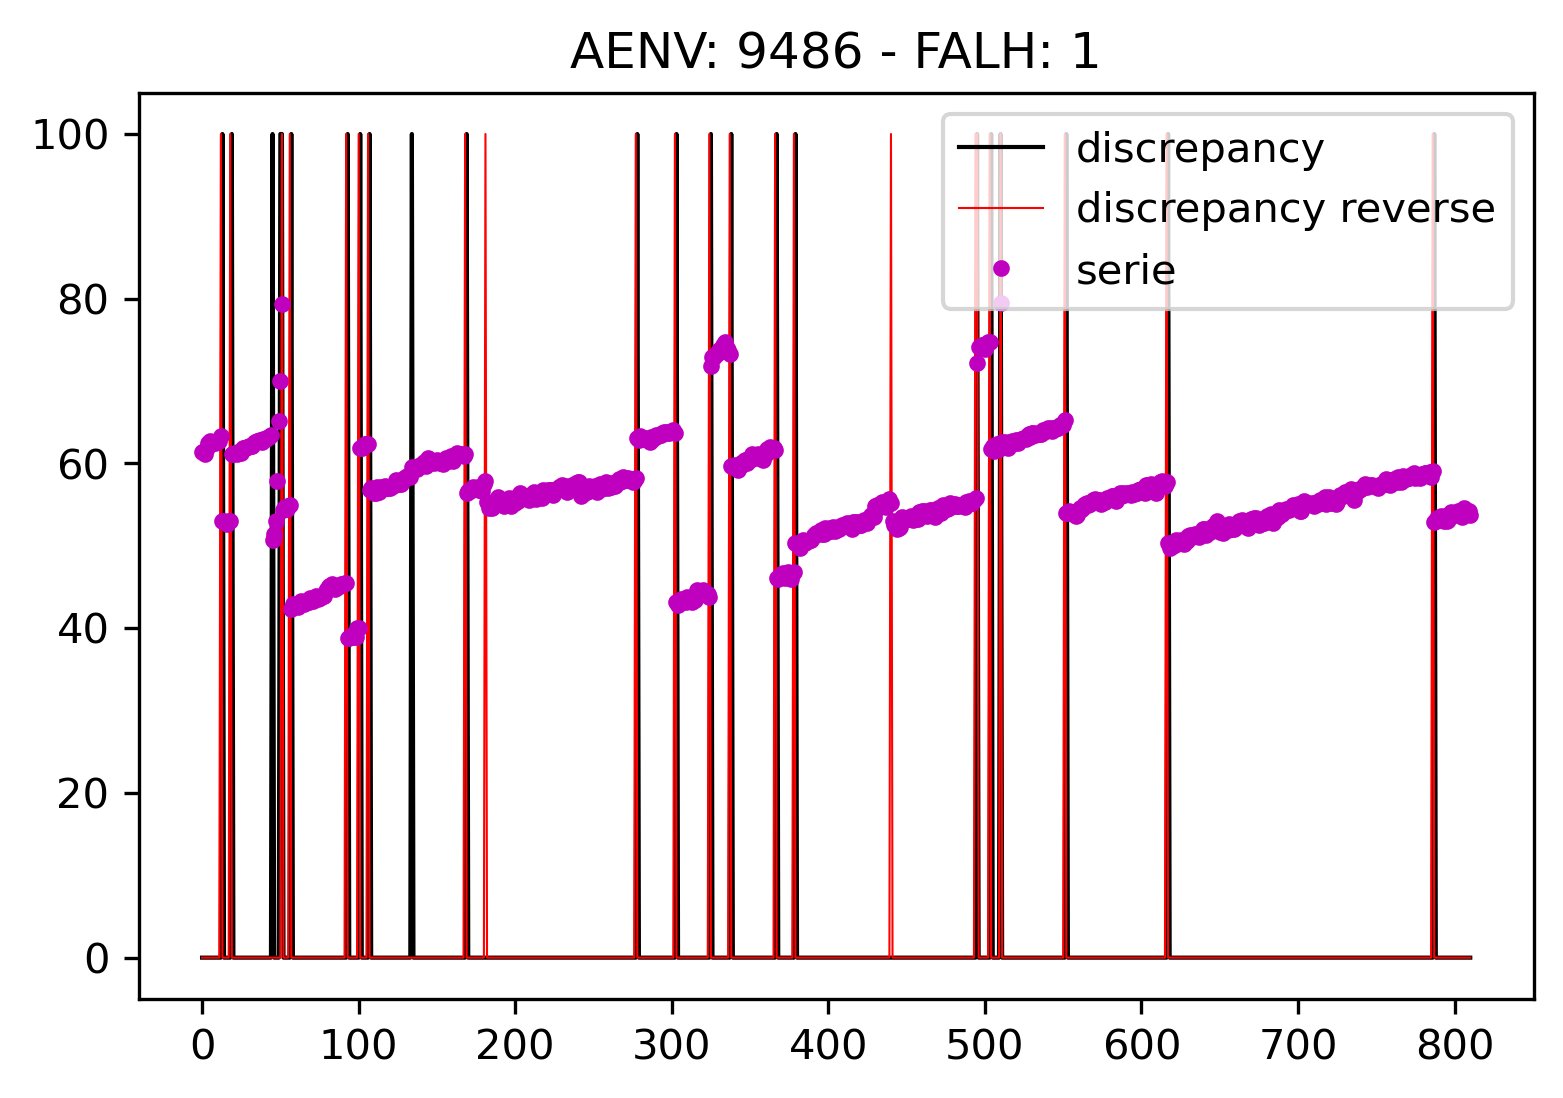

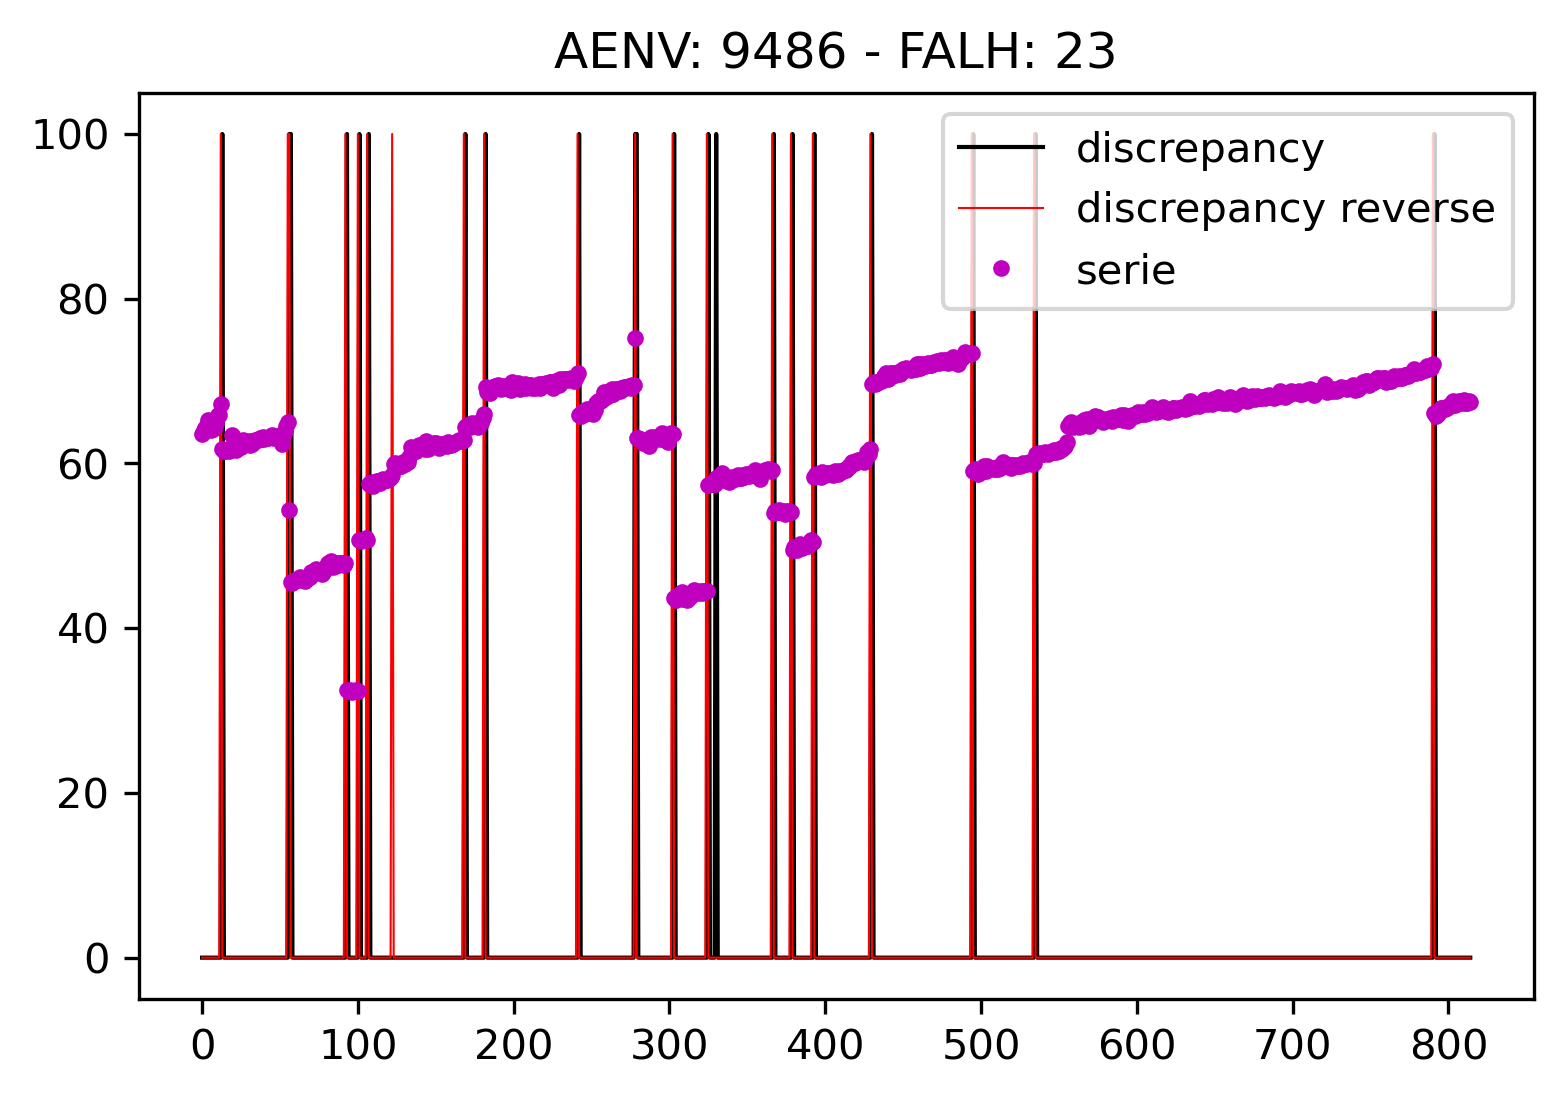

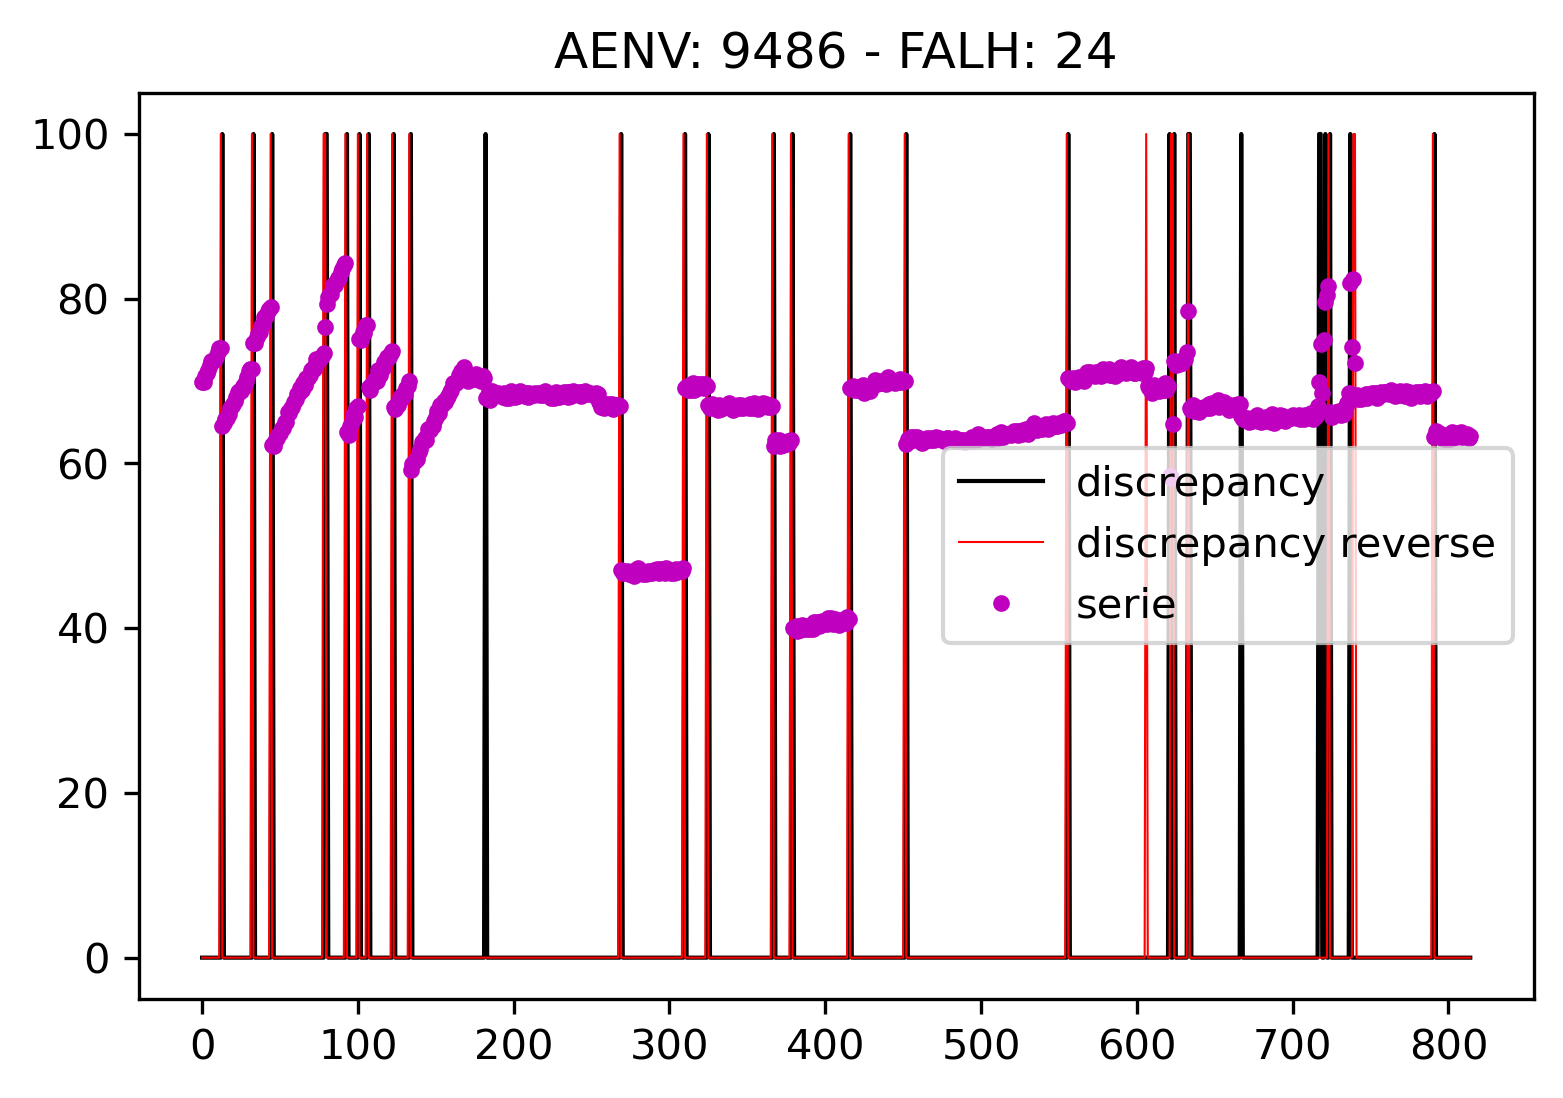

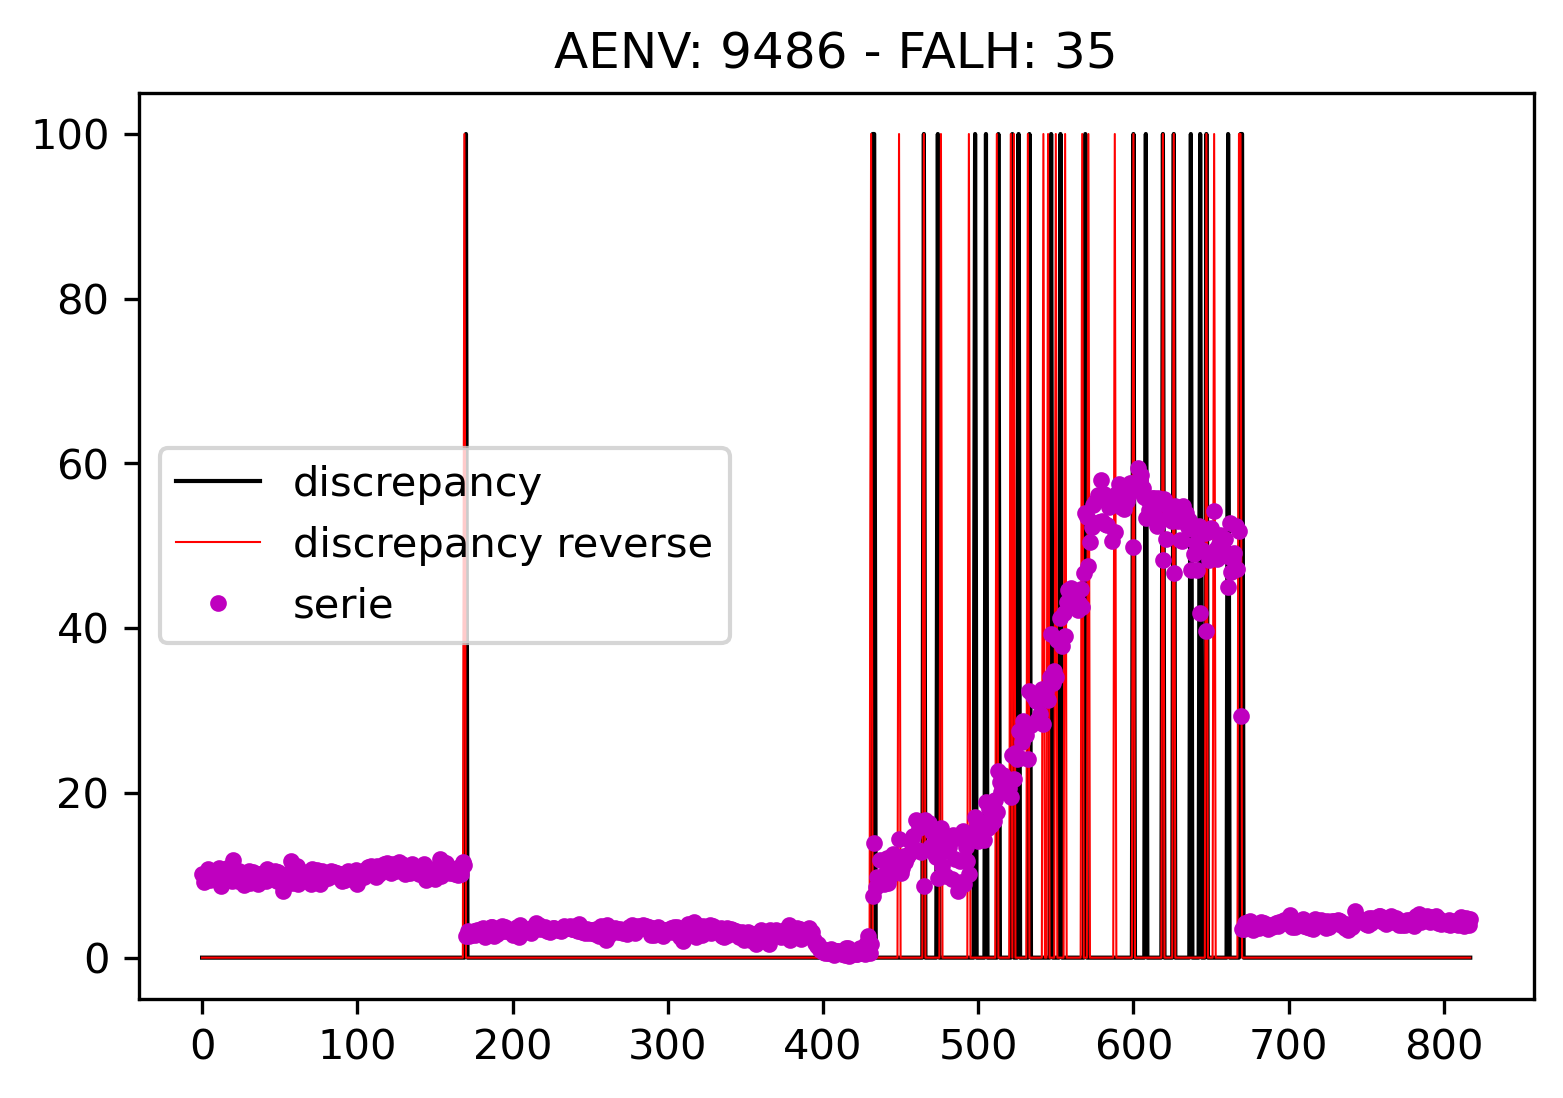

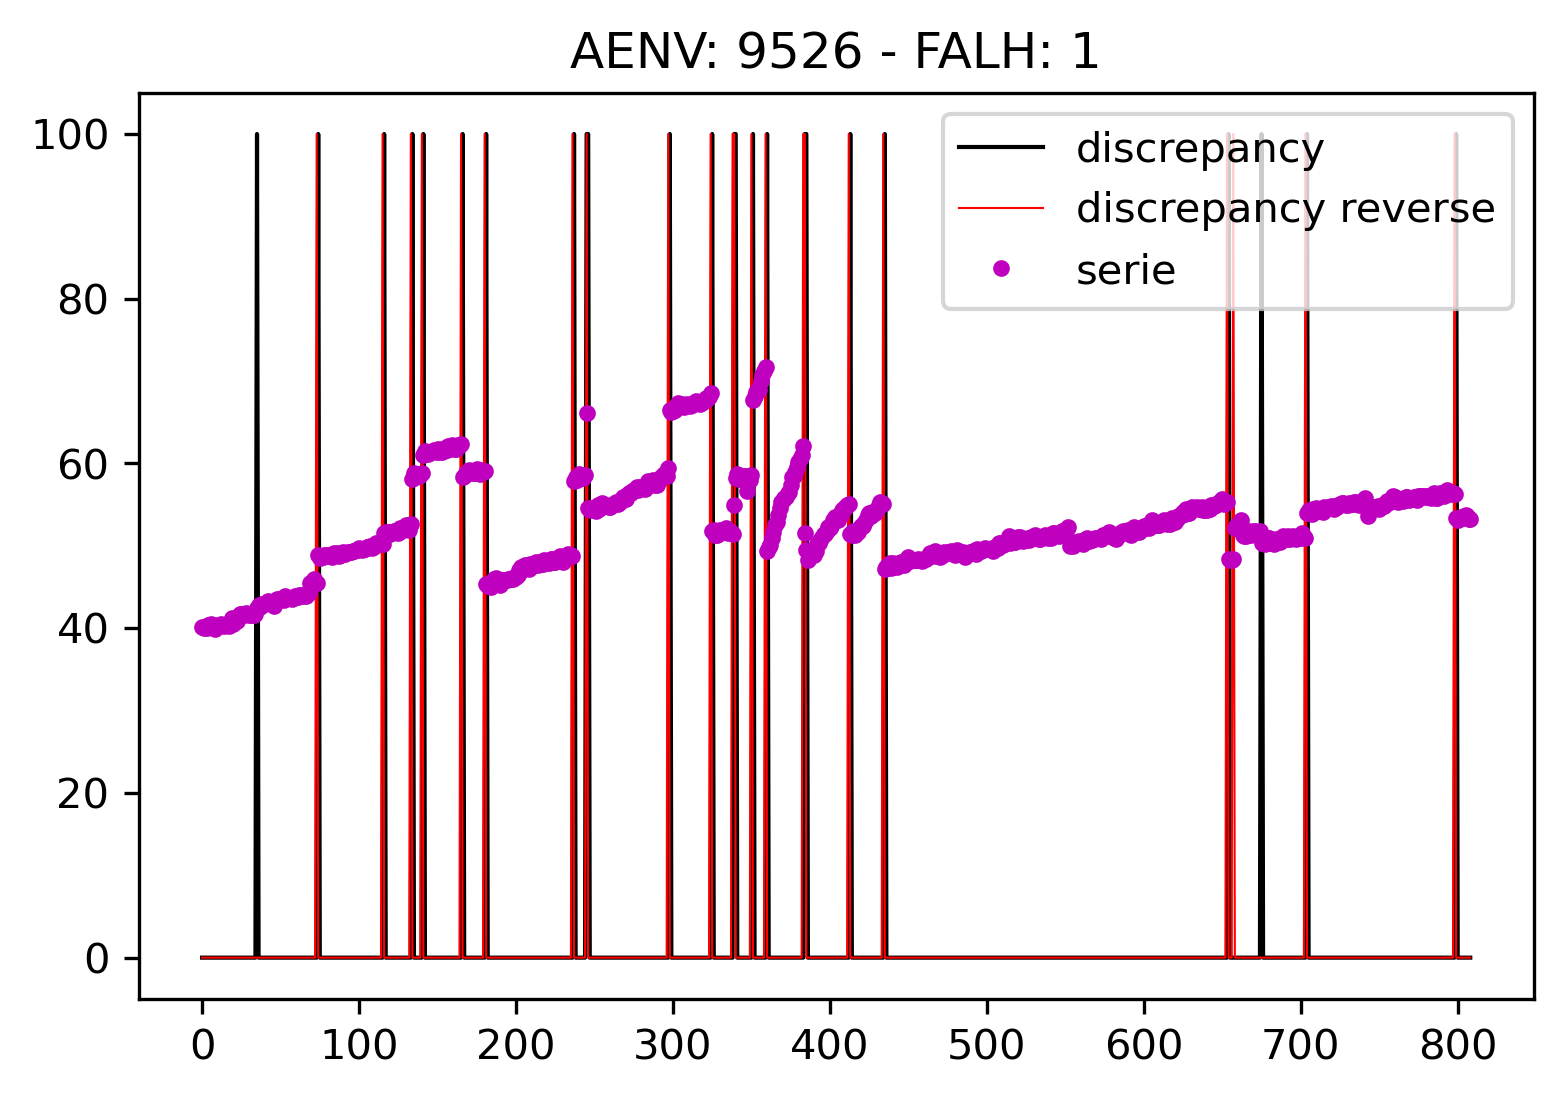

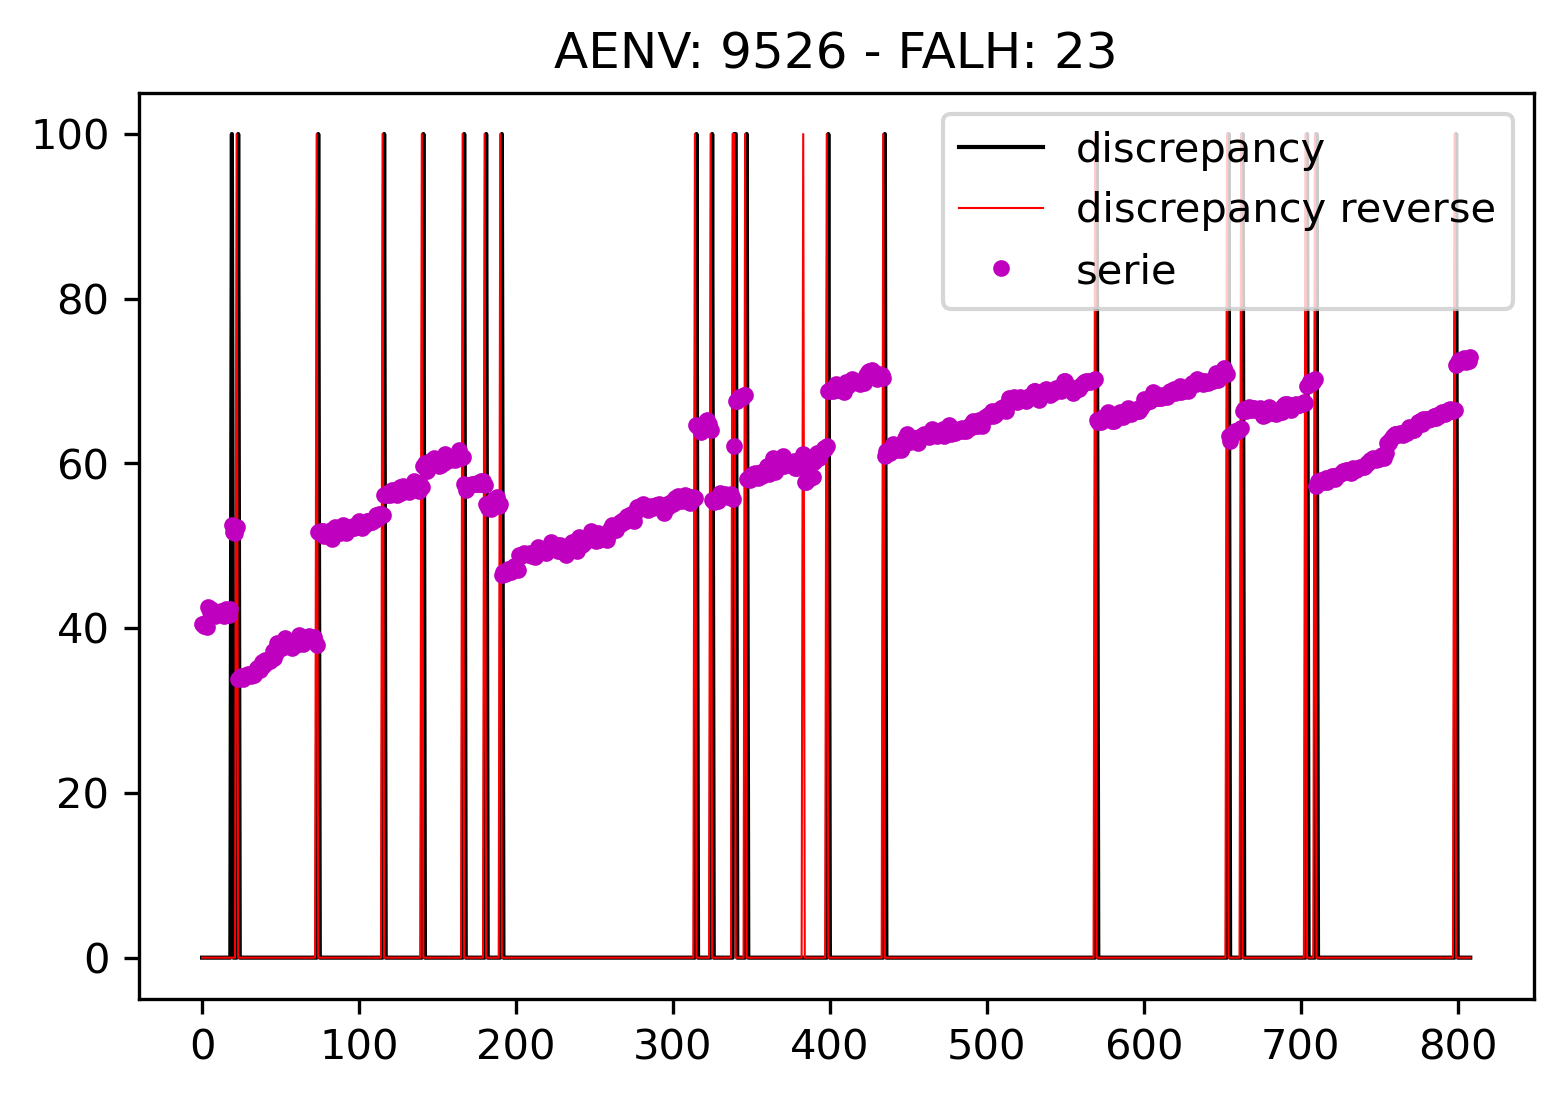

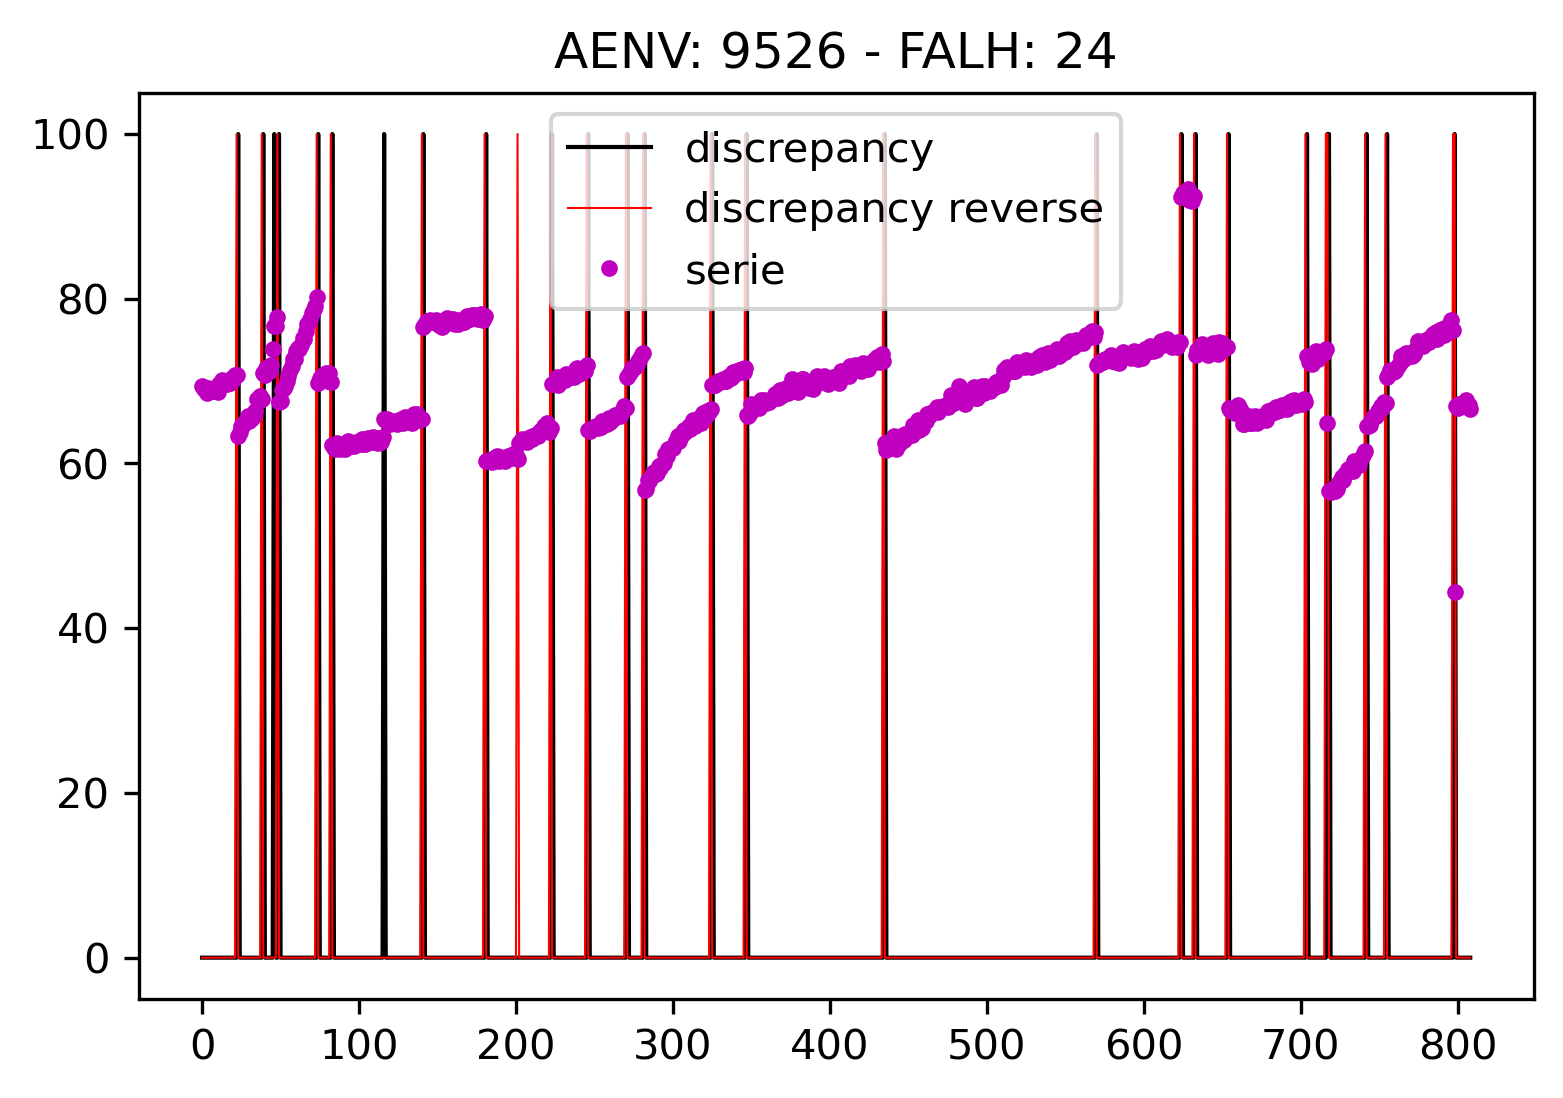

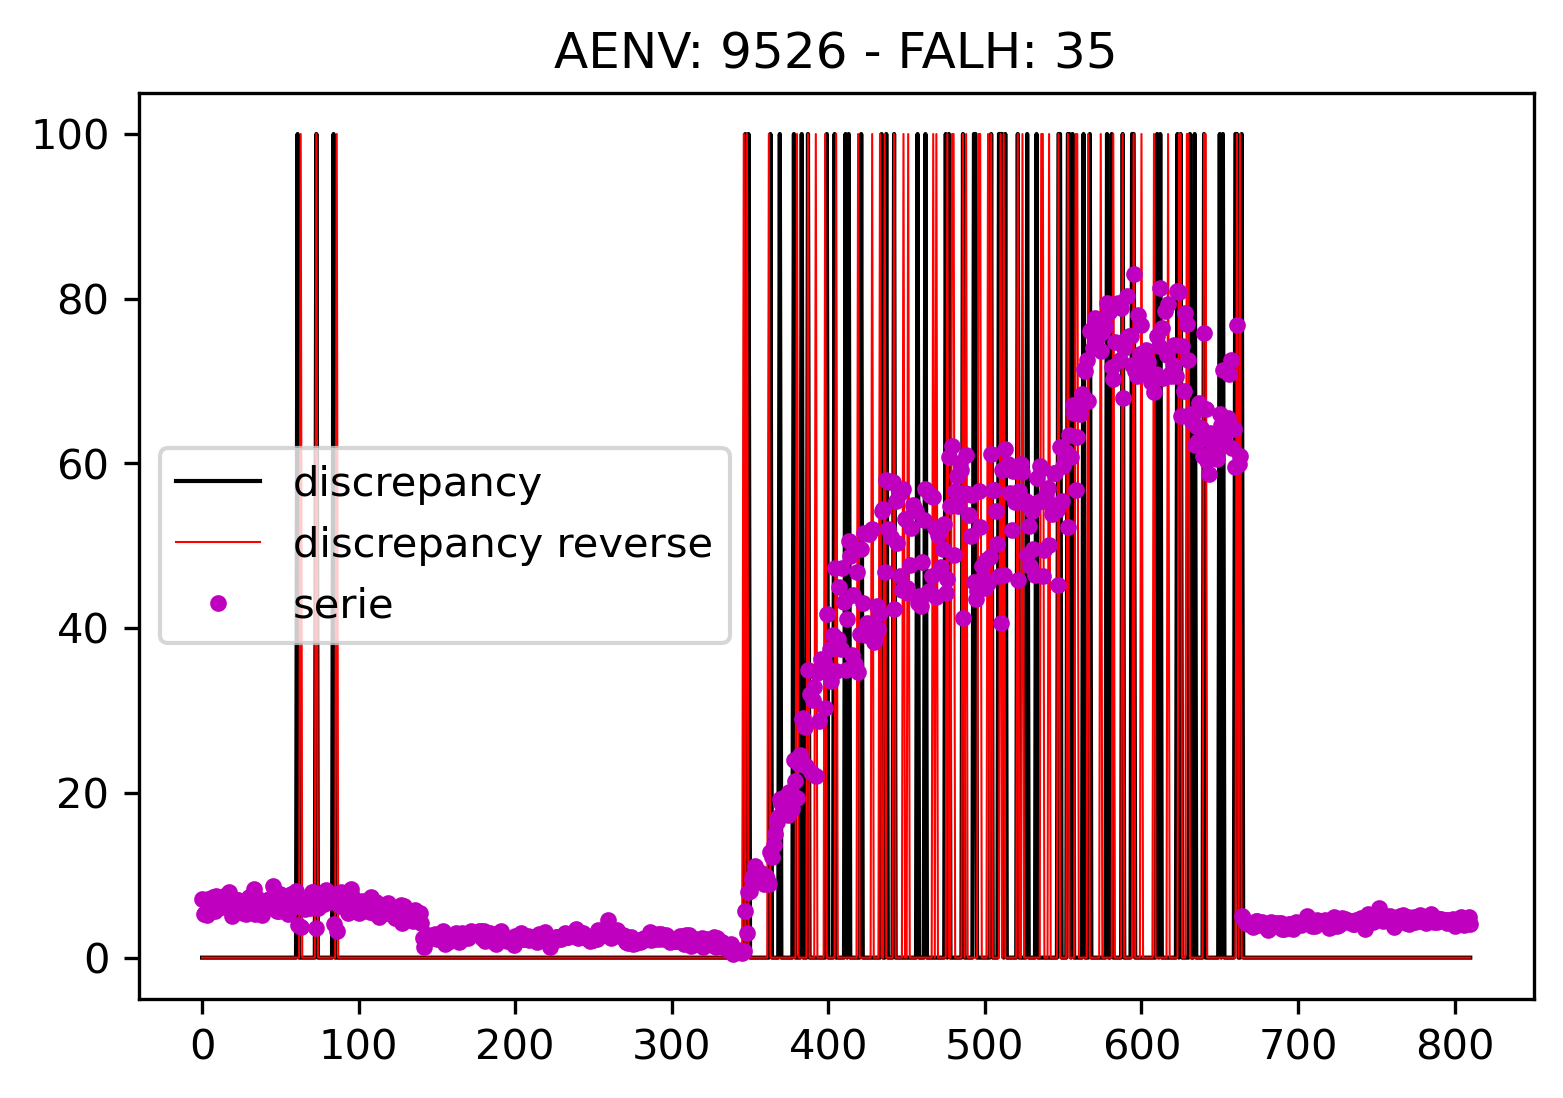

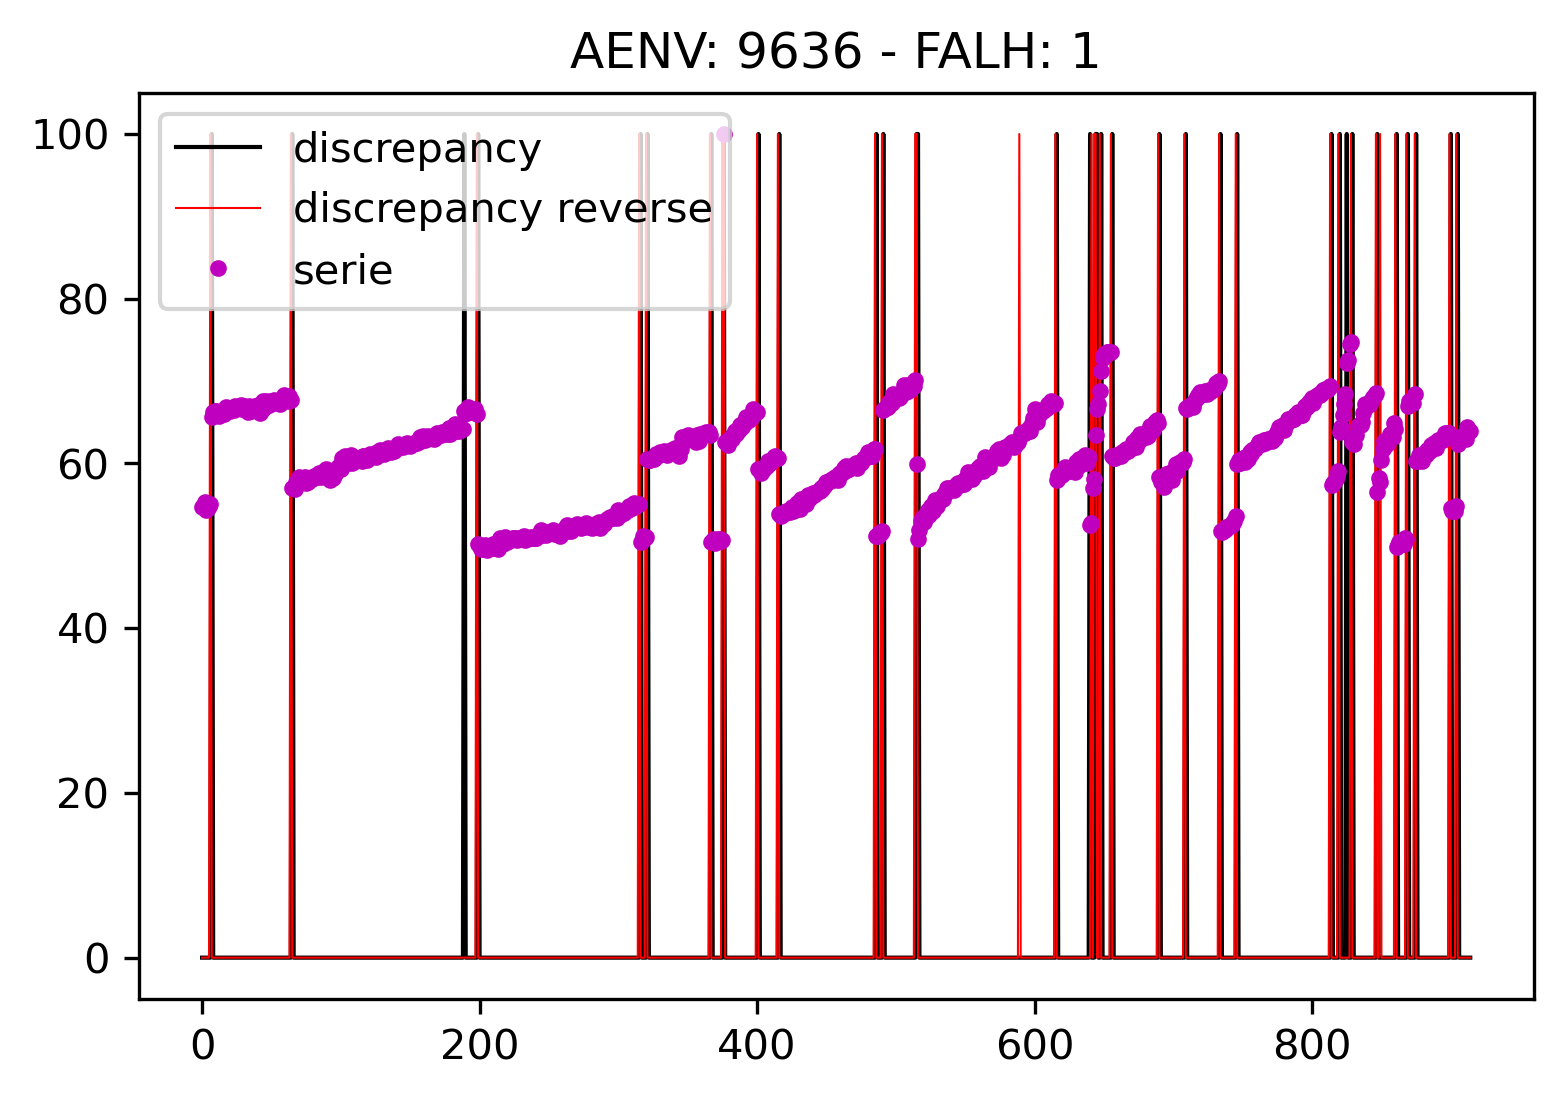

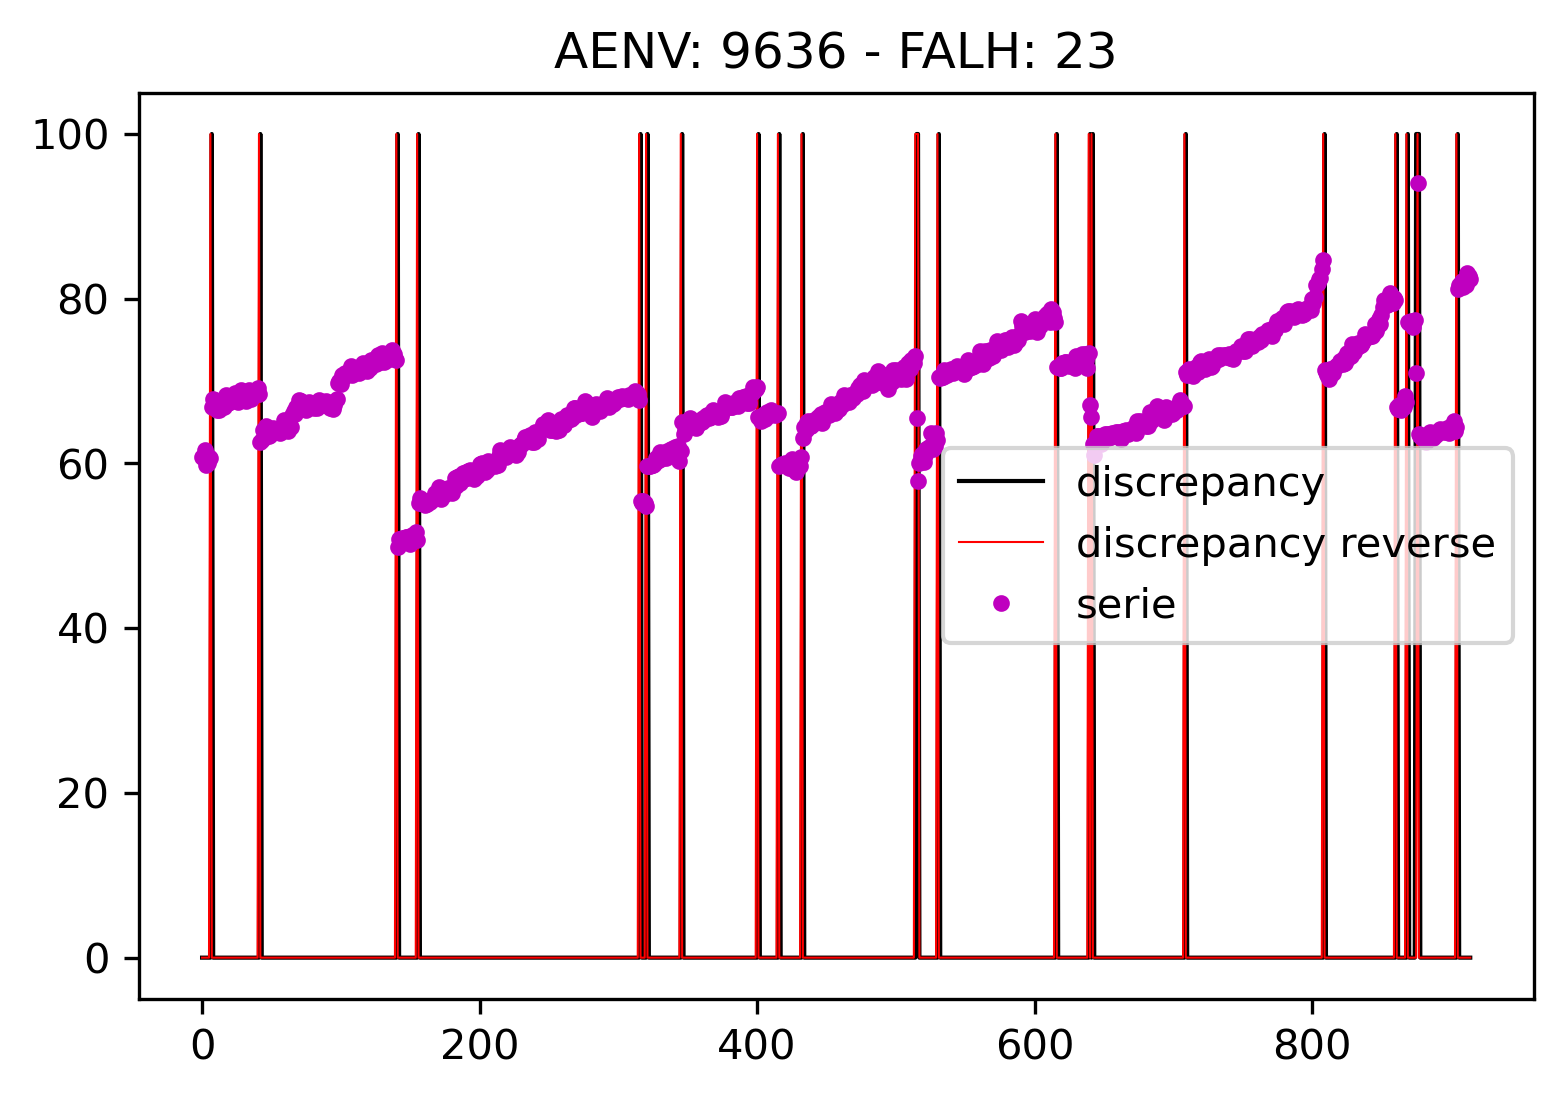

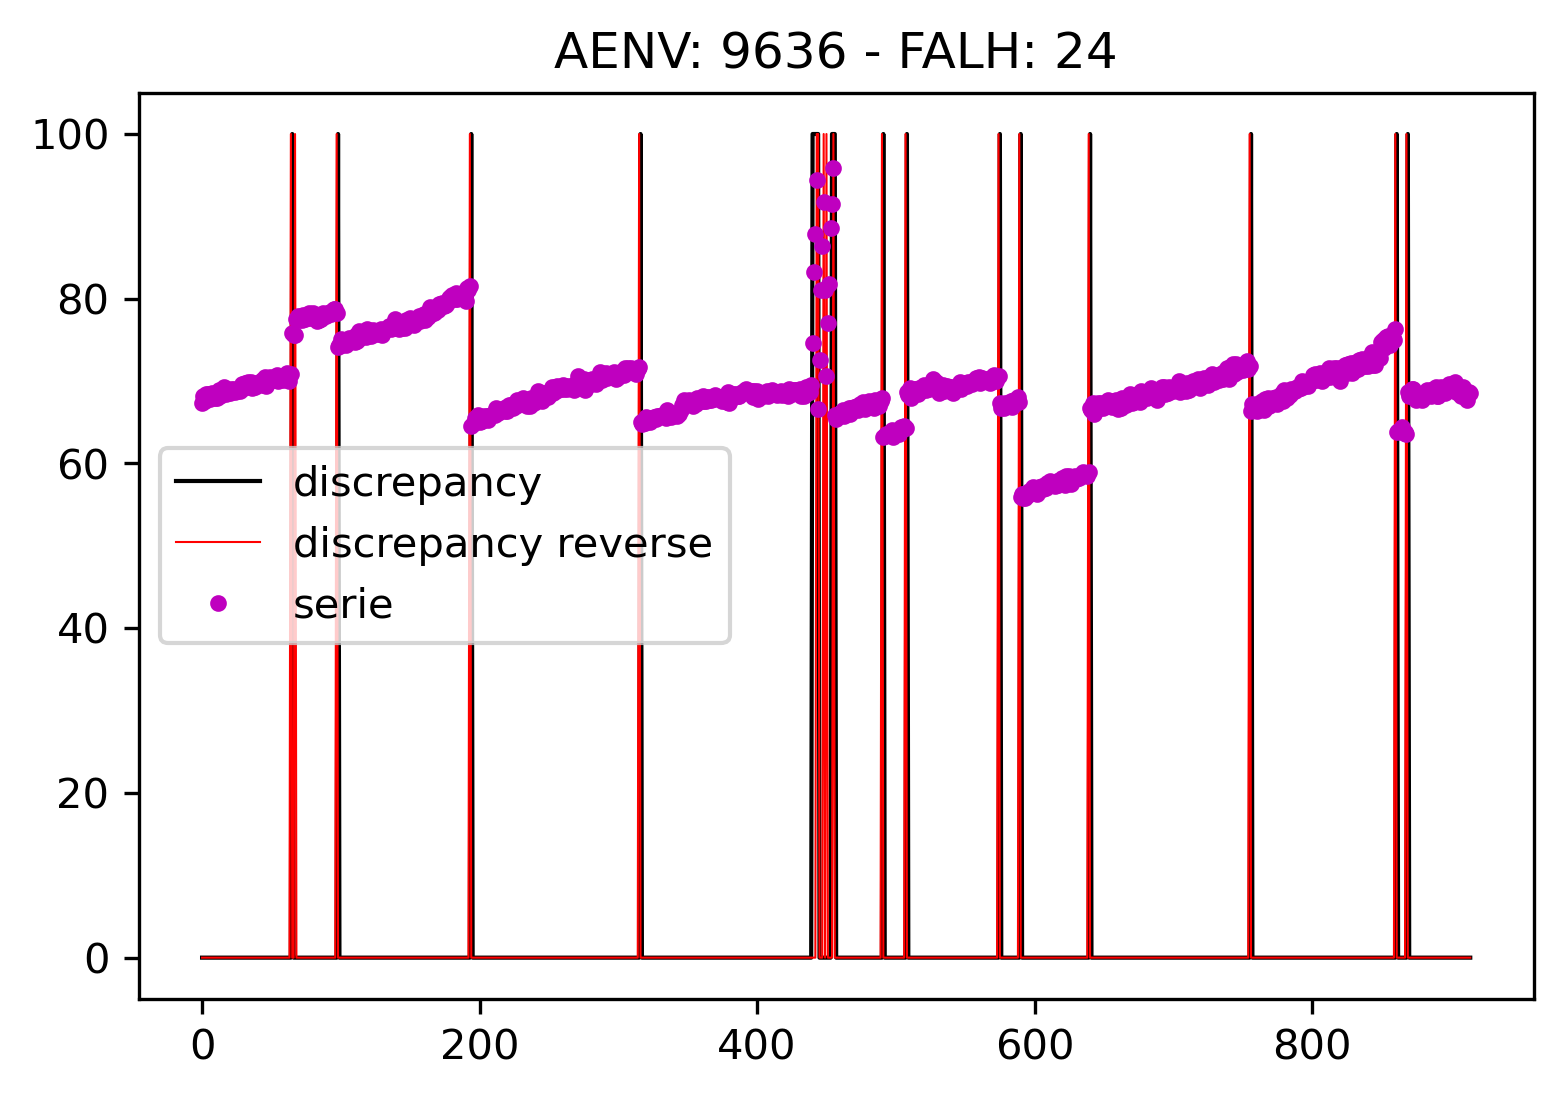

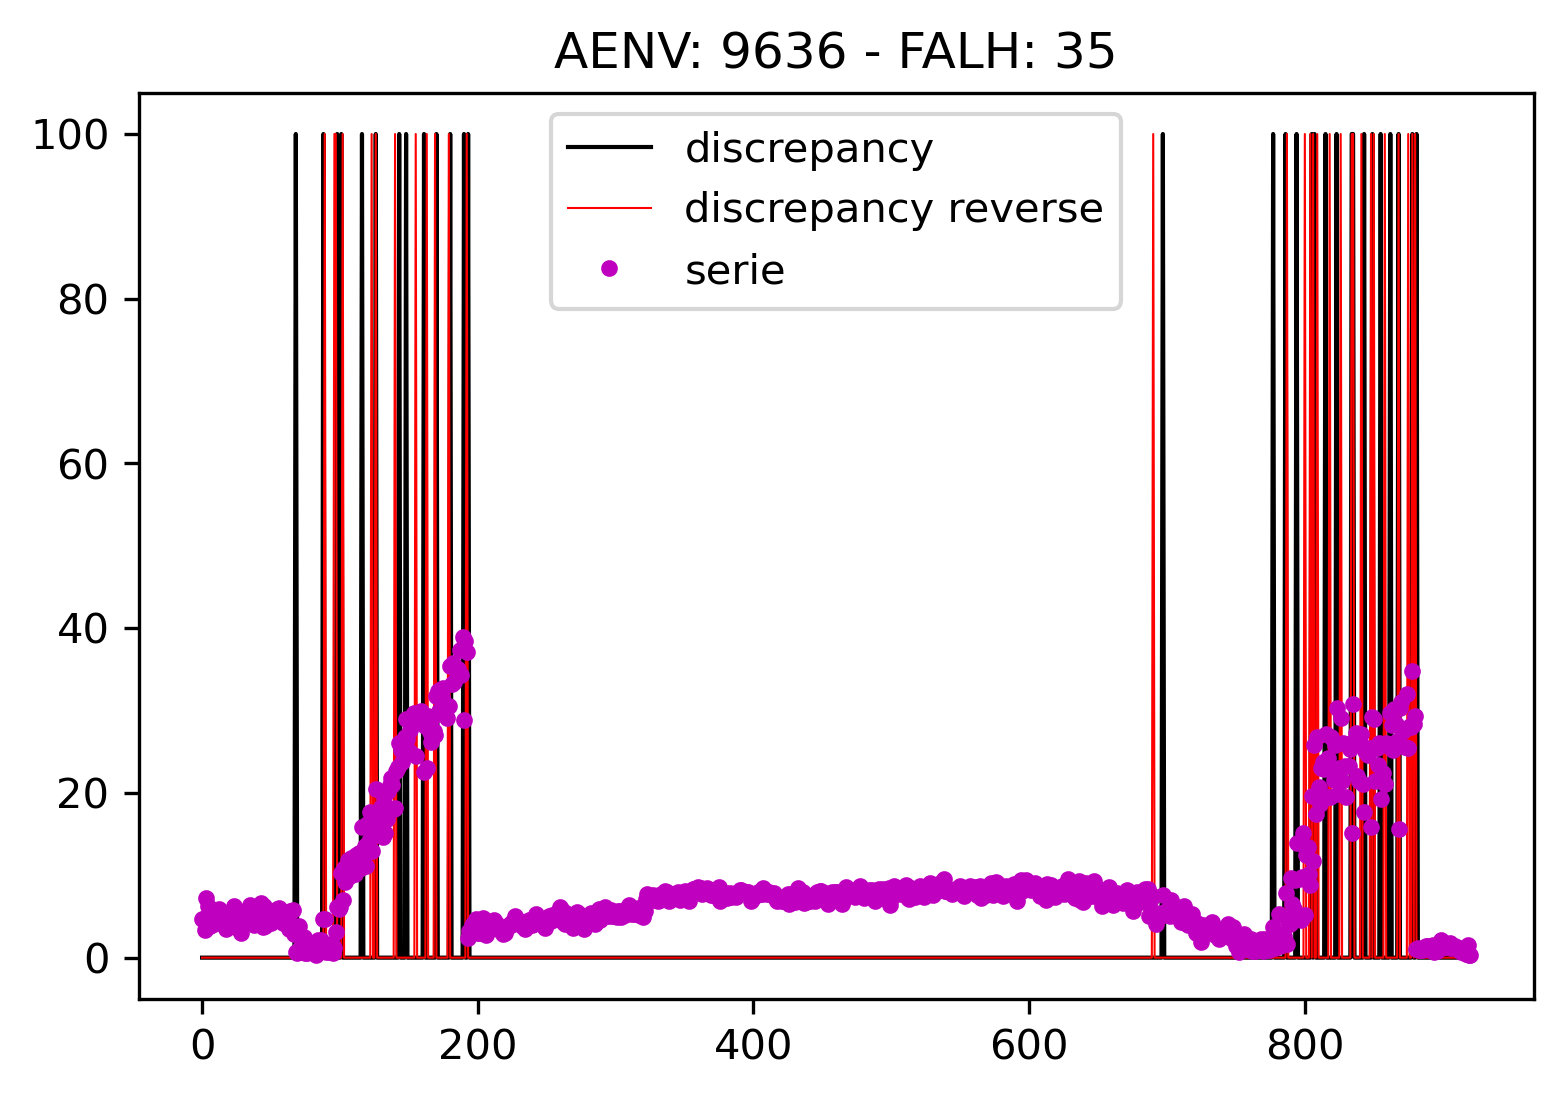

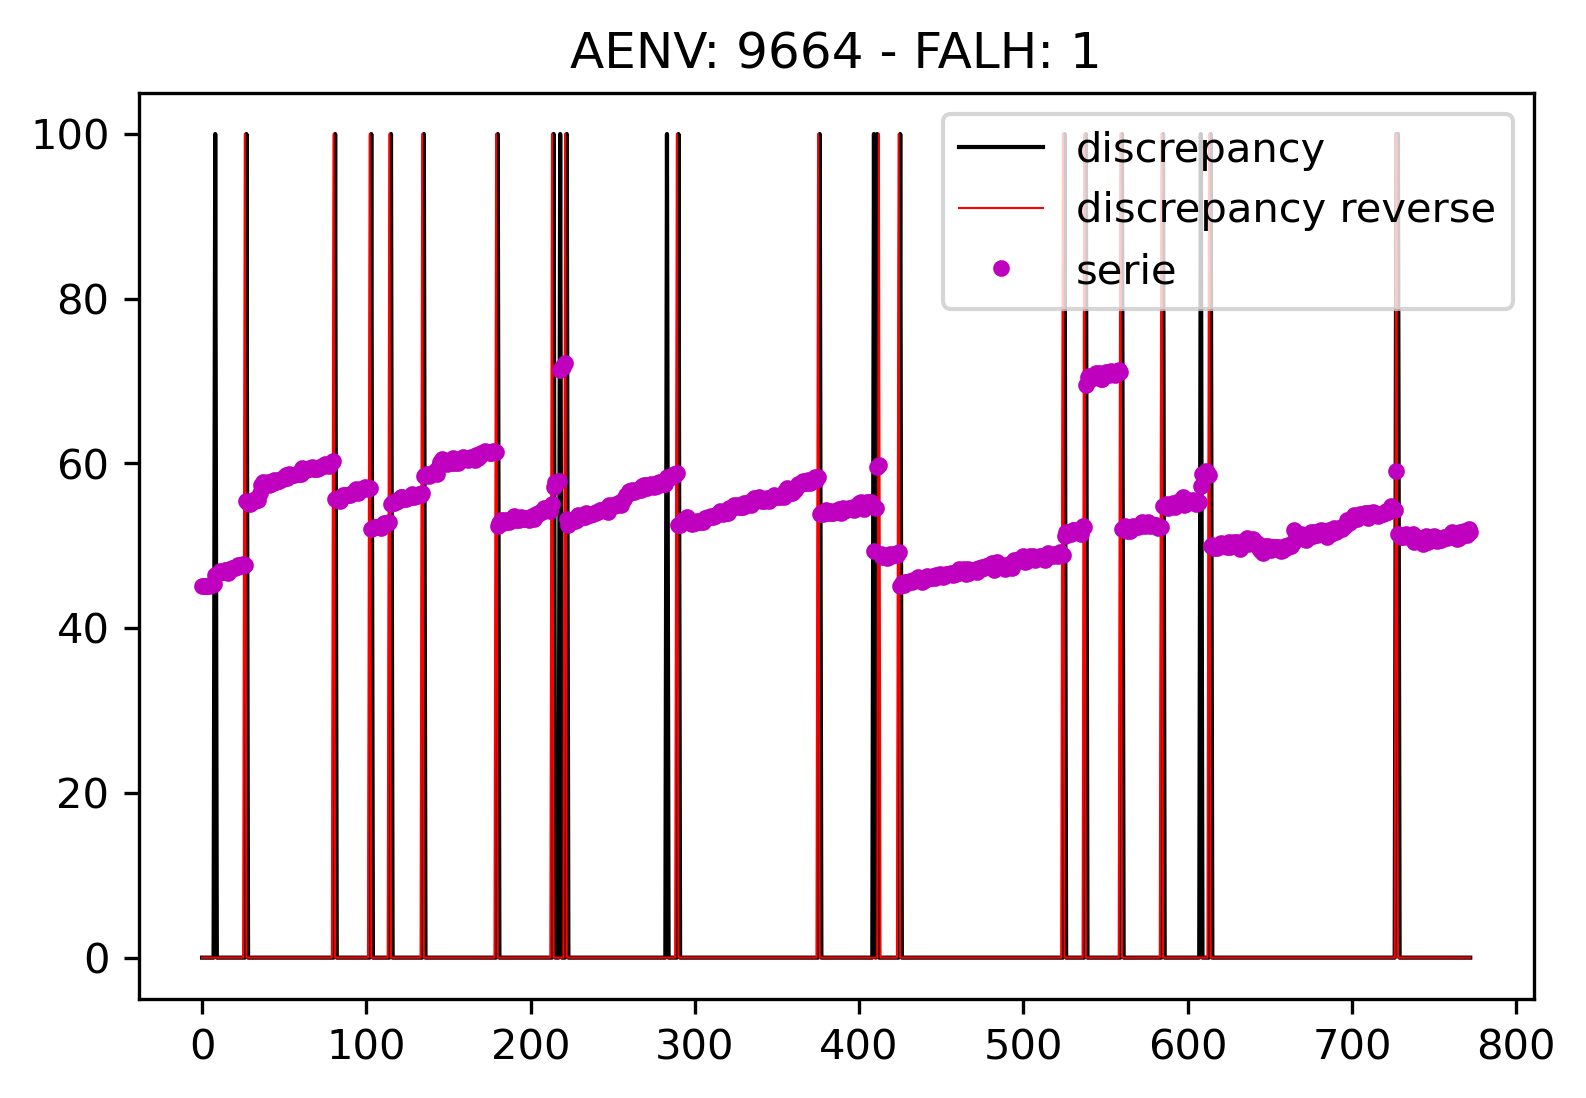

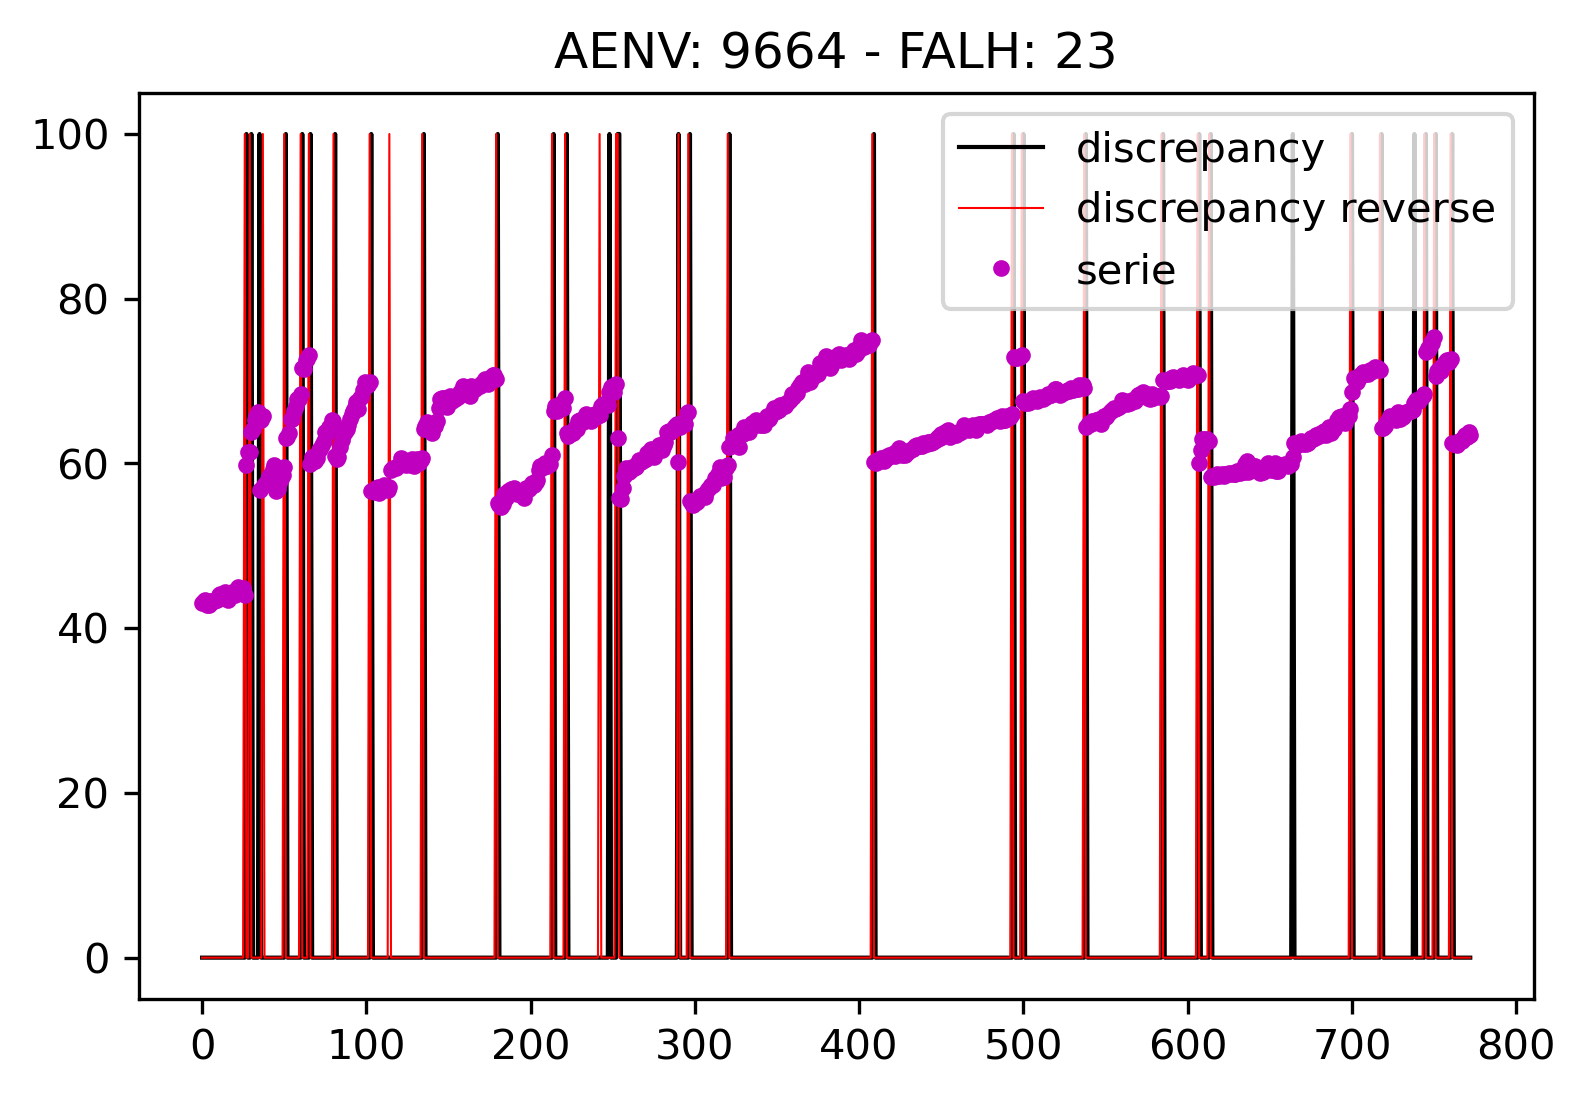

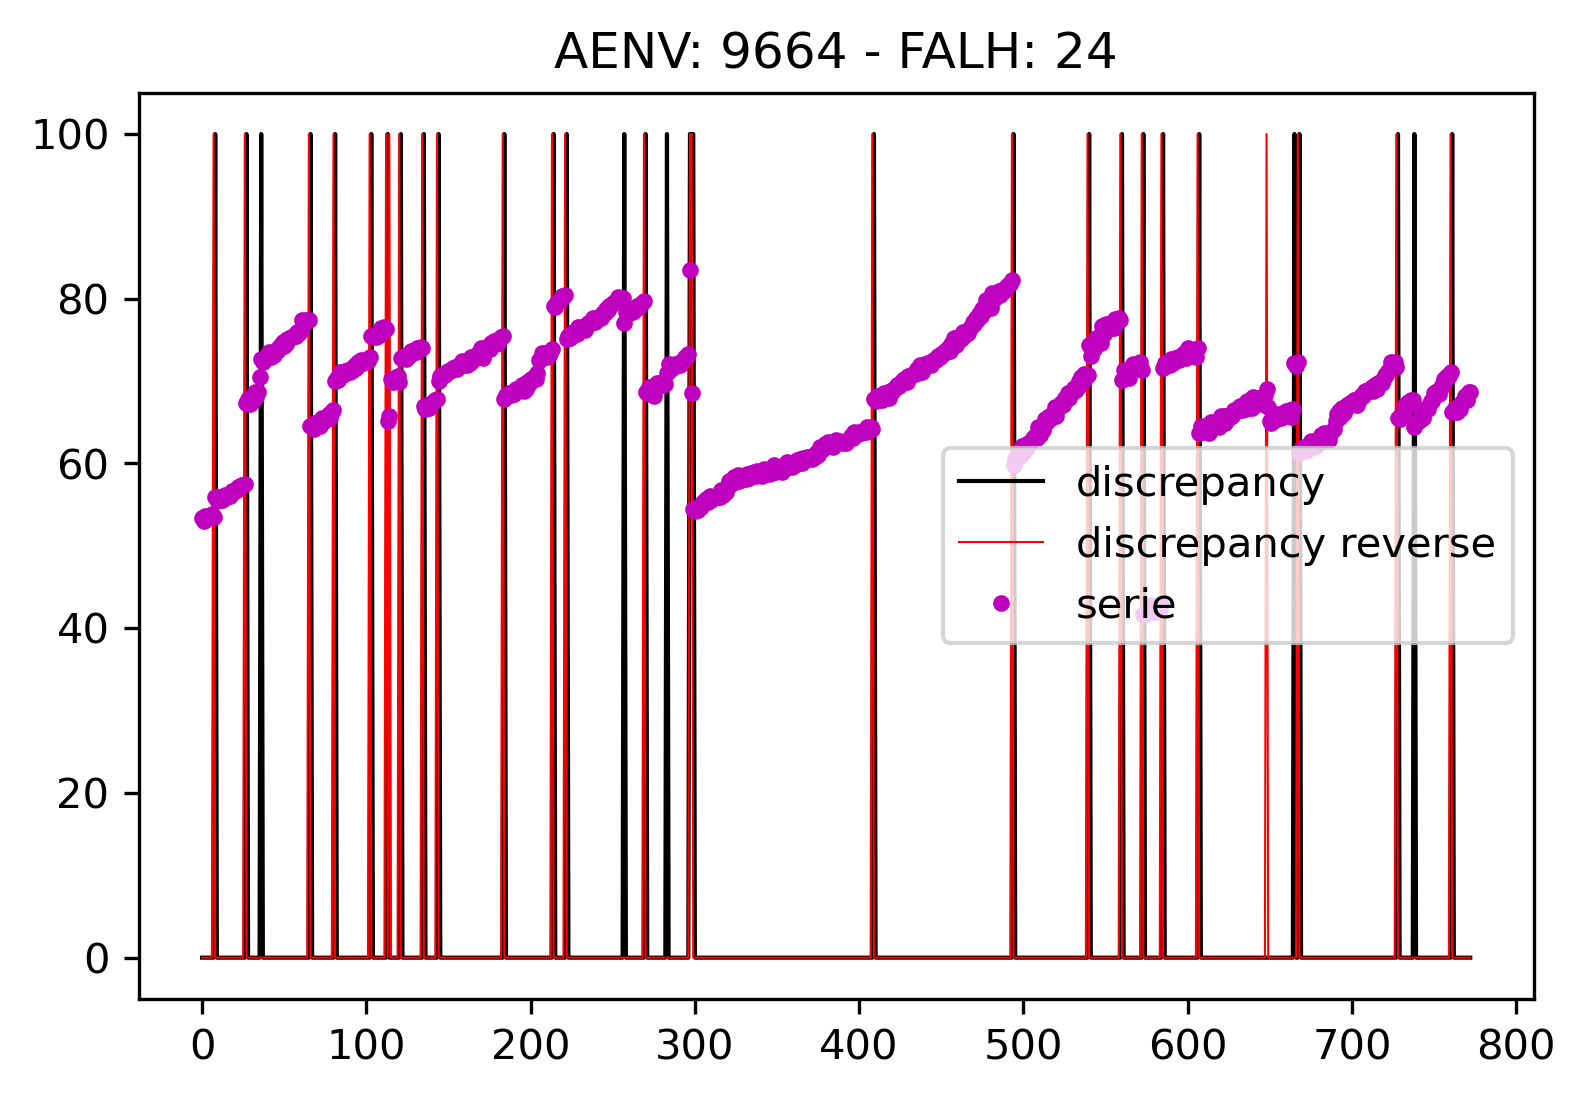

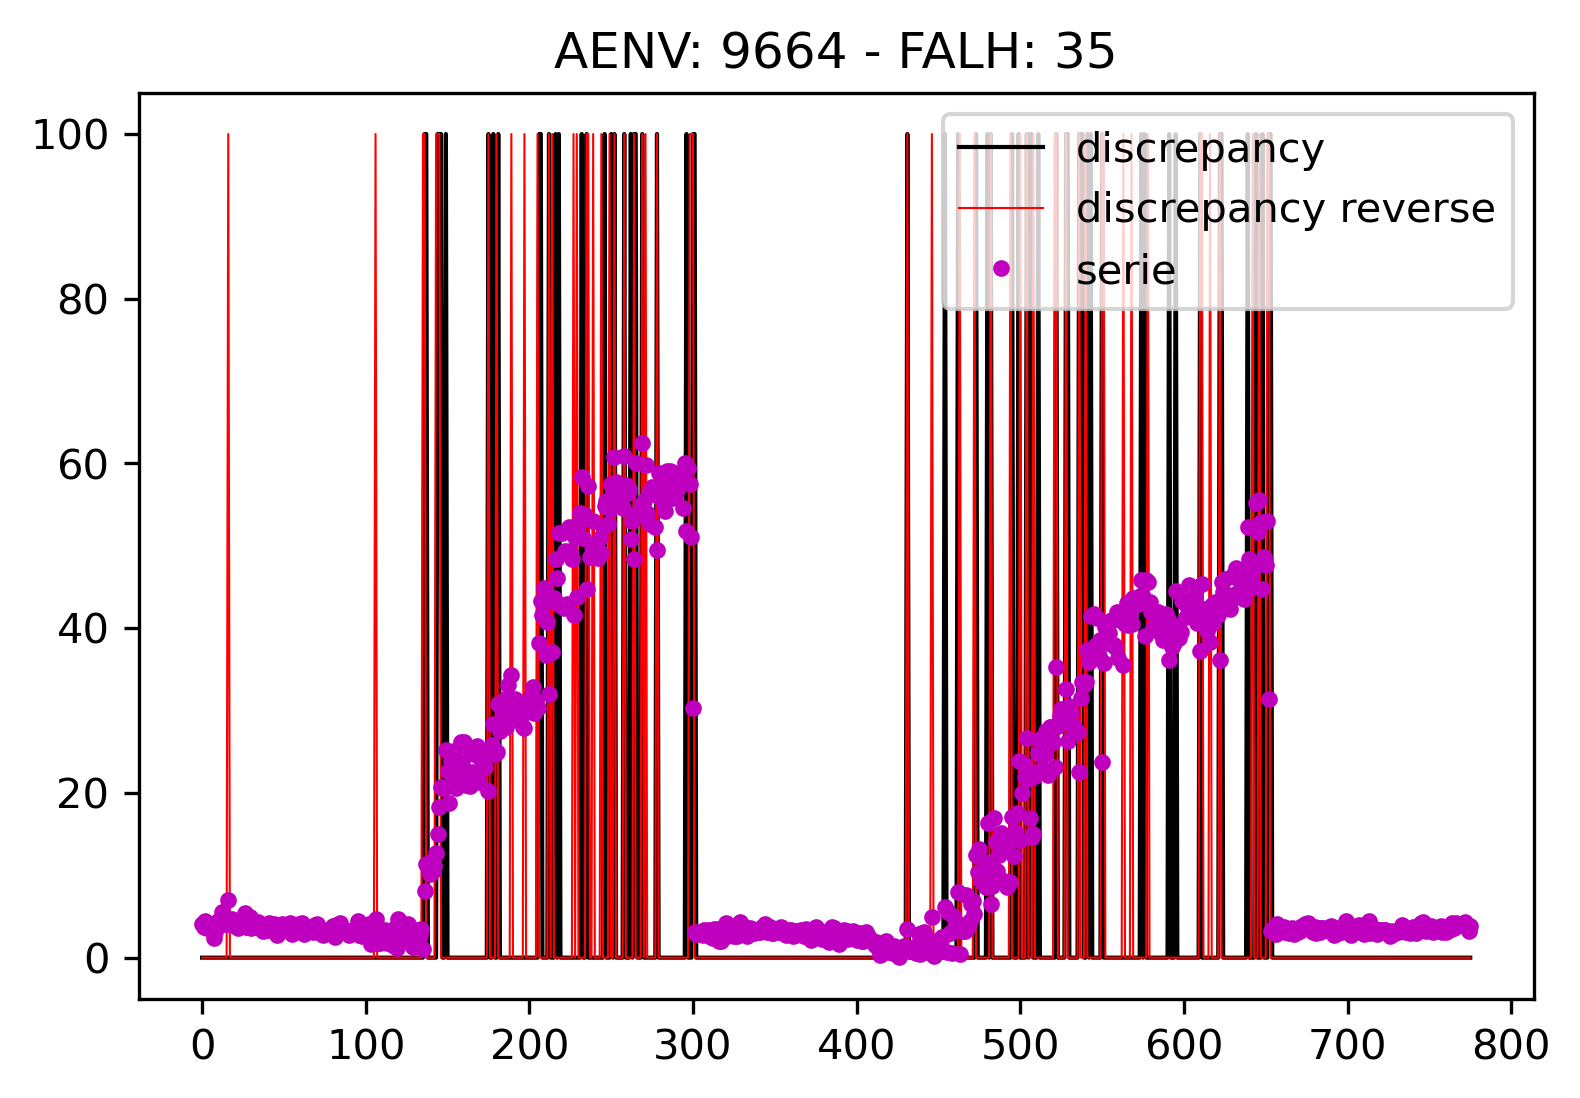

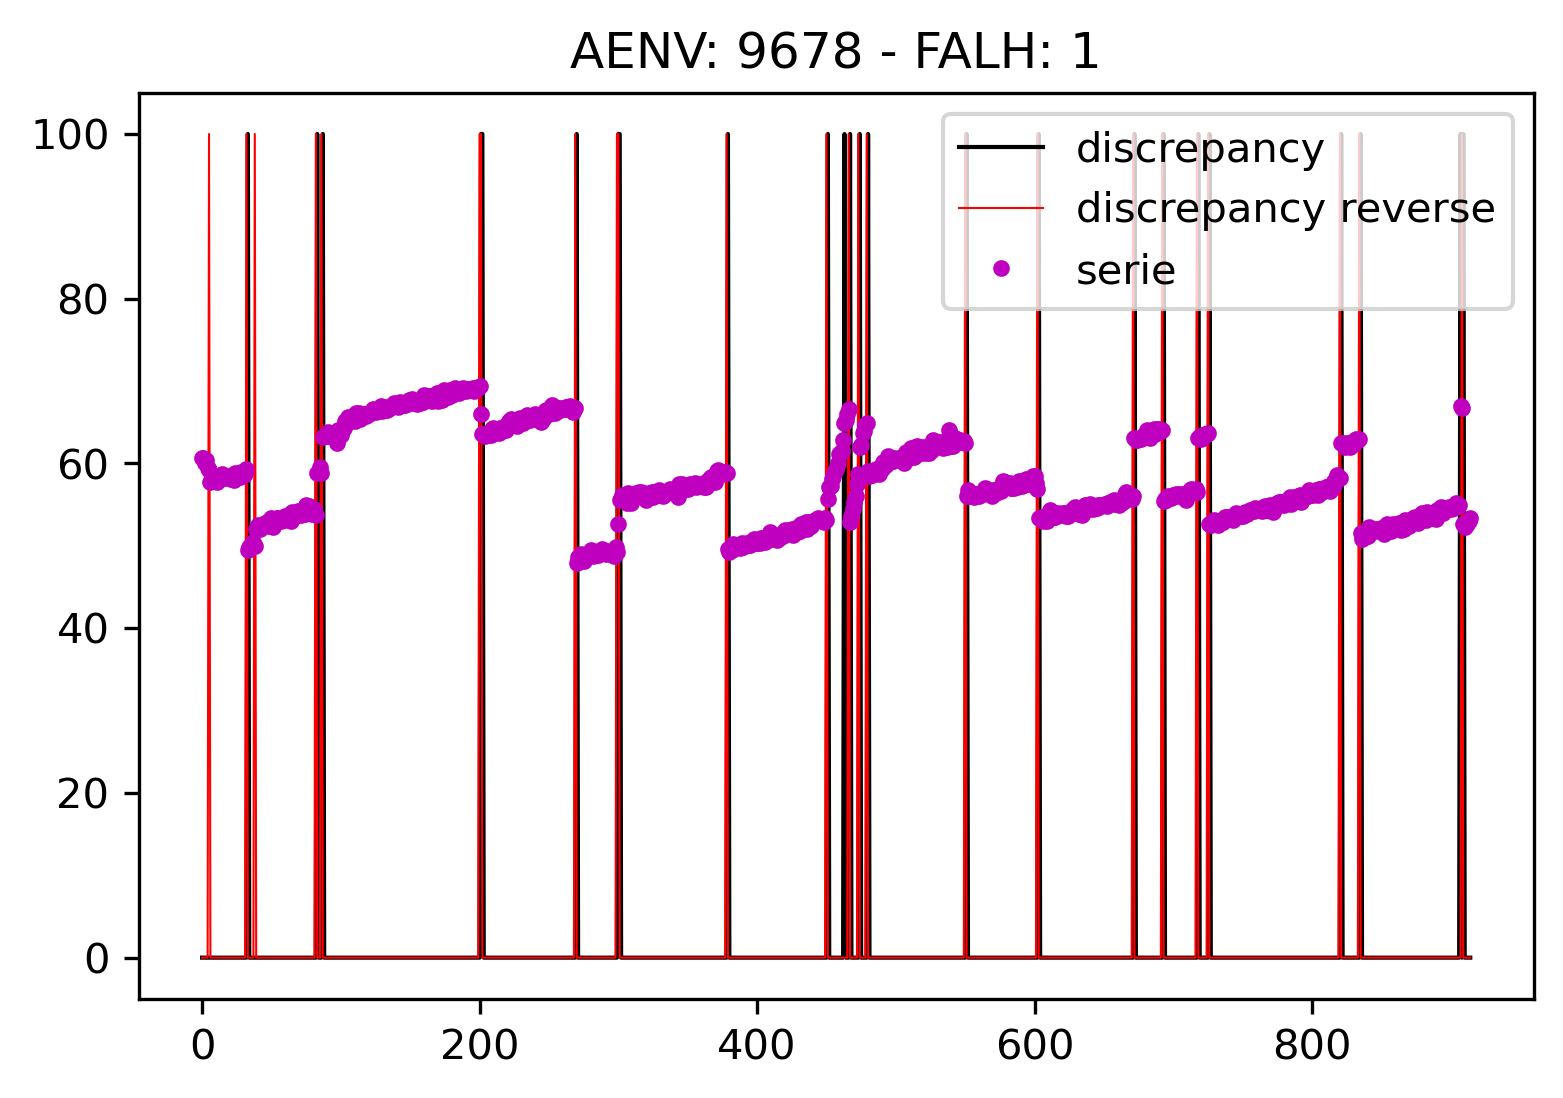

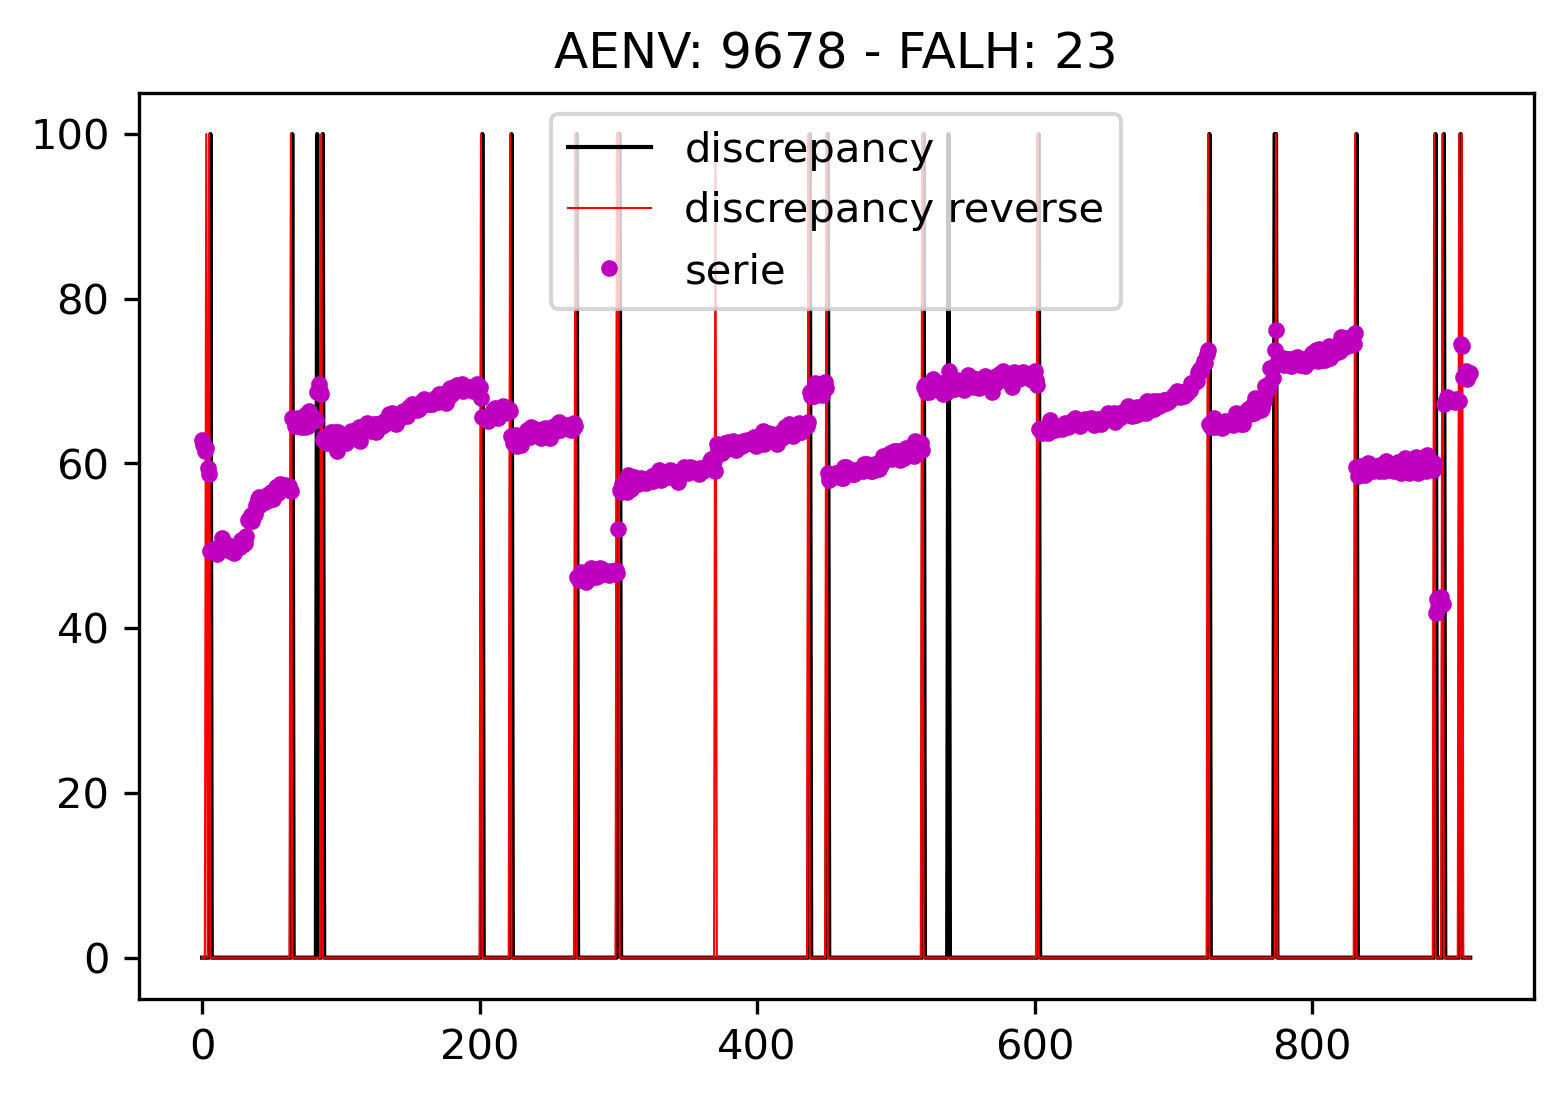

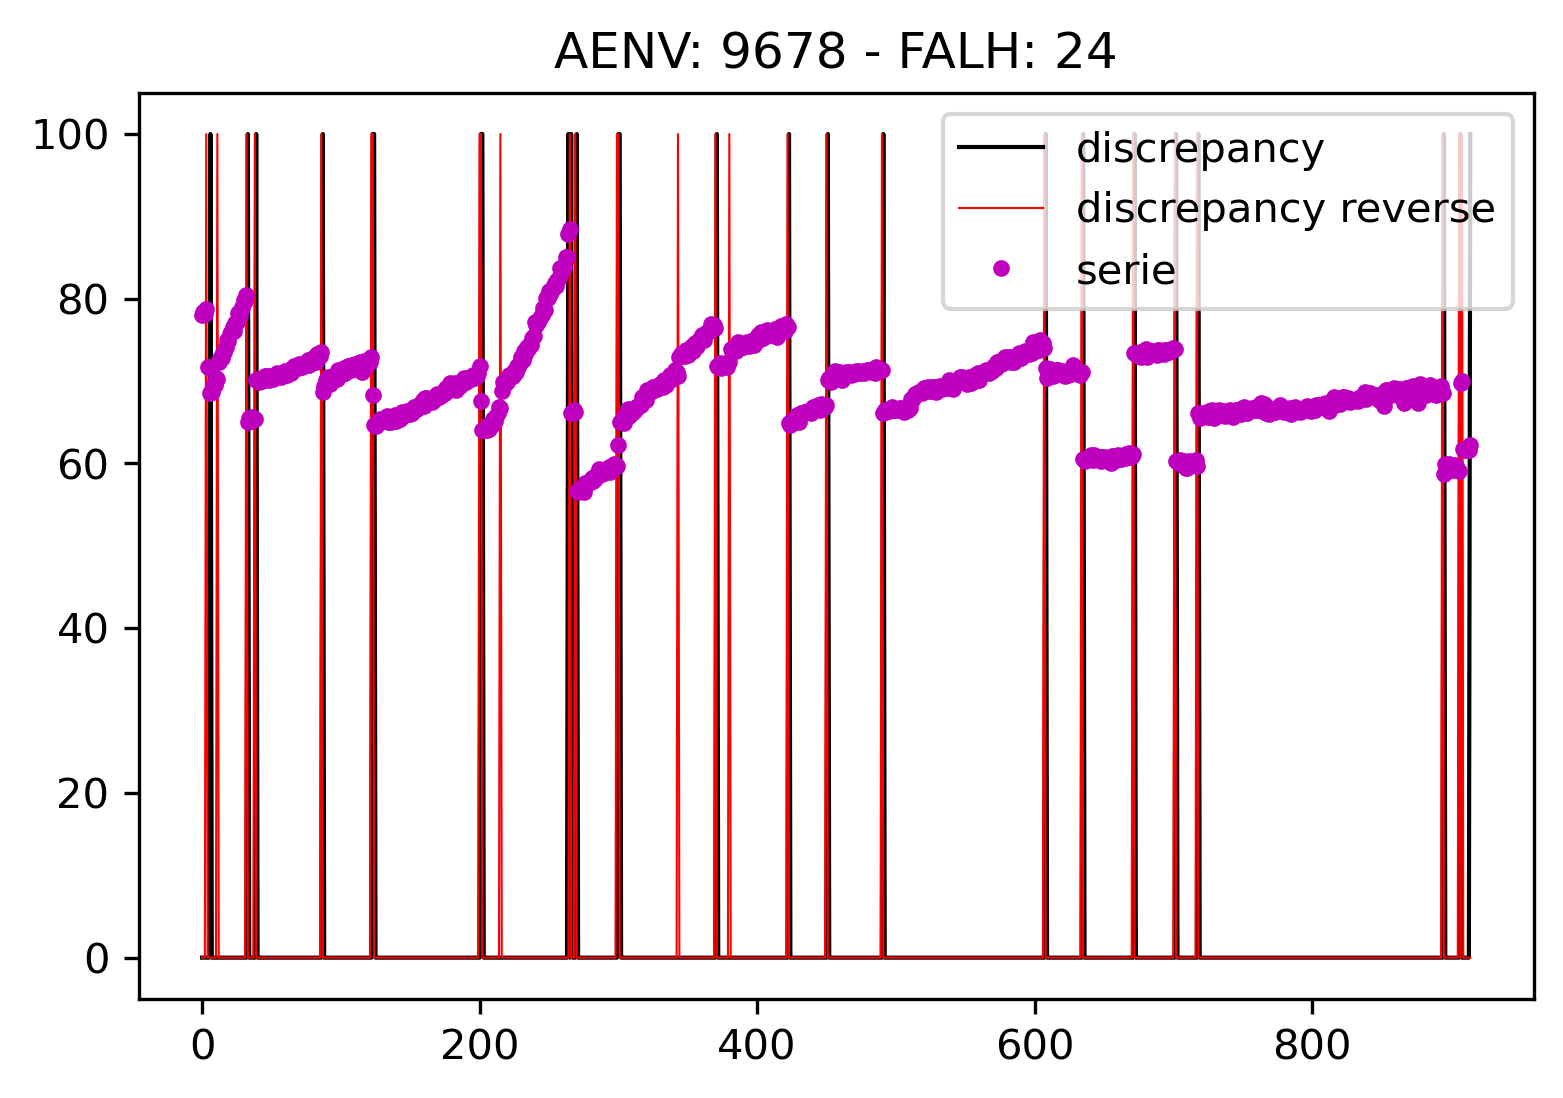

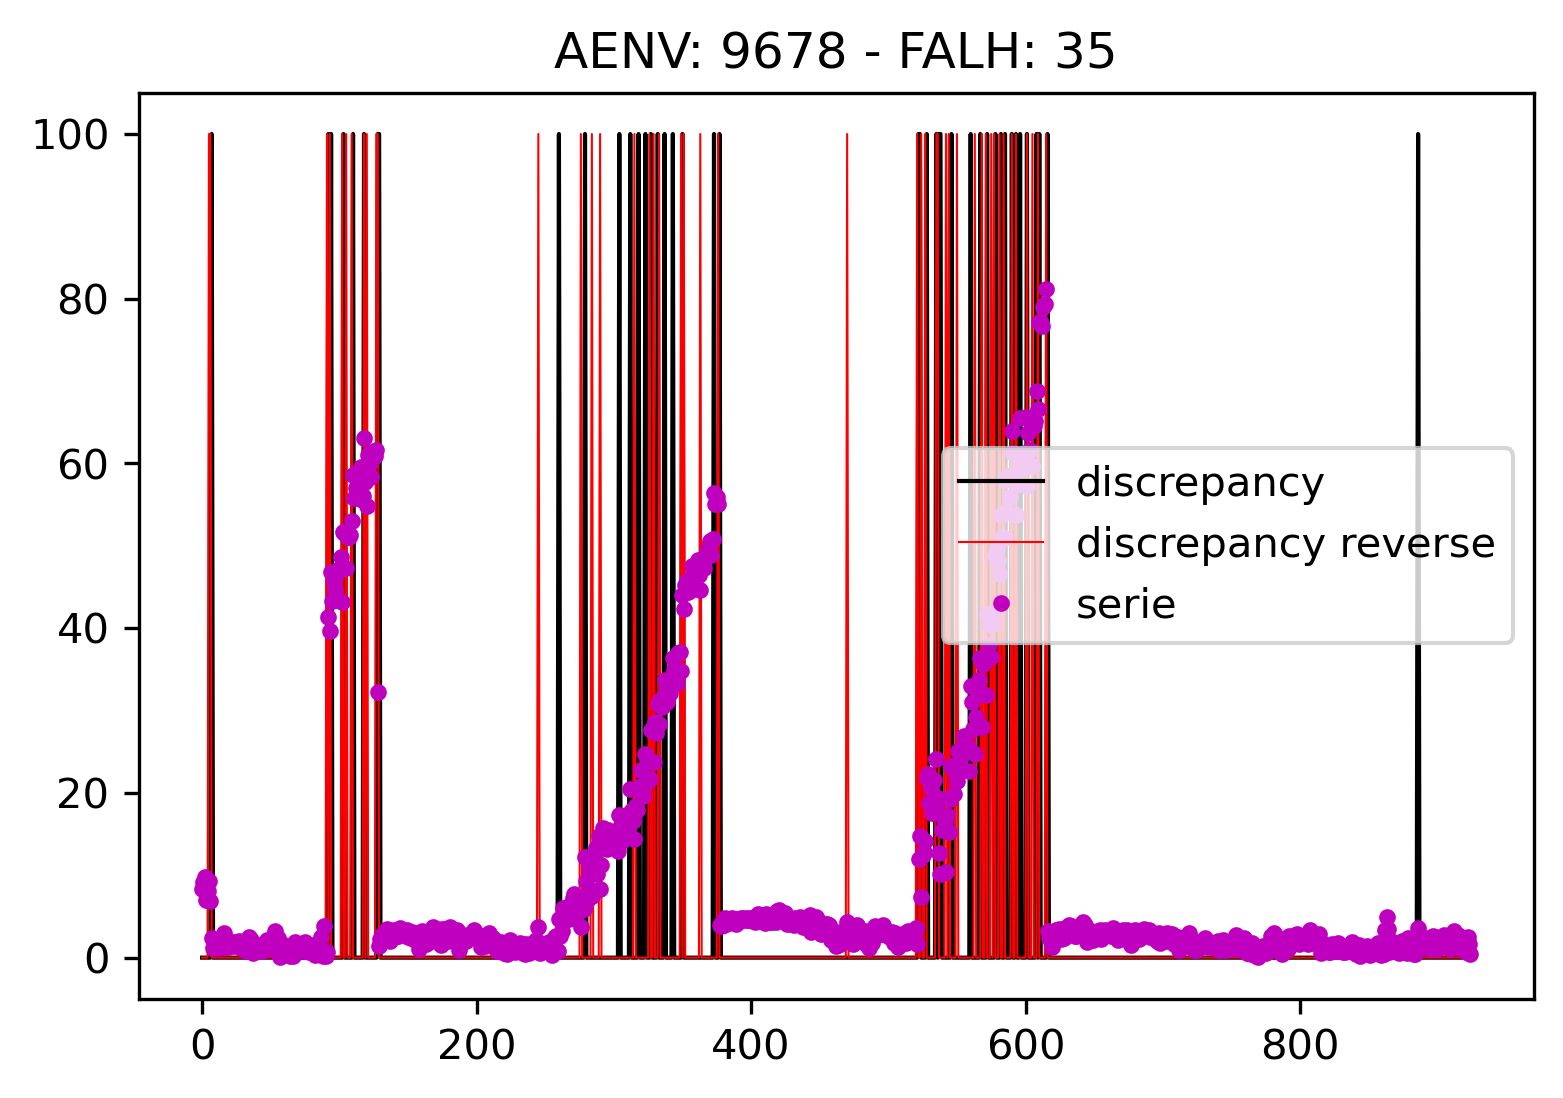

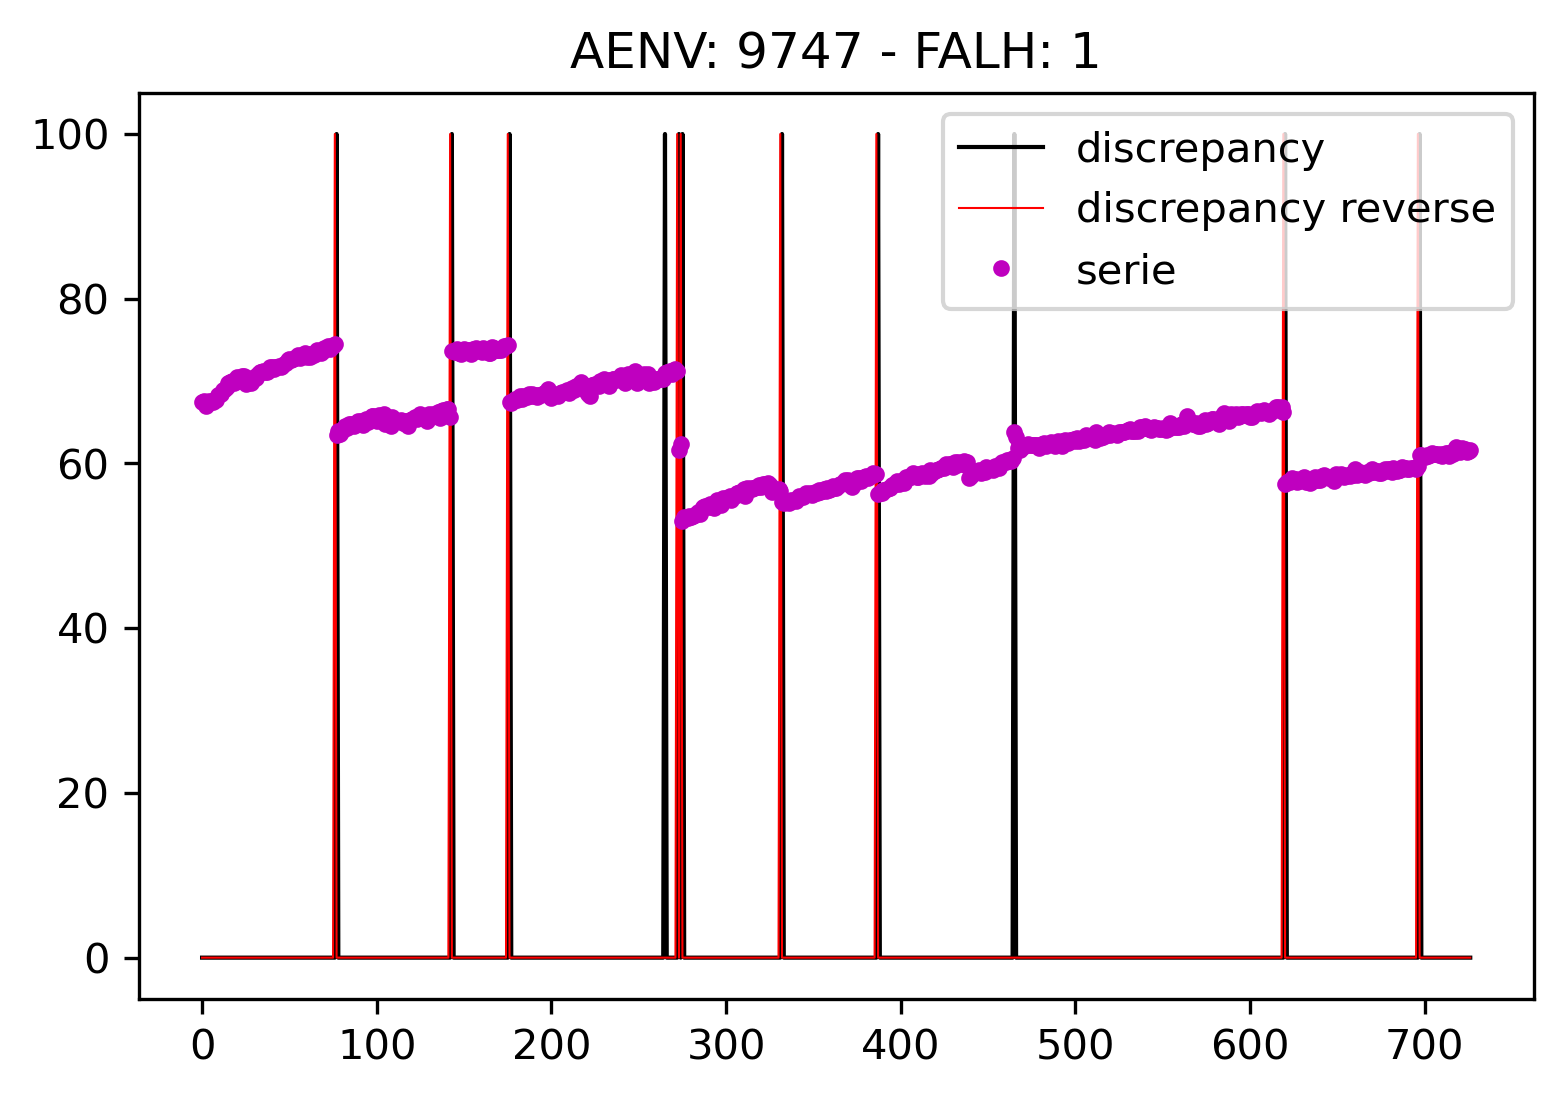

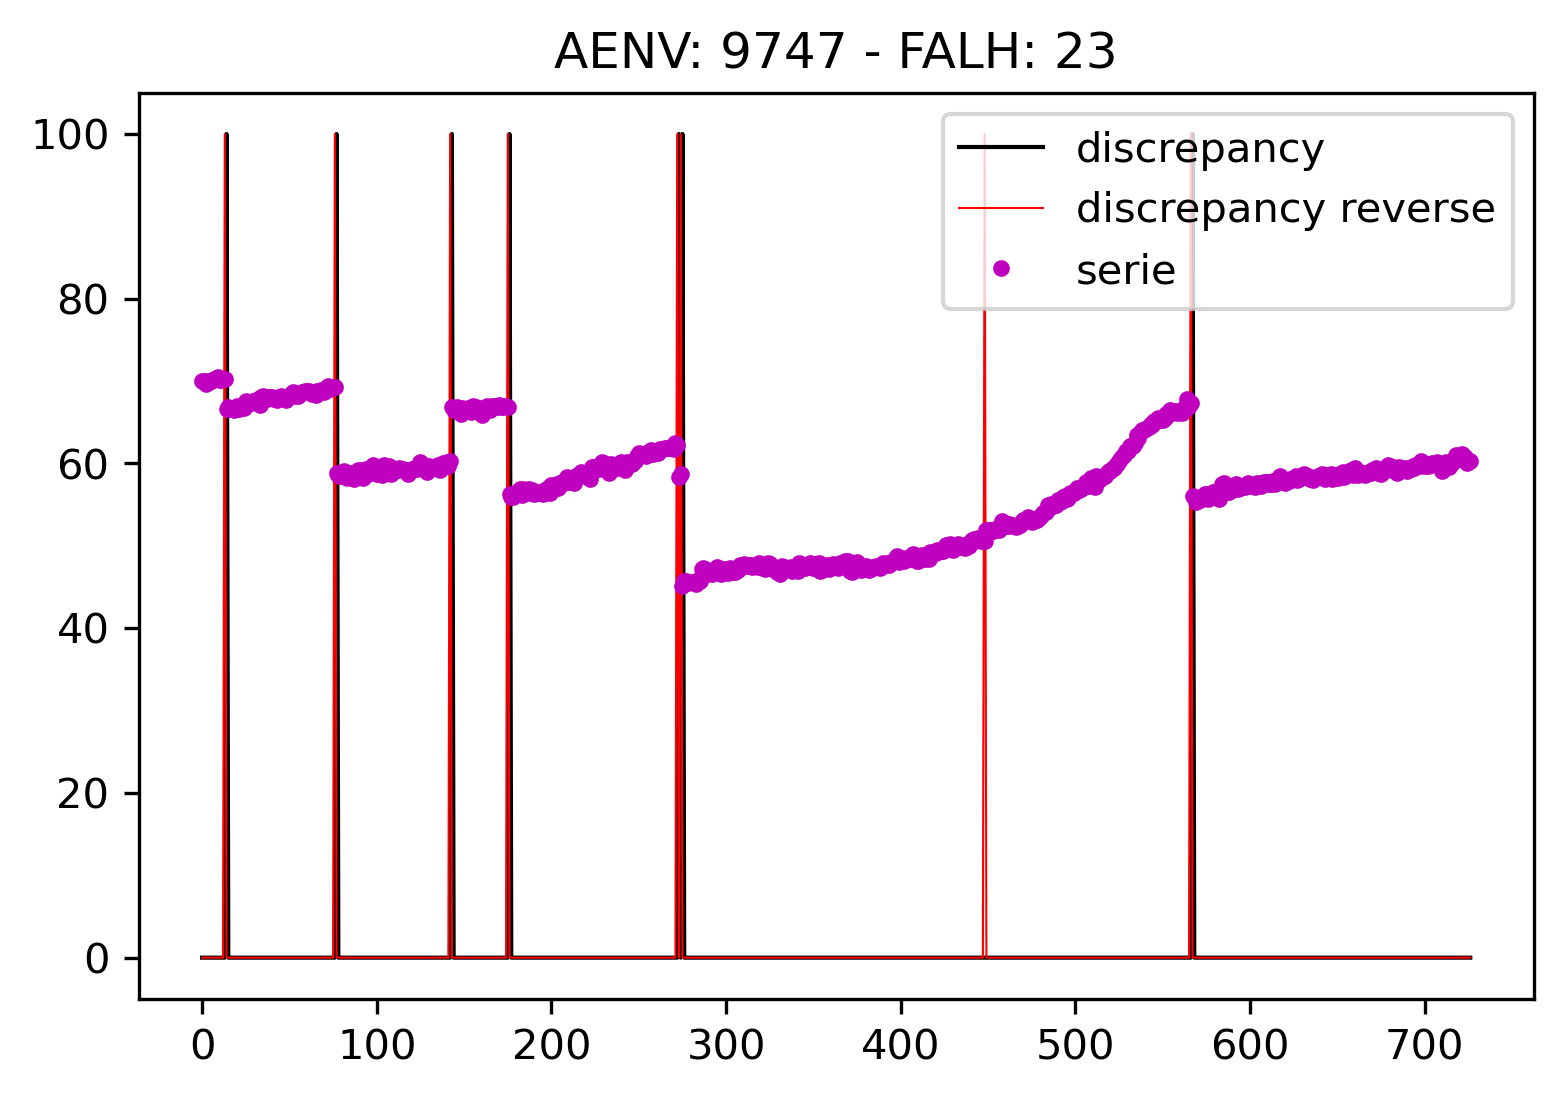

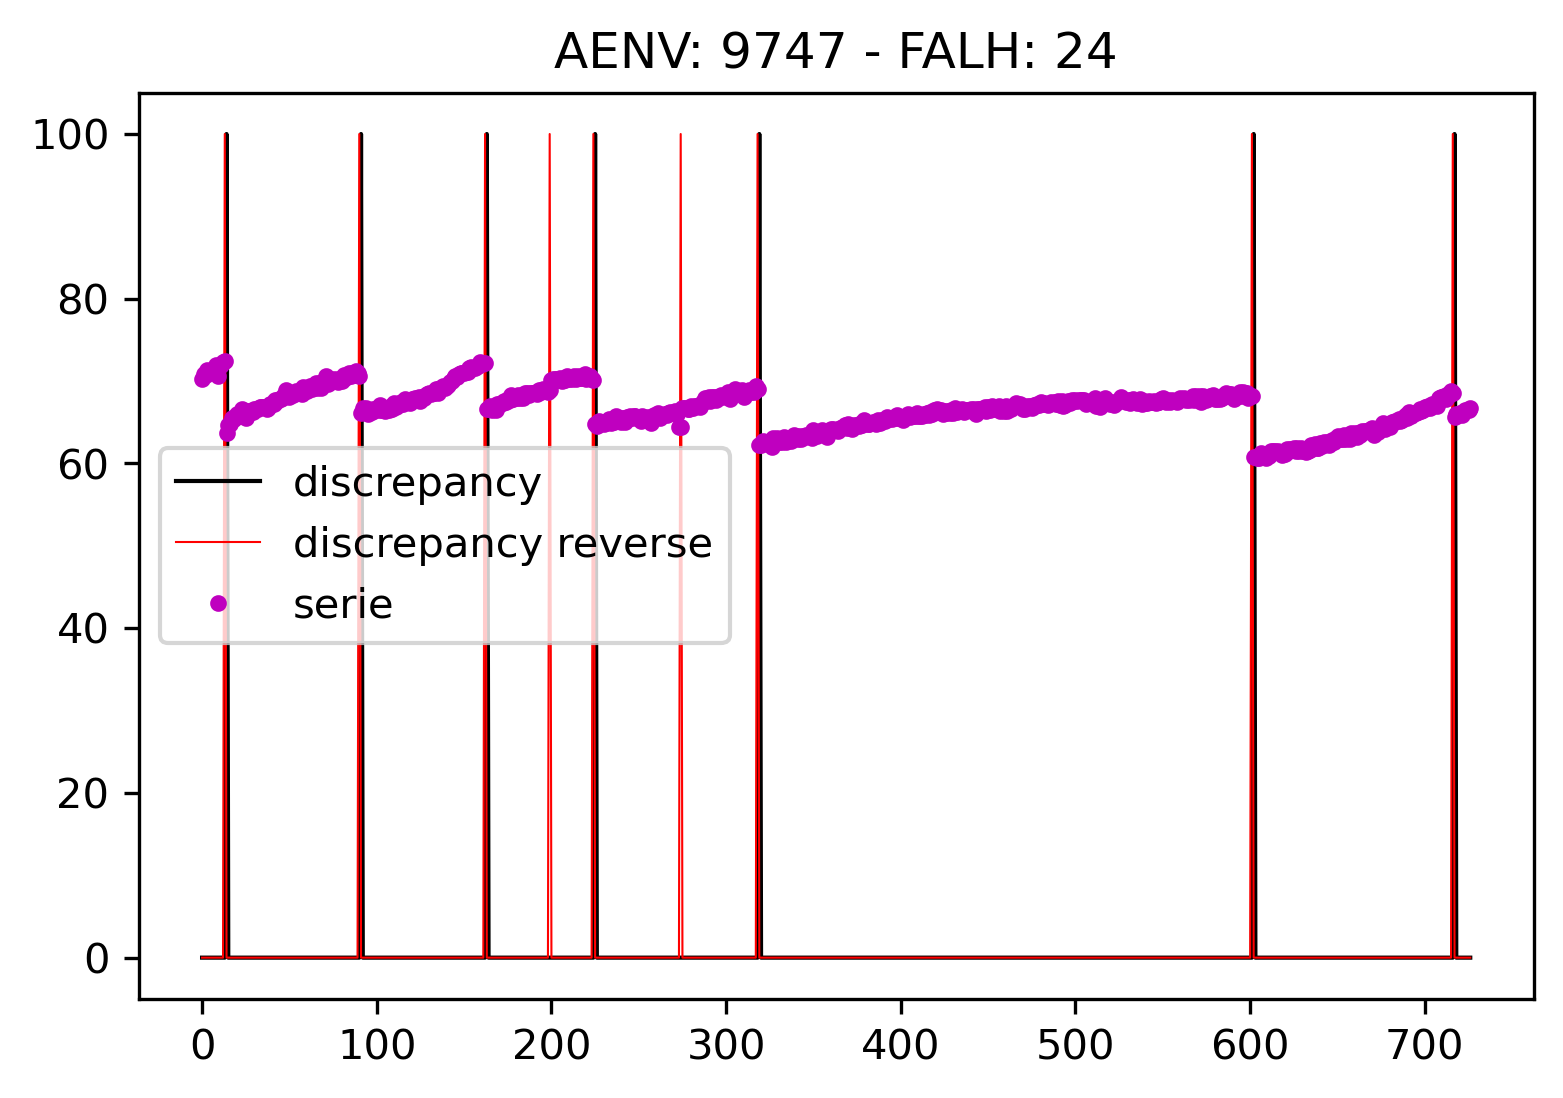

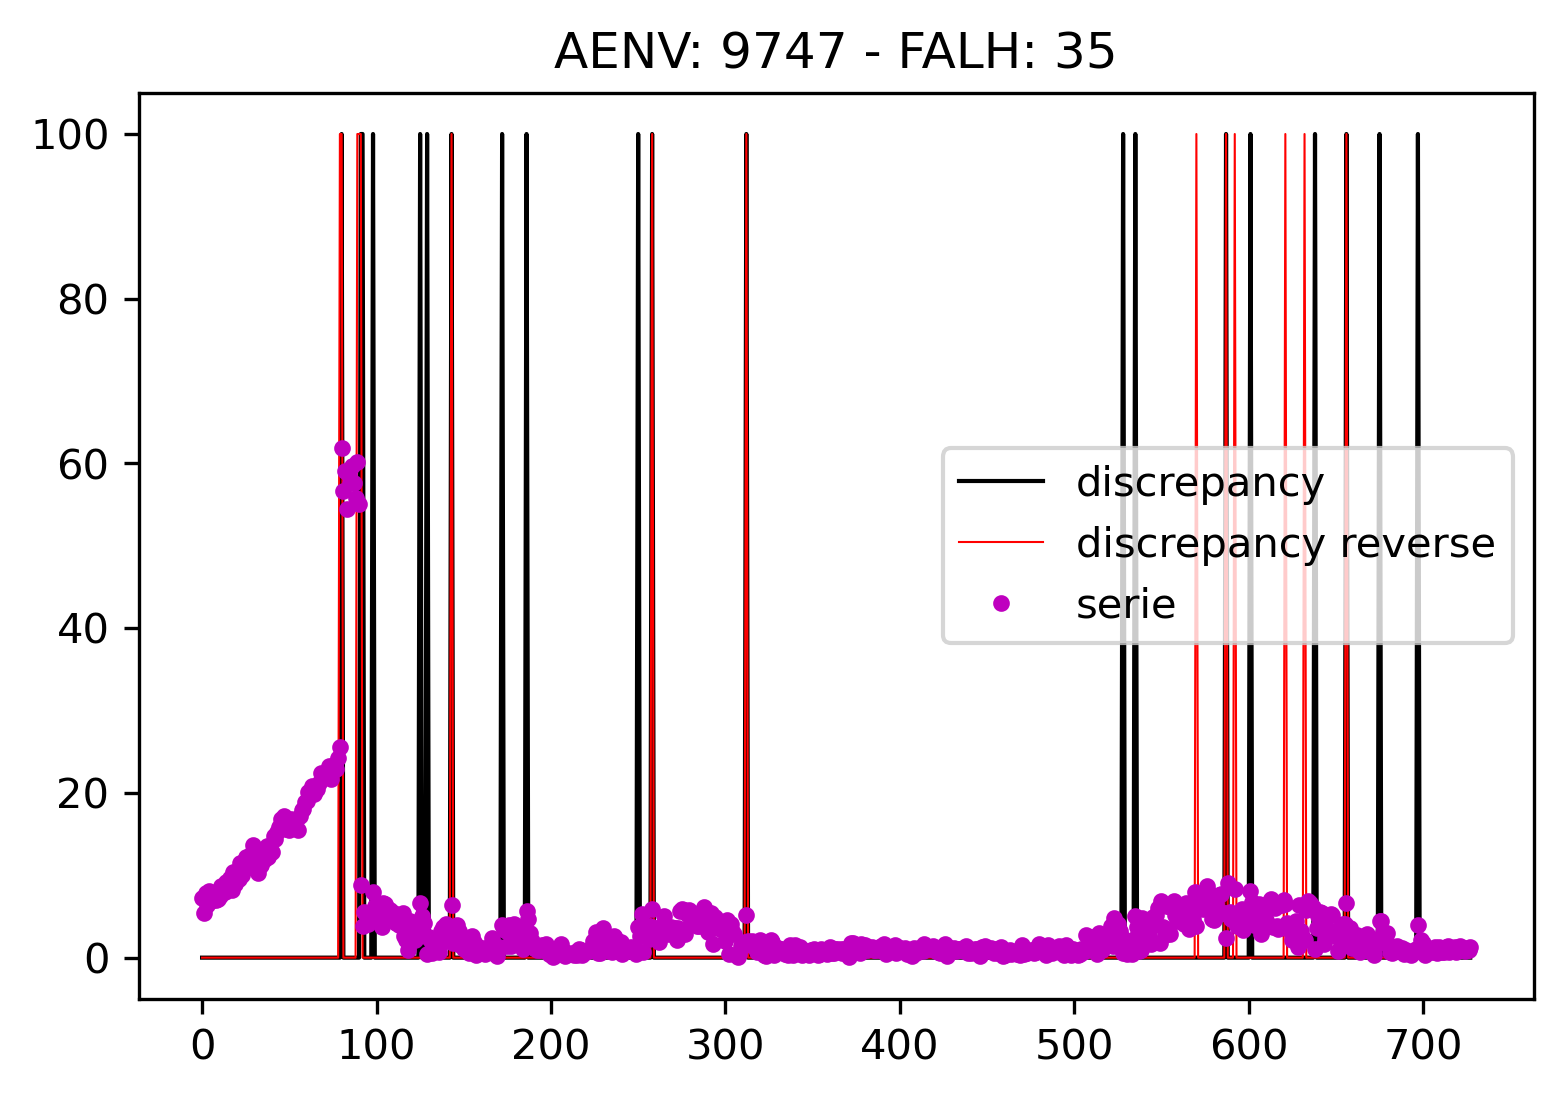

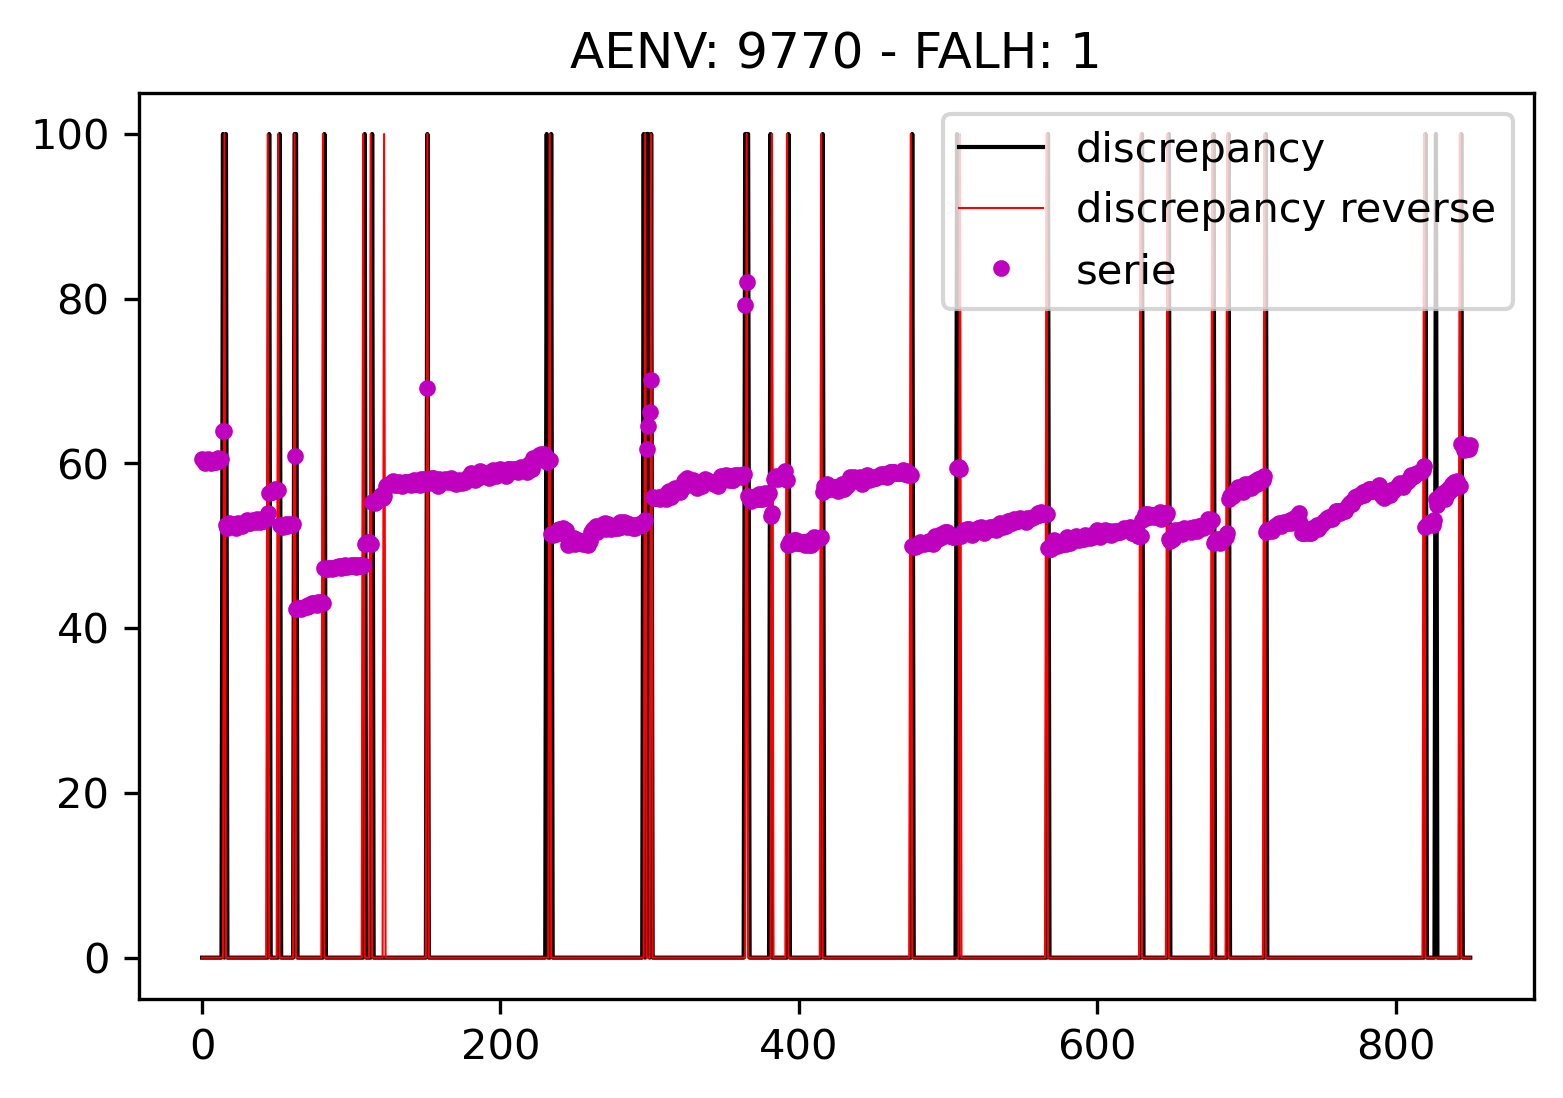

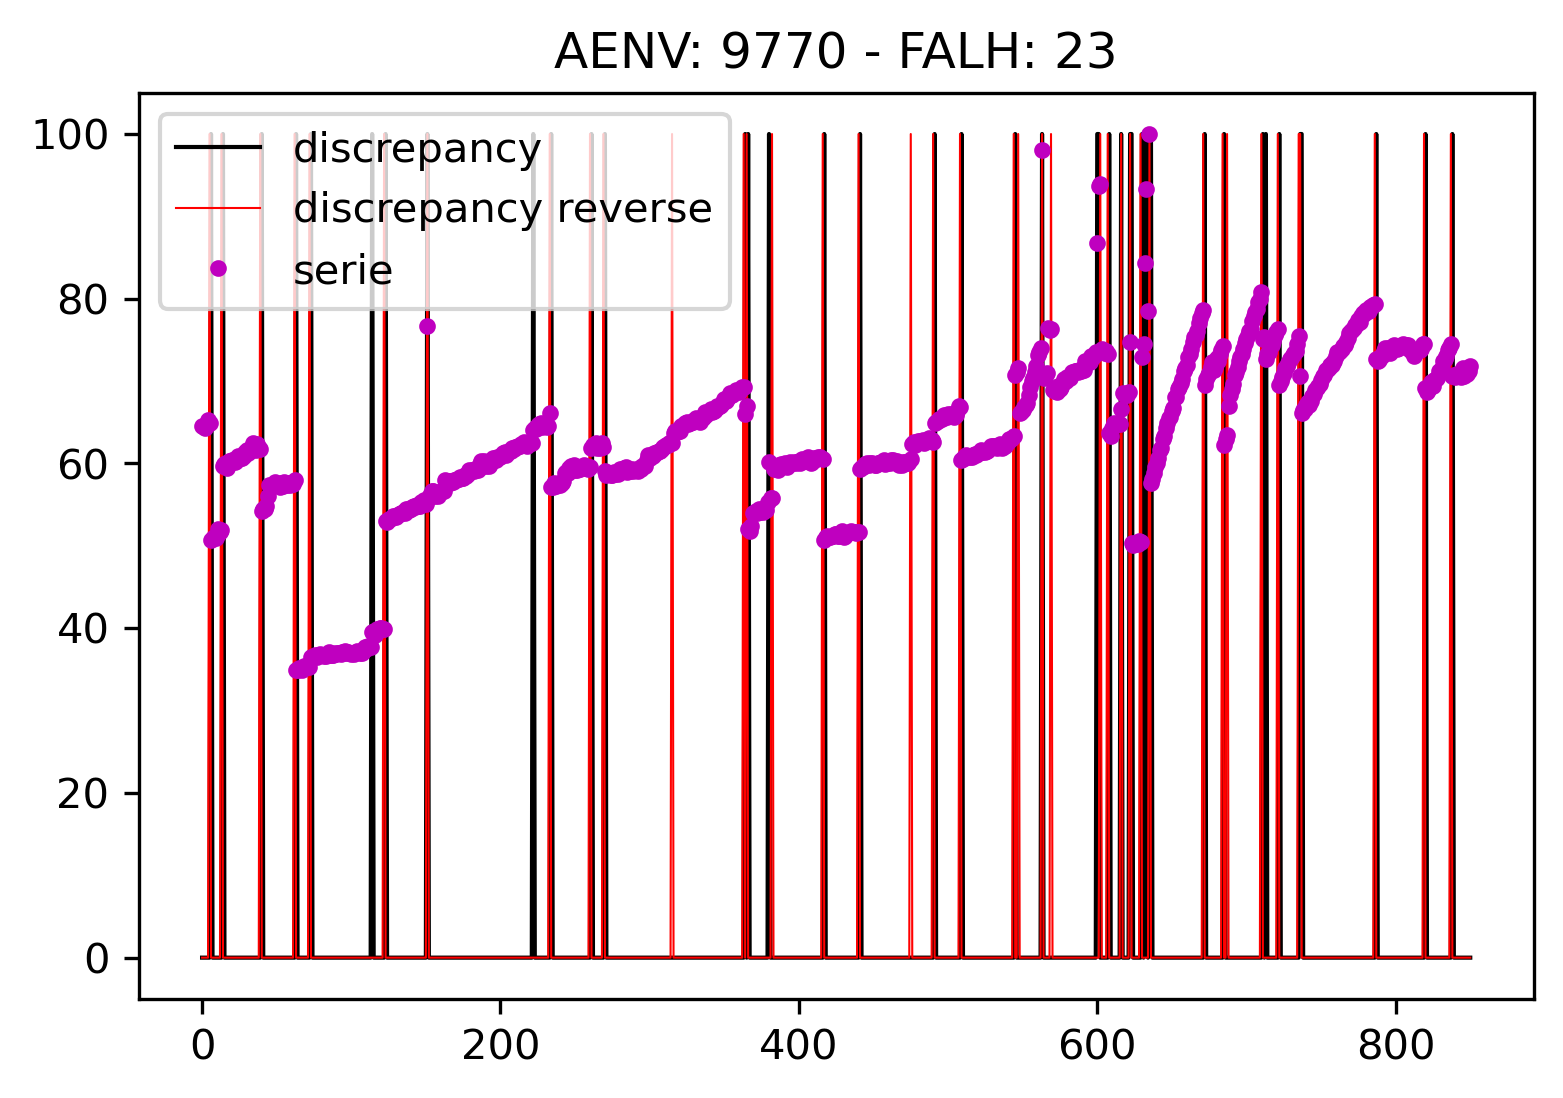

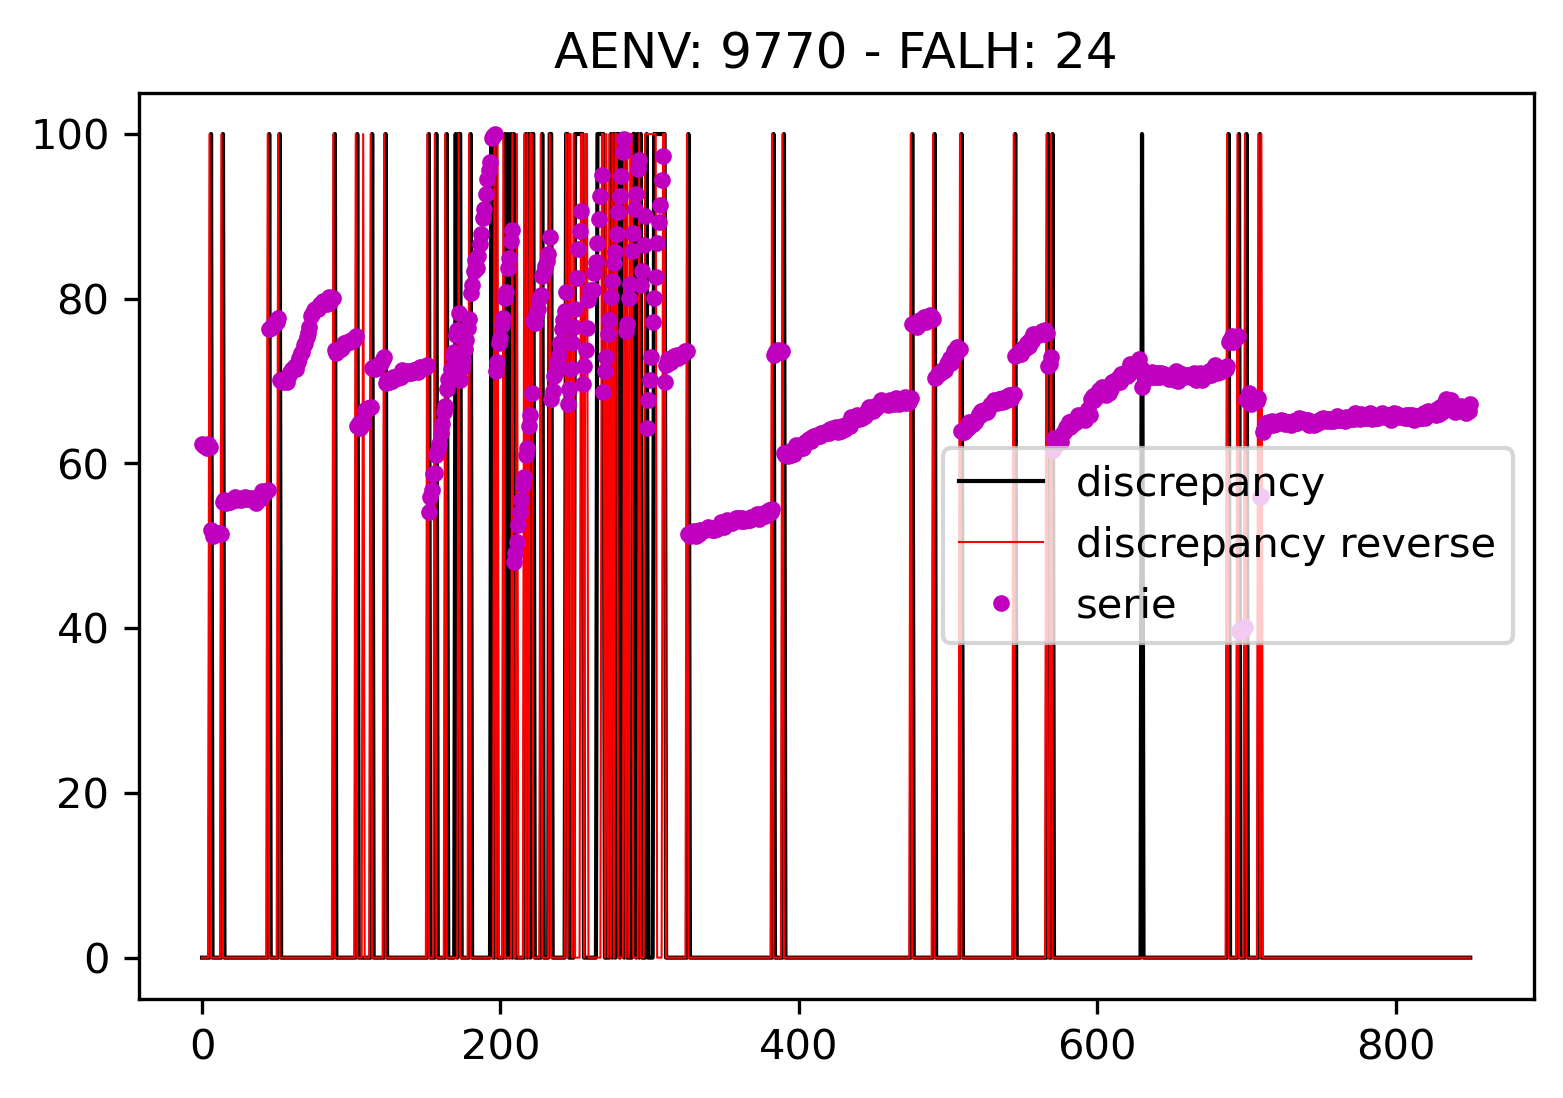

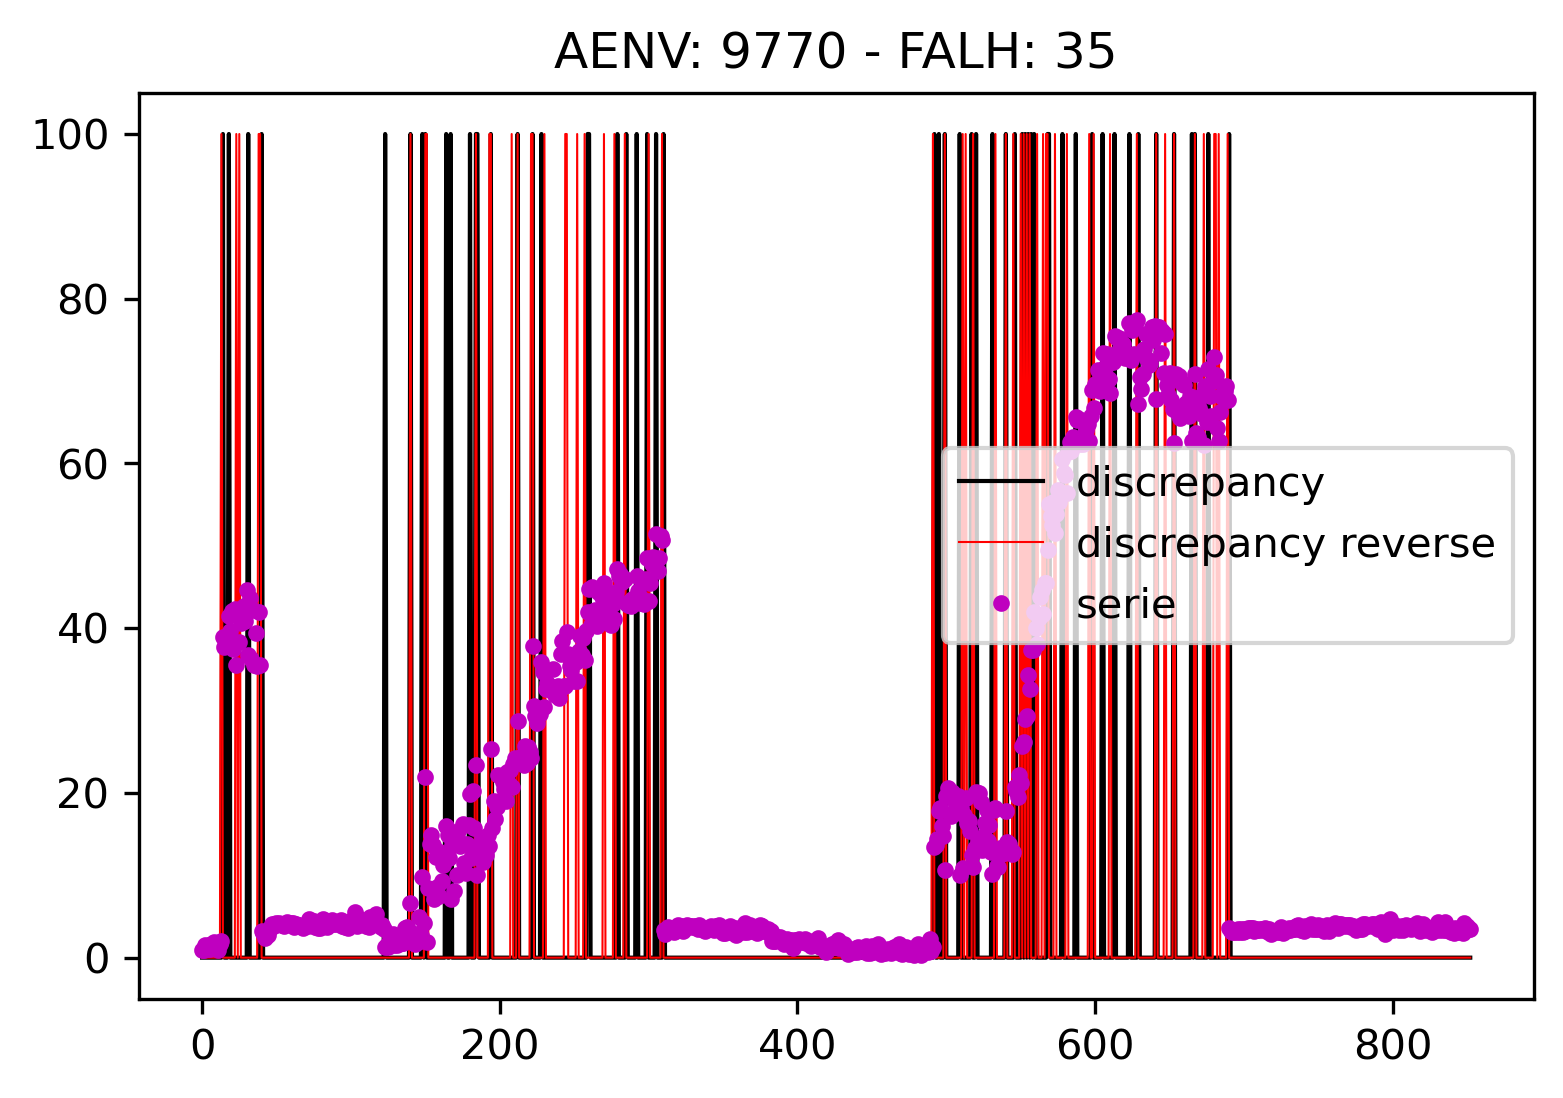

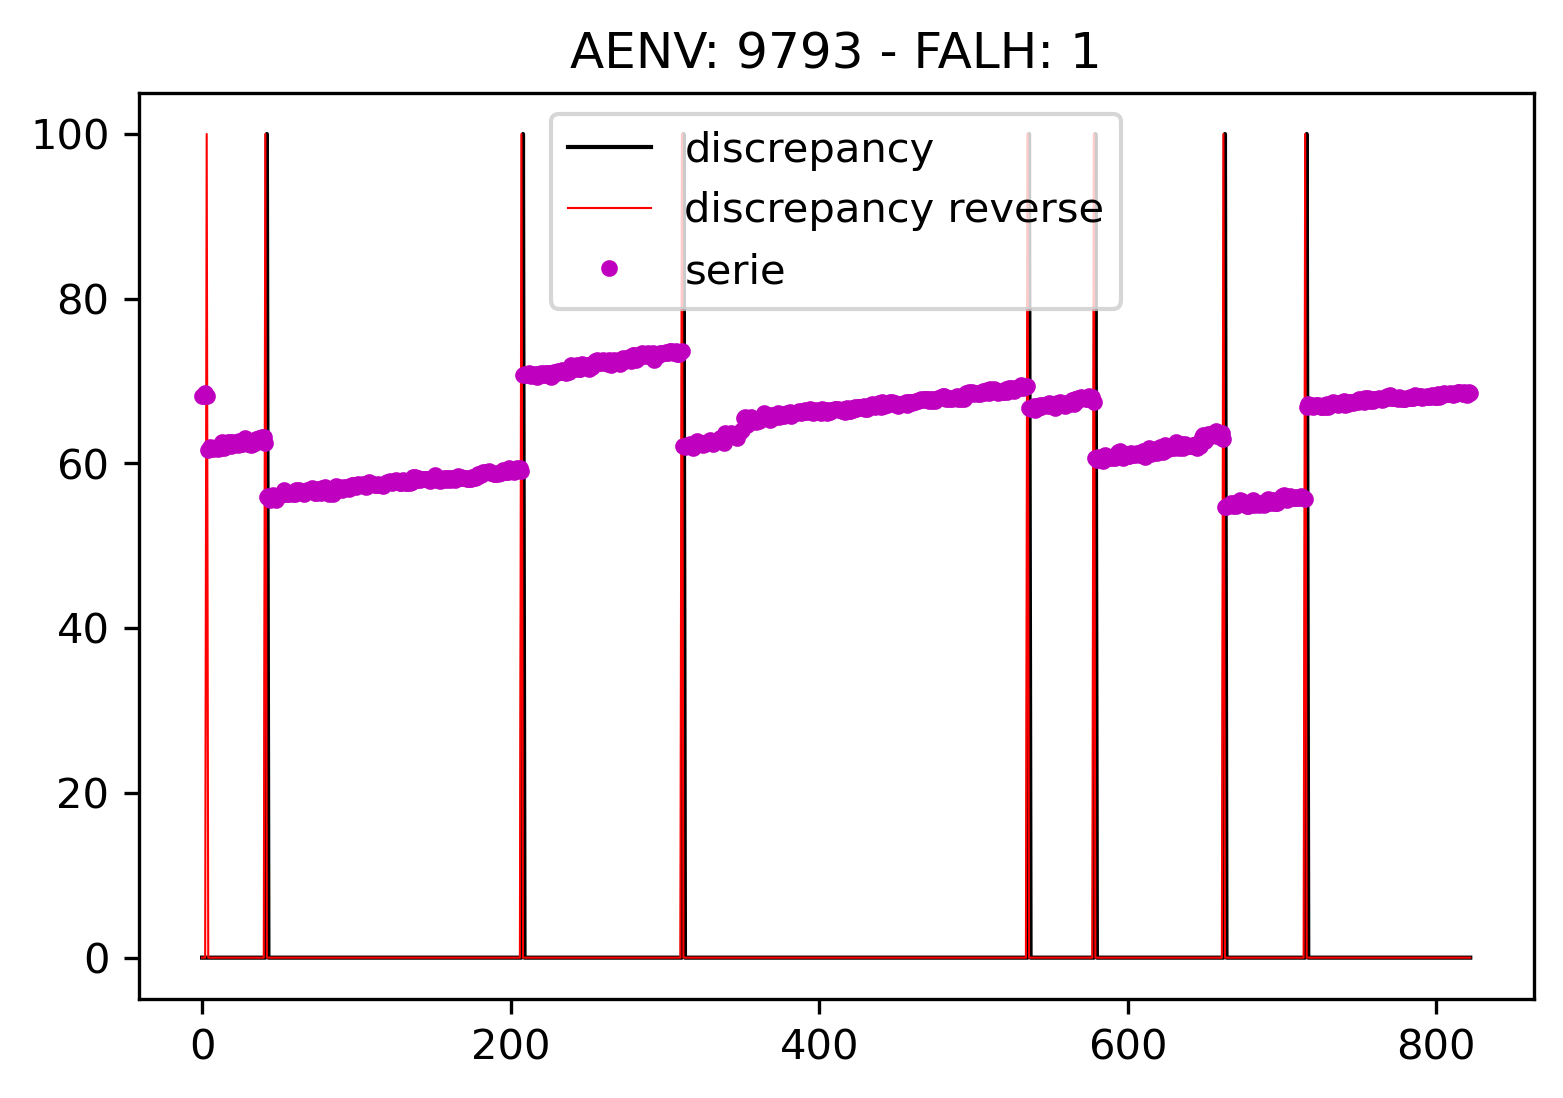

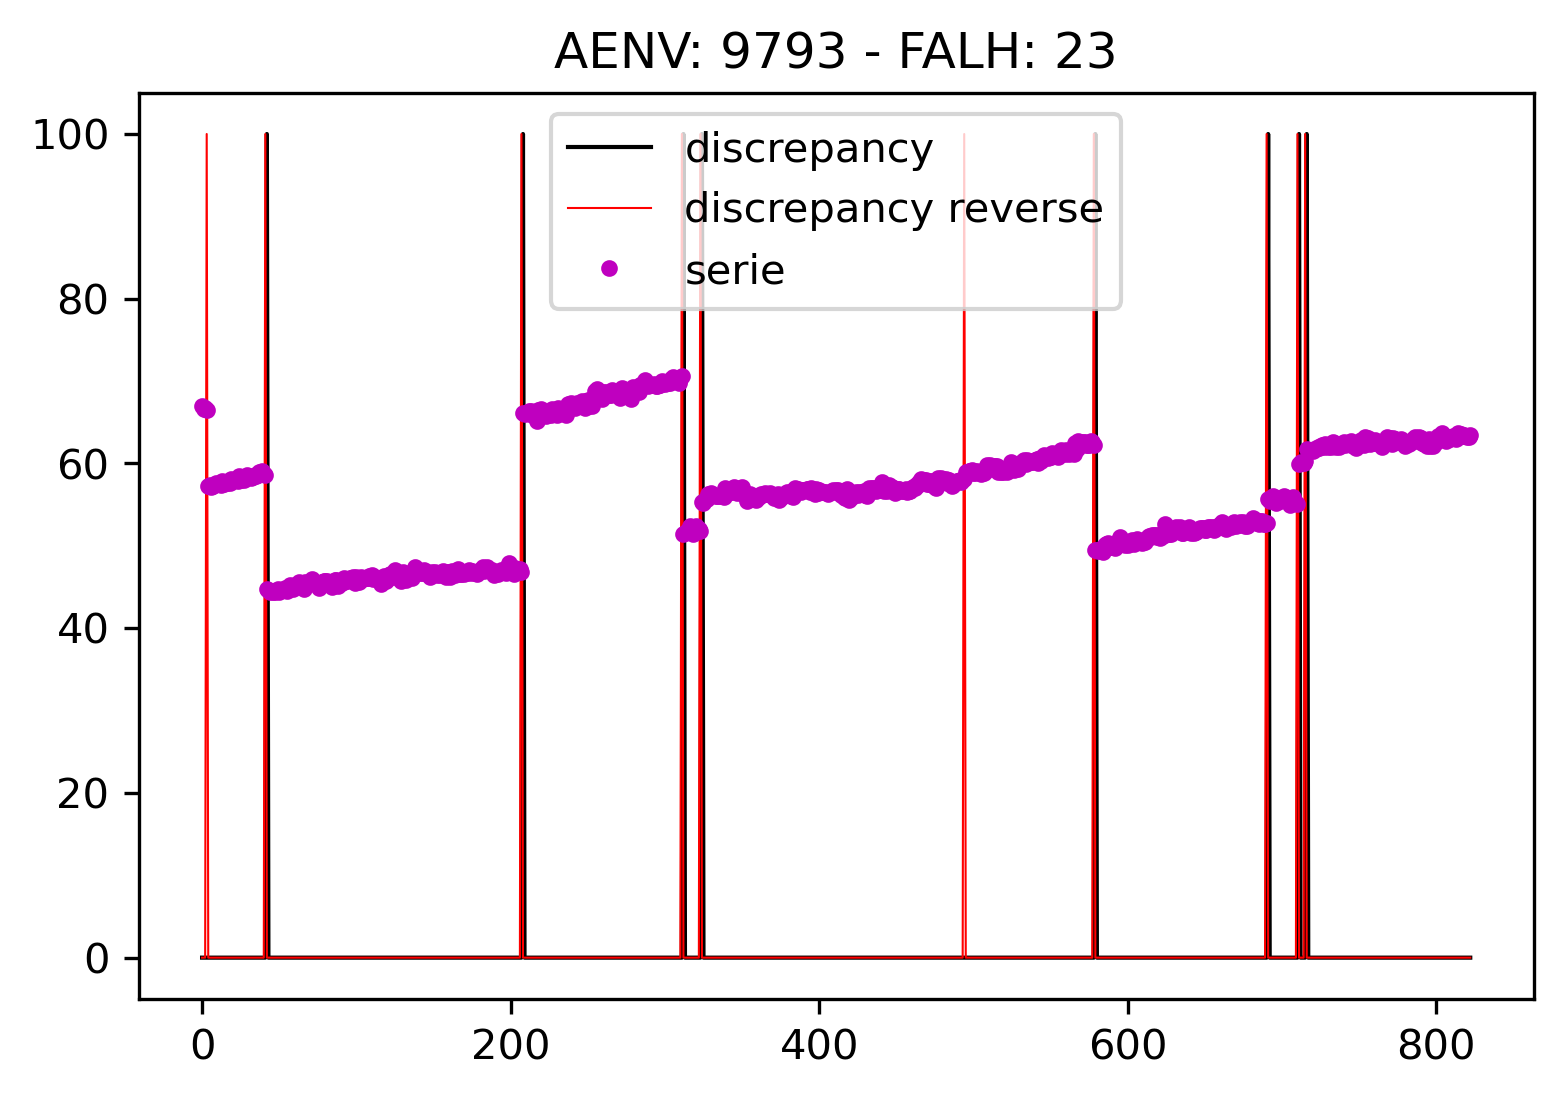

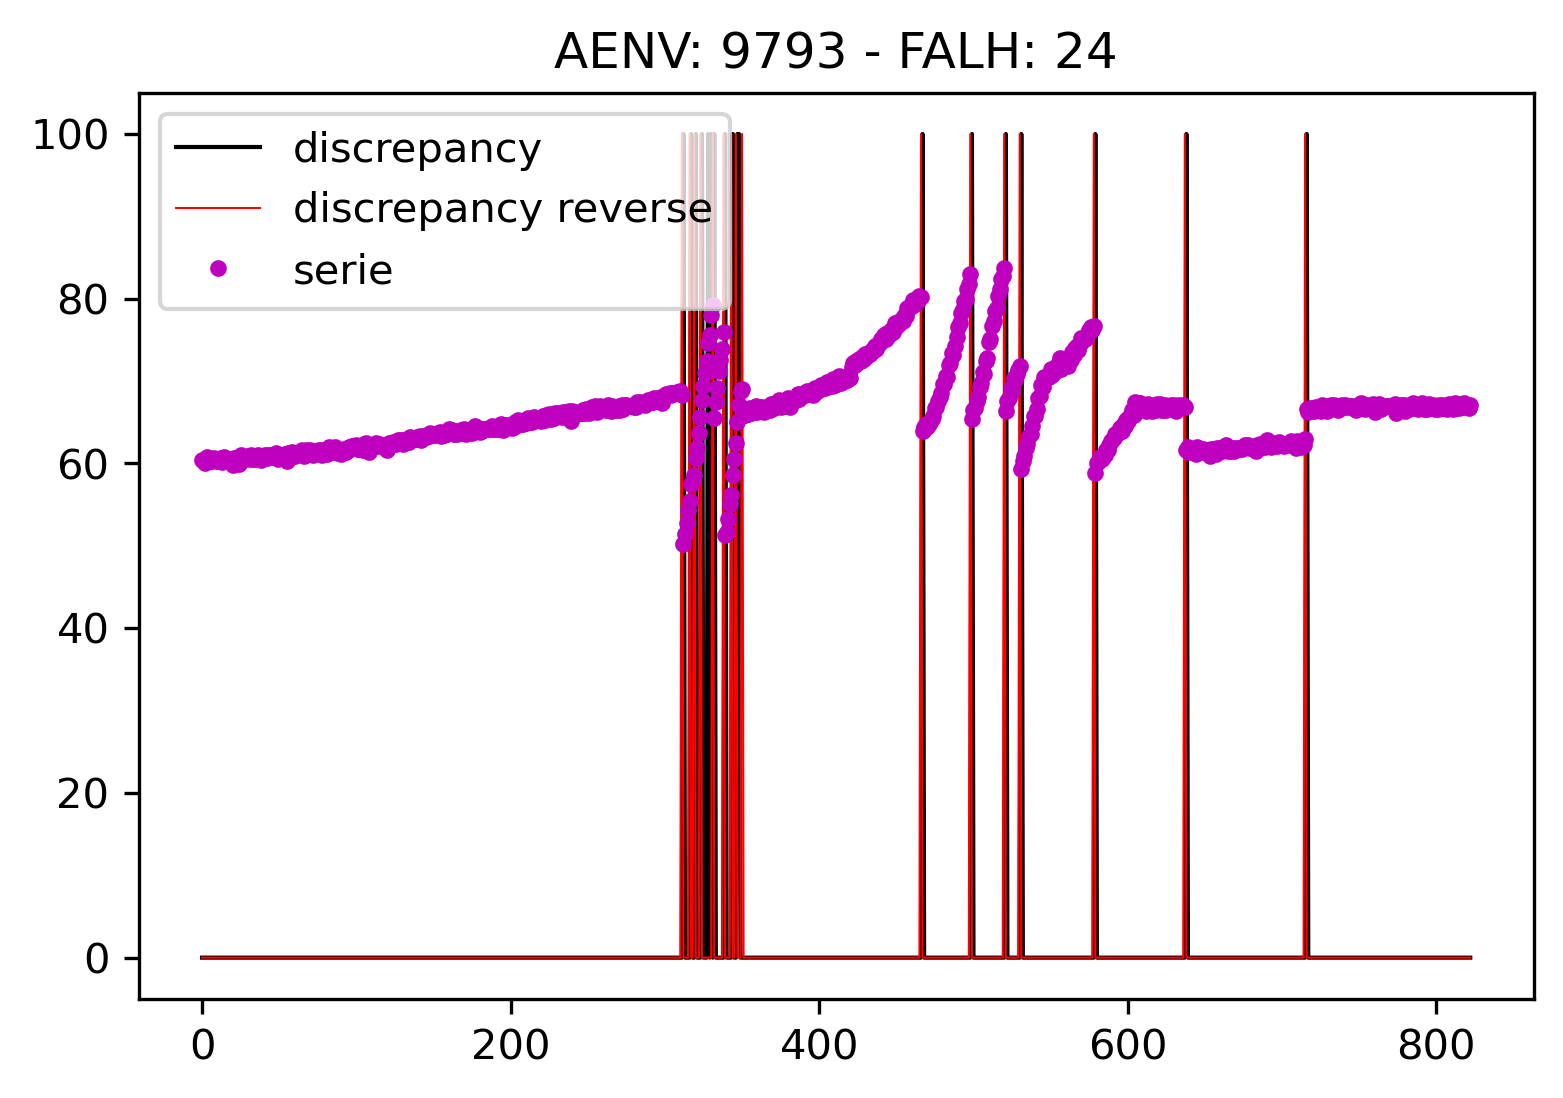

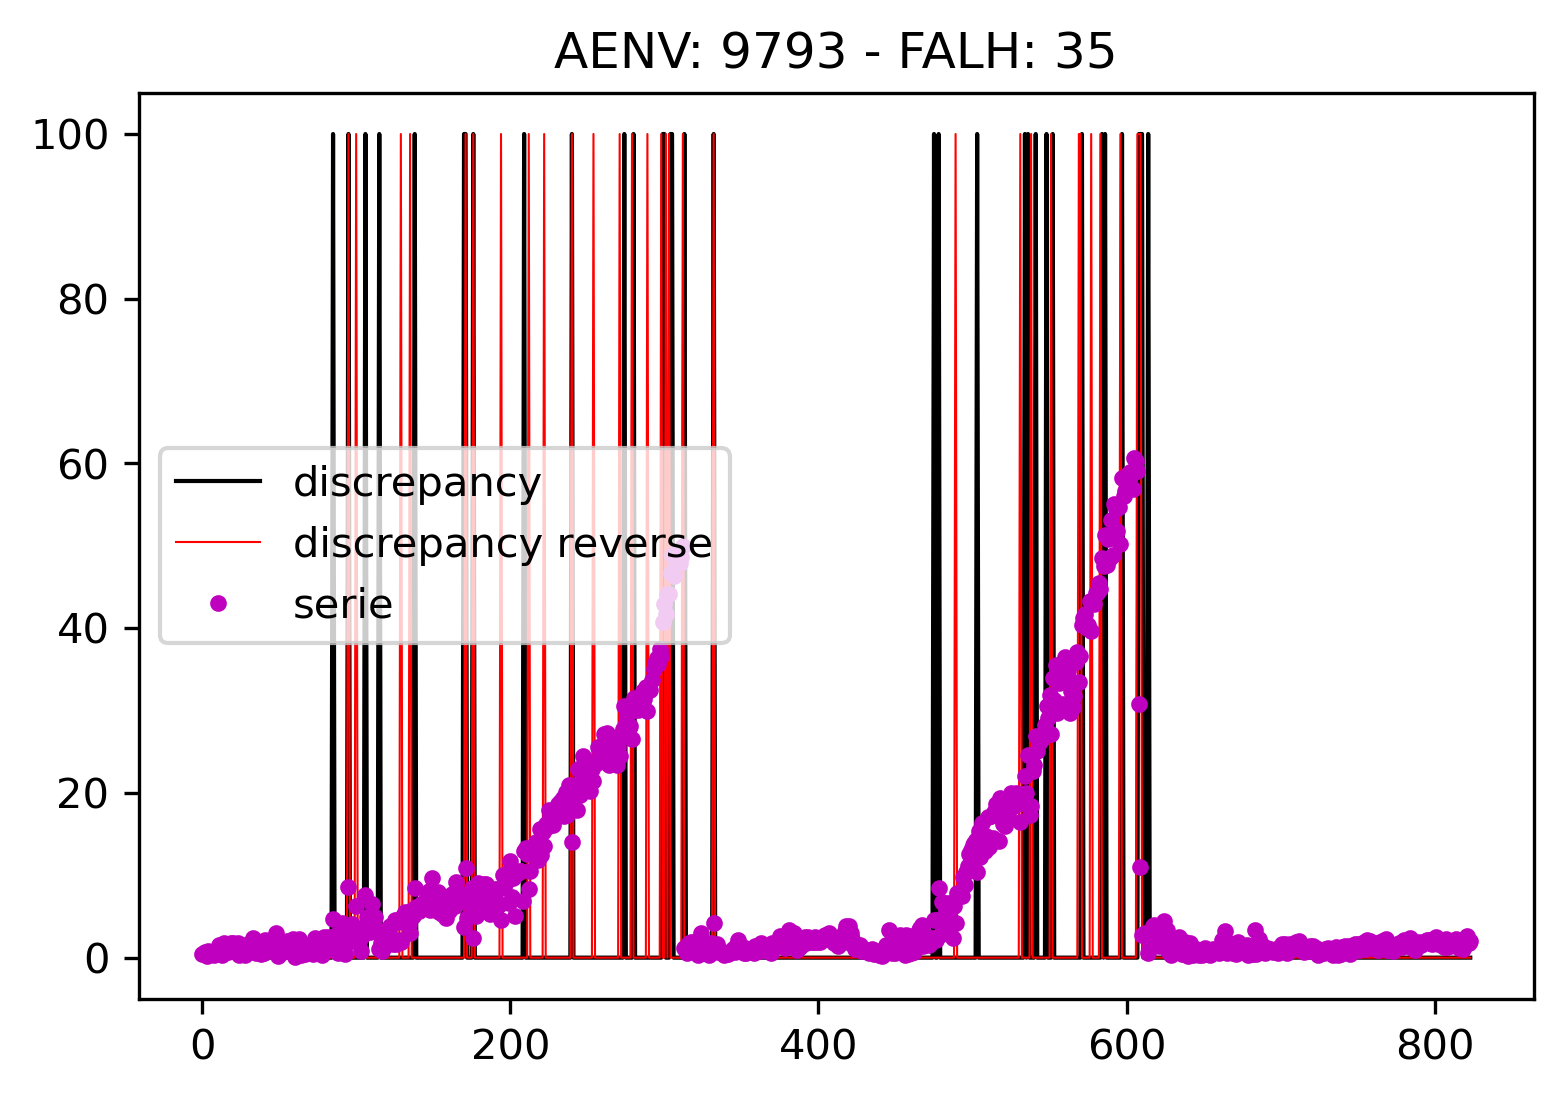

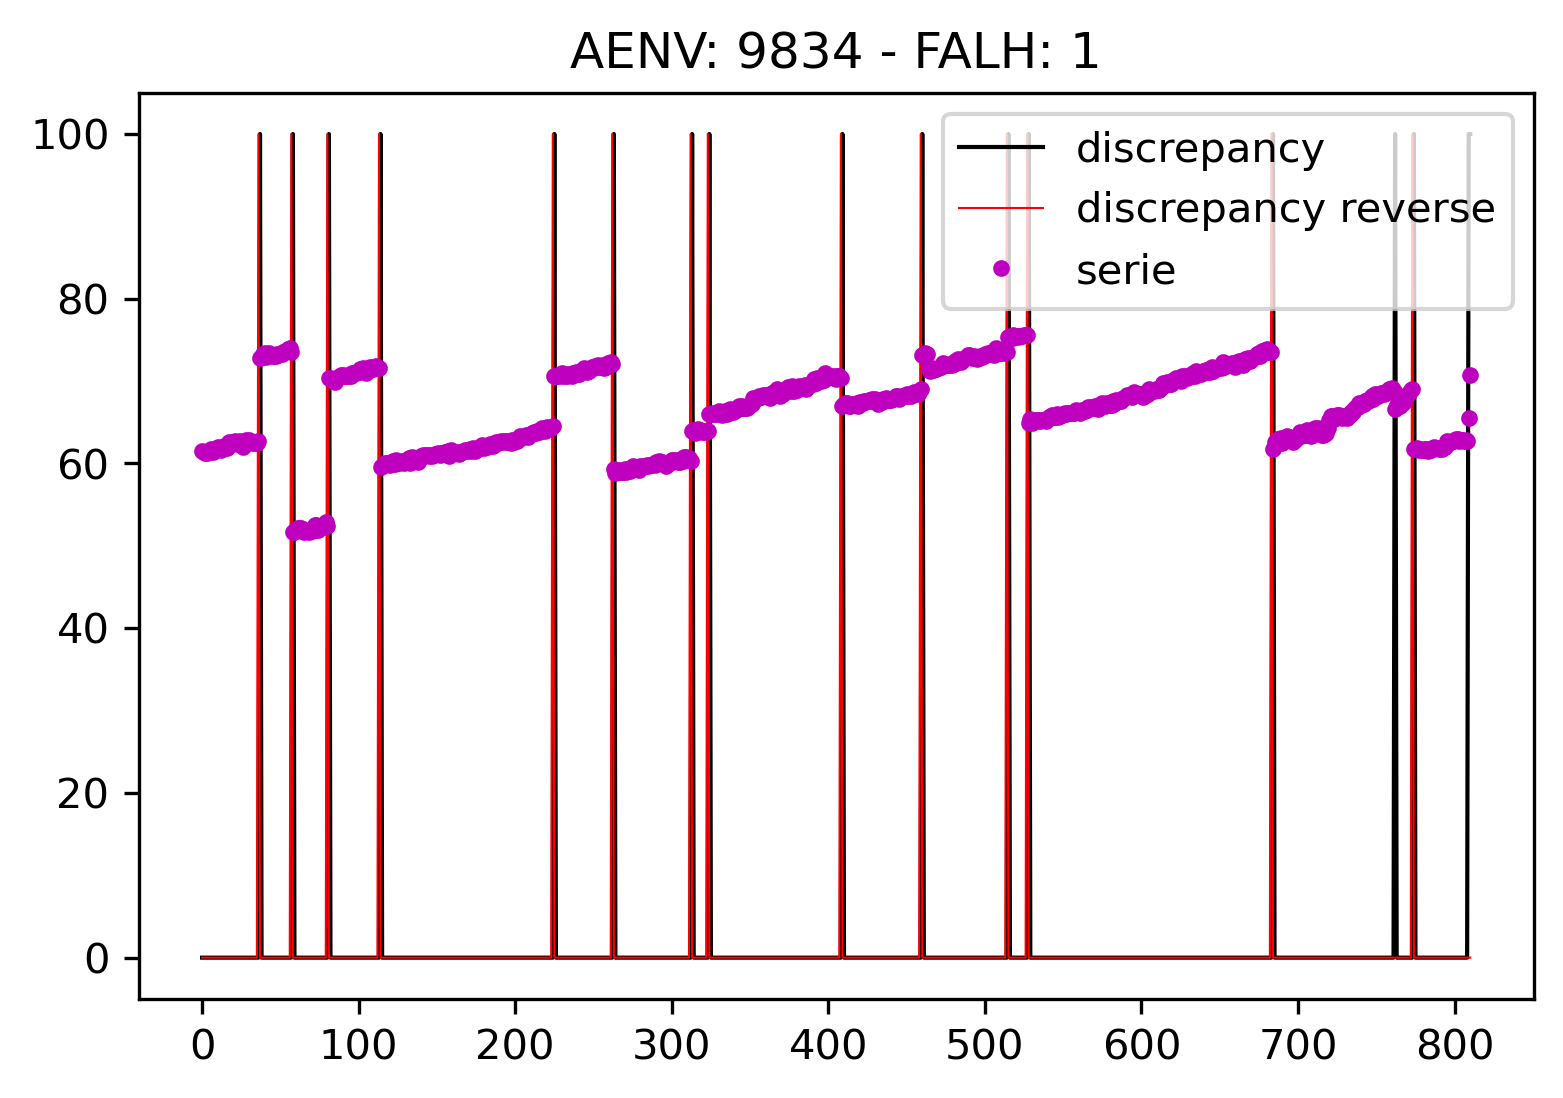

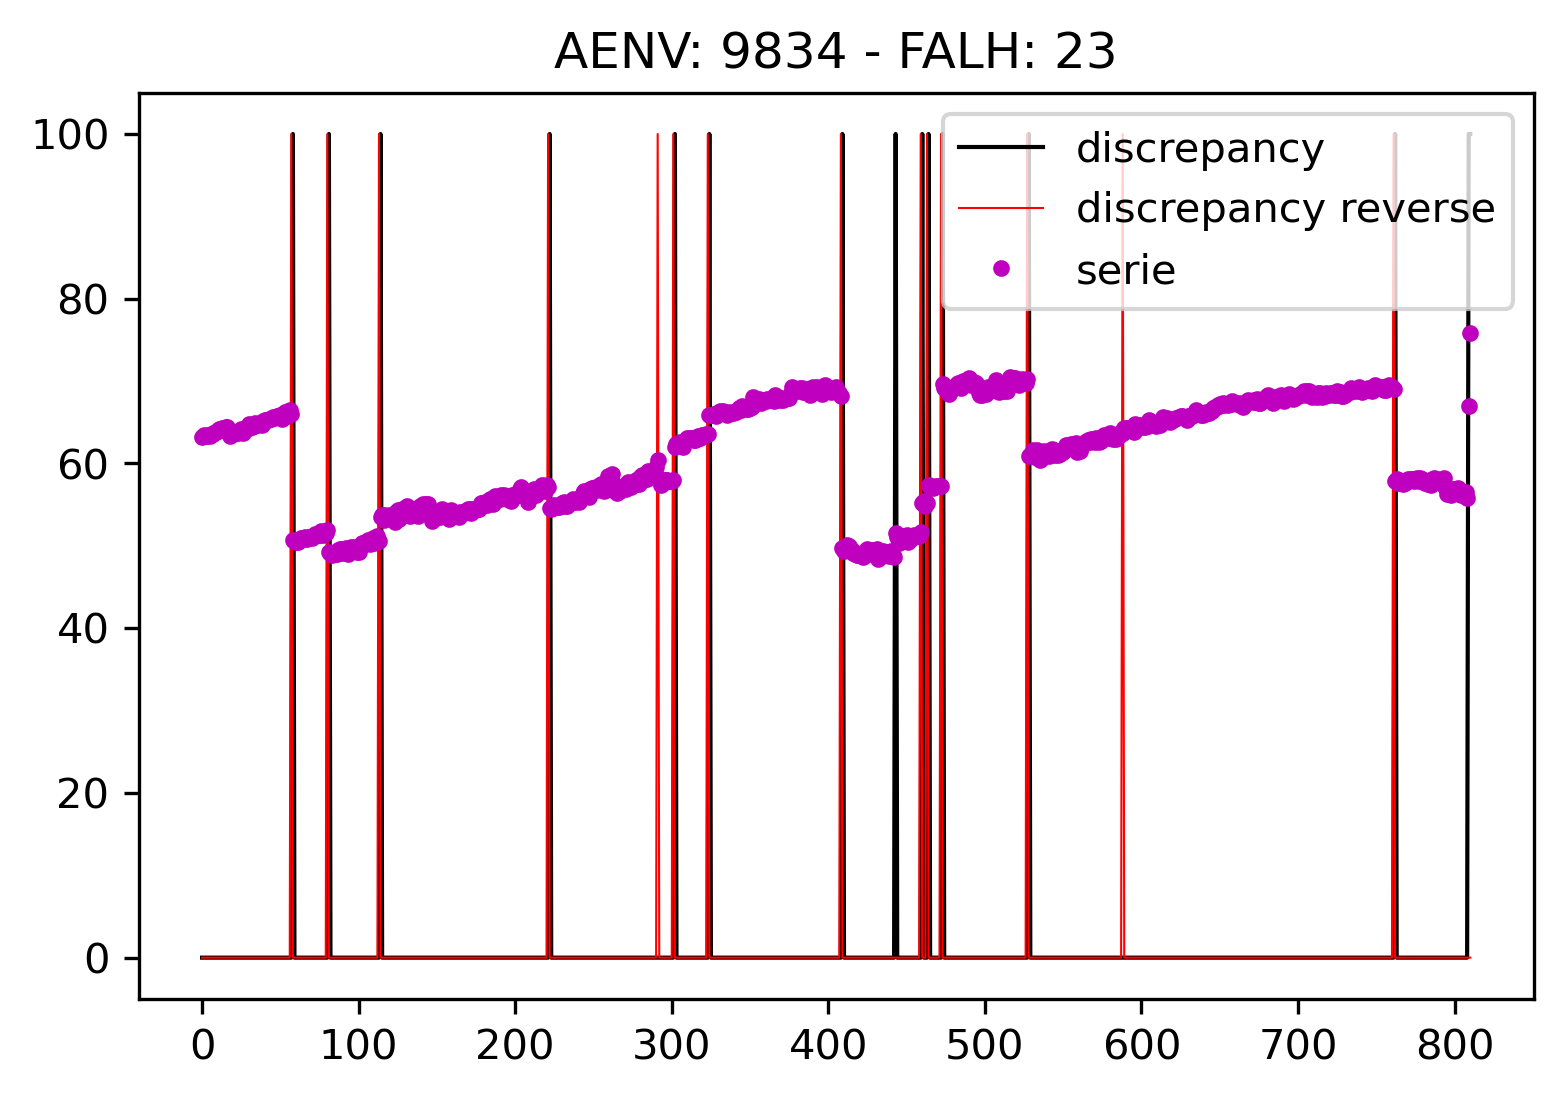

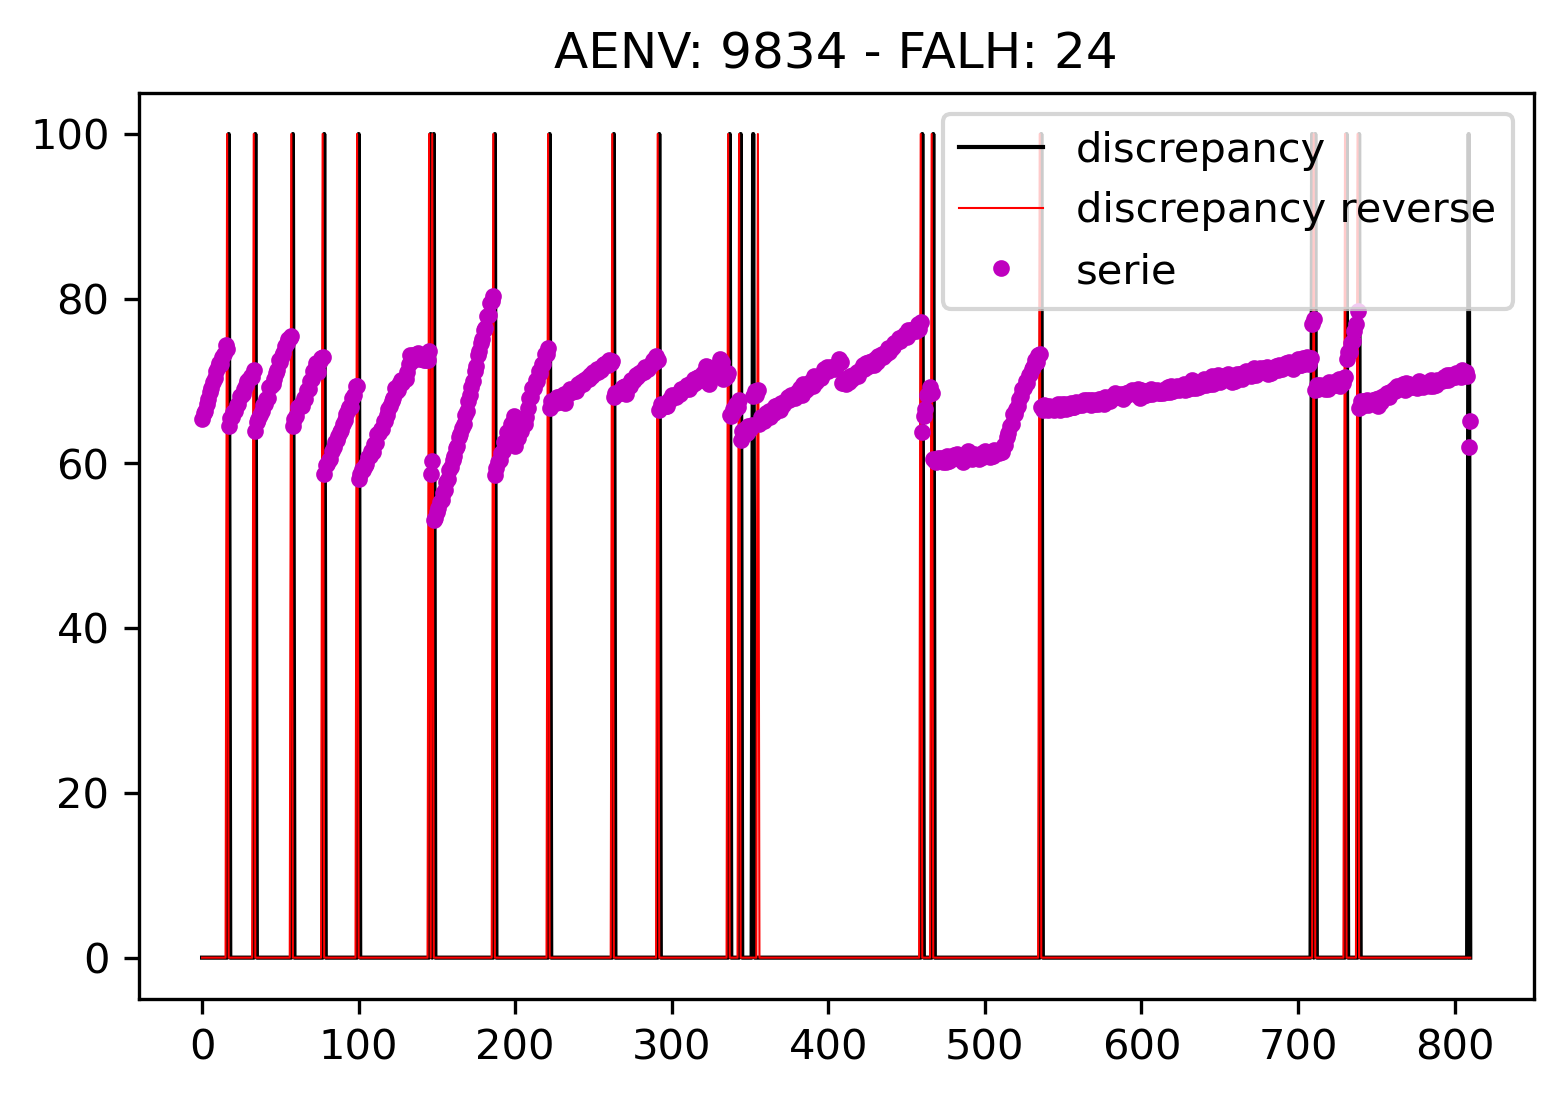

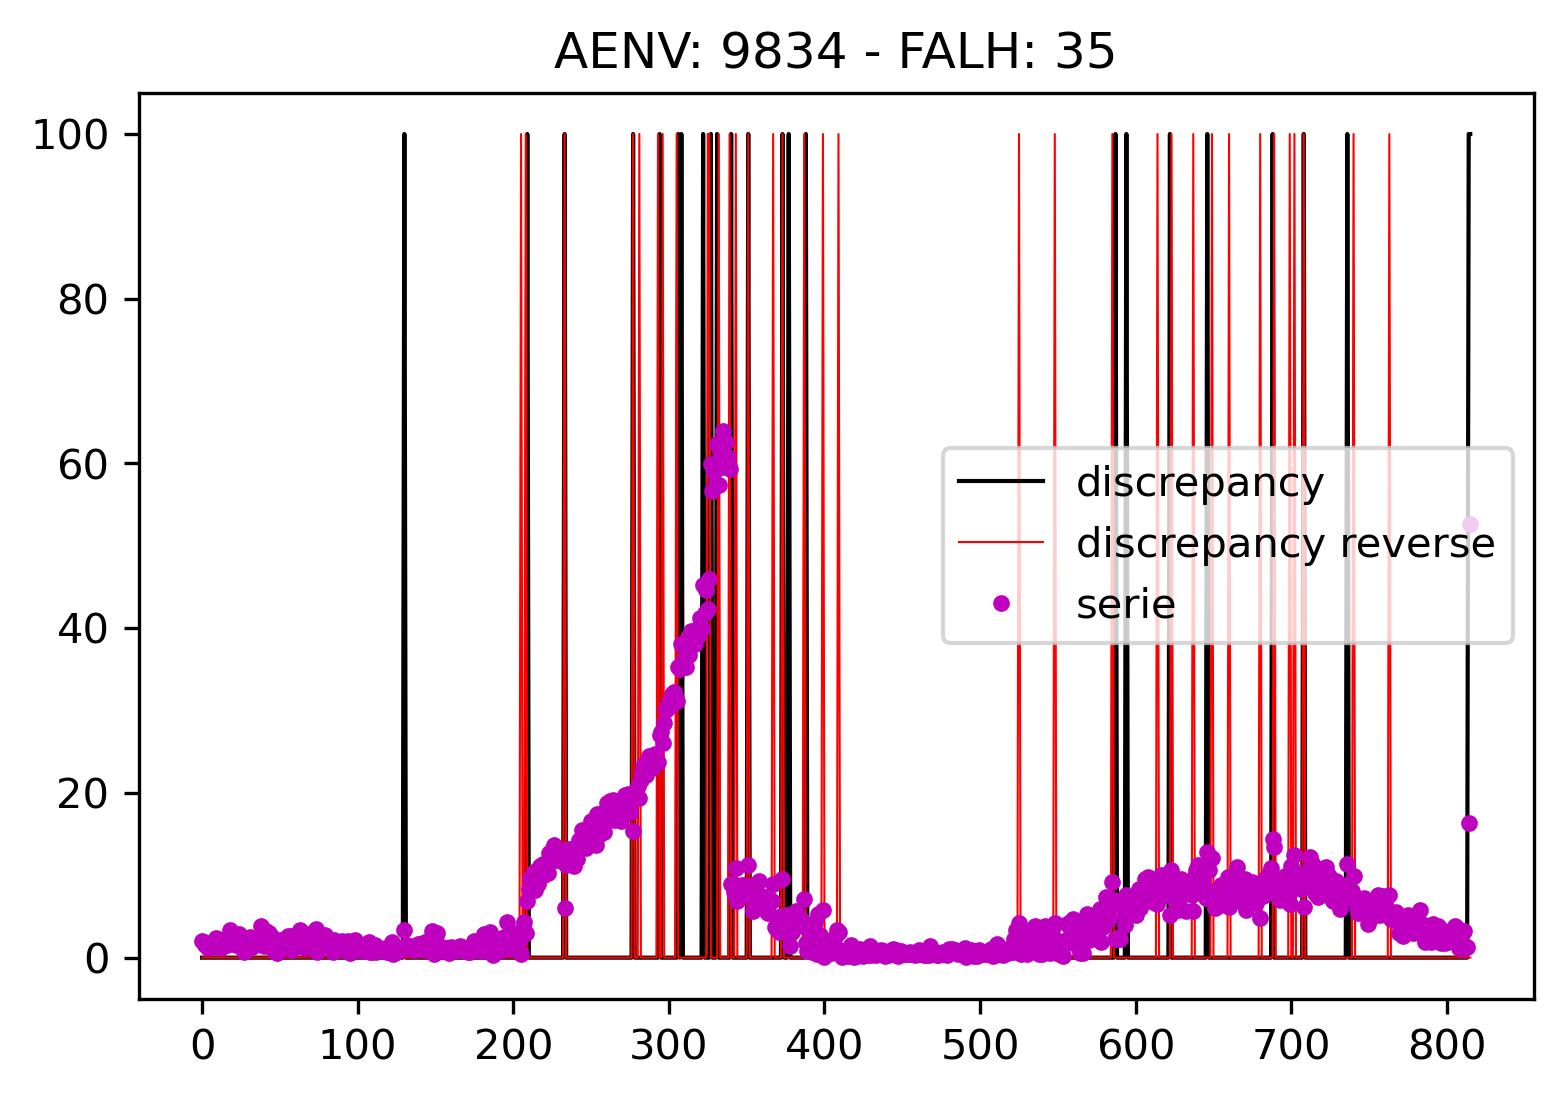

In [234]:
plot_discrepancy(data_health, fun_dis=discrepancy_4)

### Tratamento do banco de dados usando detecção de anomalias

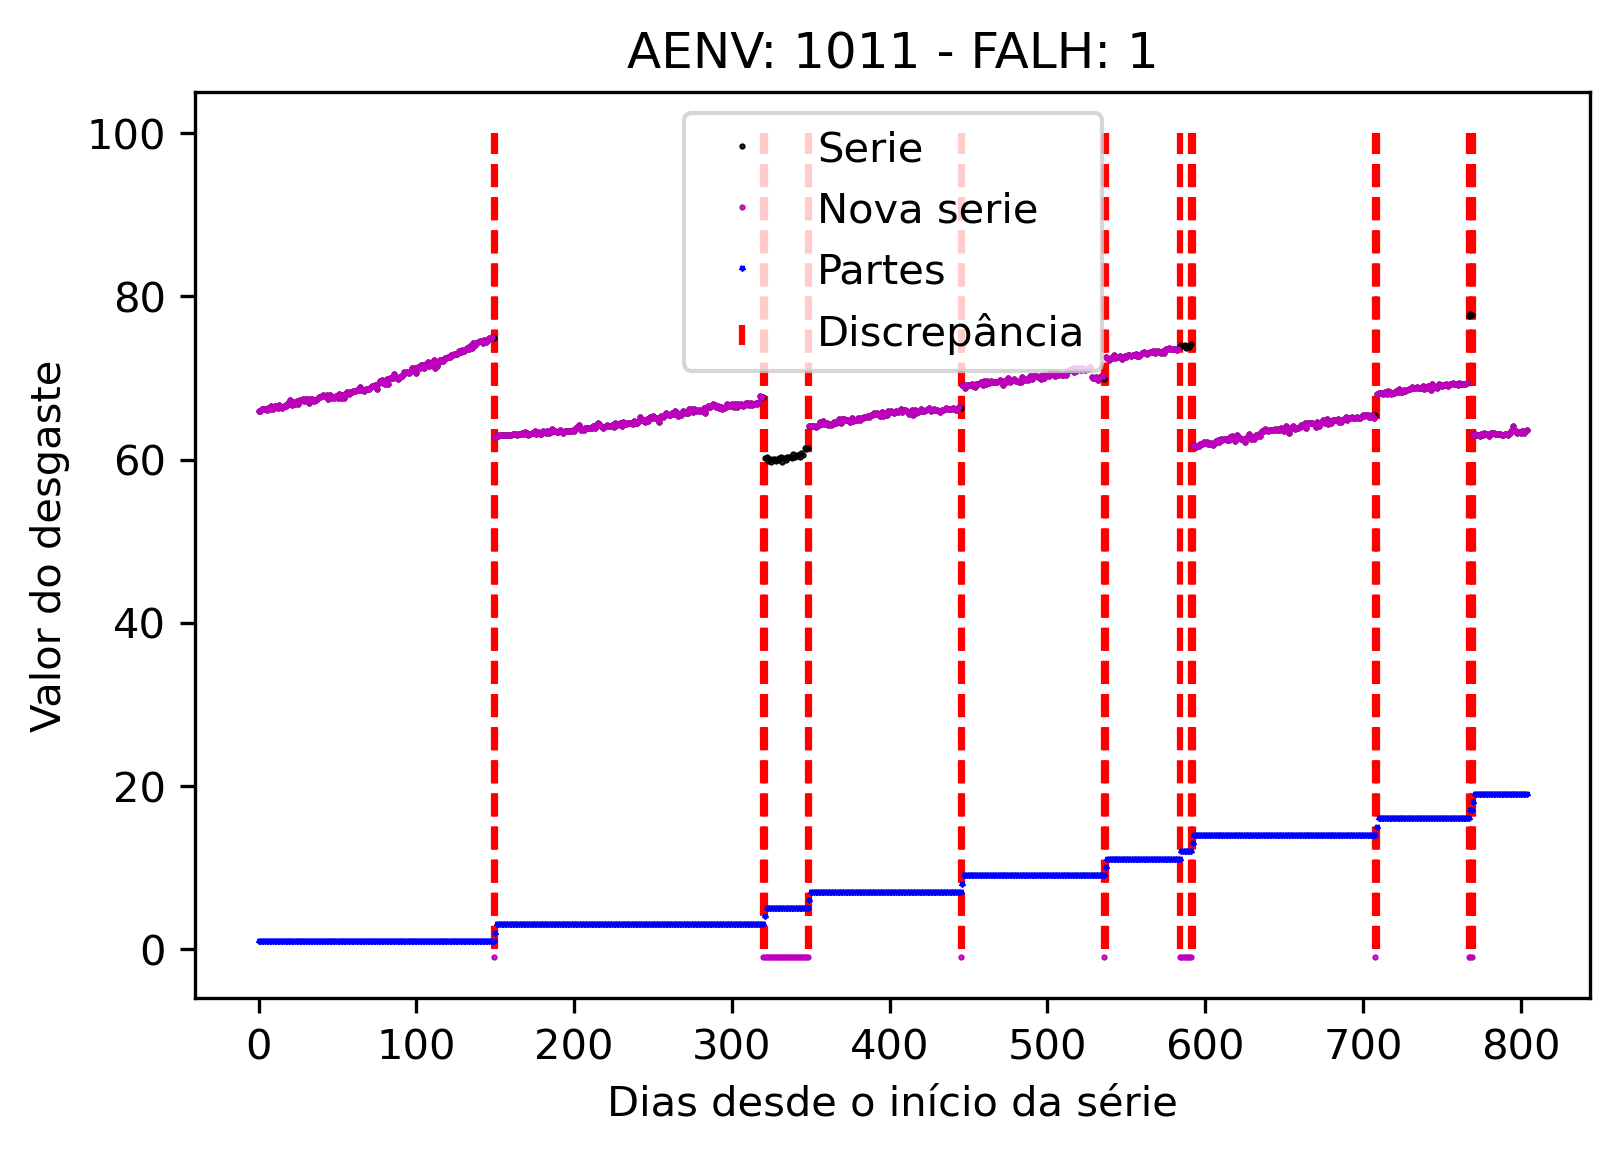

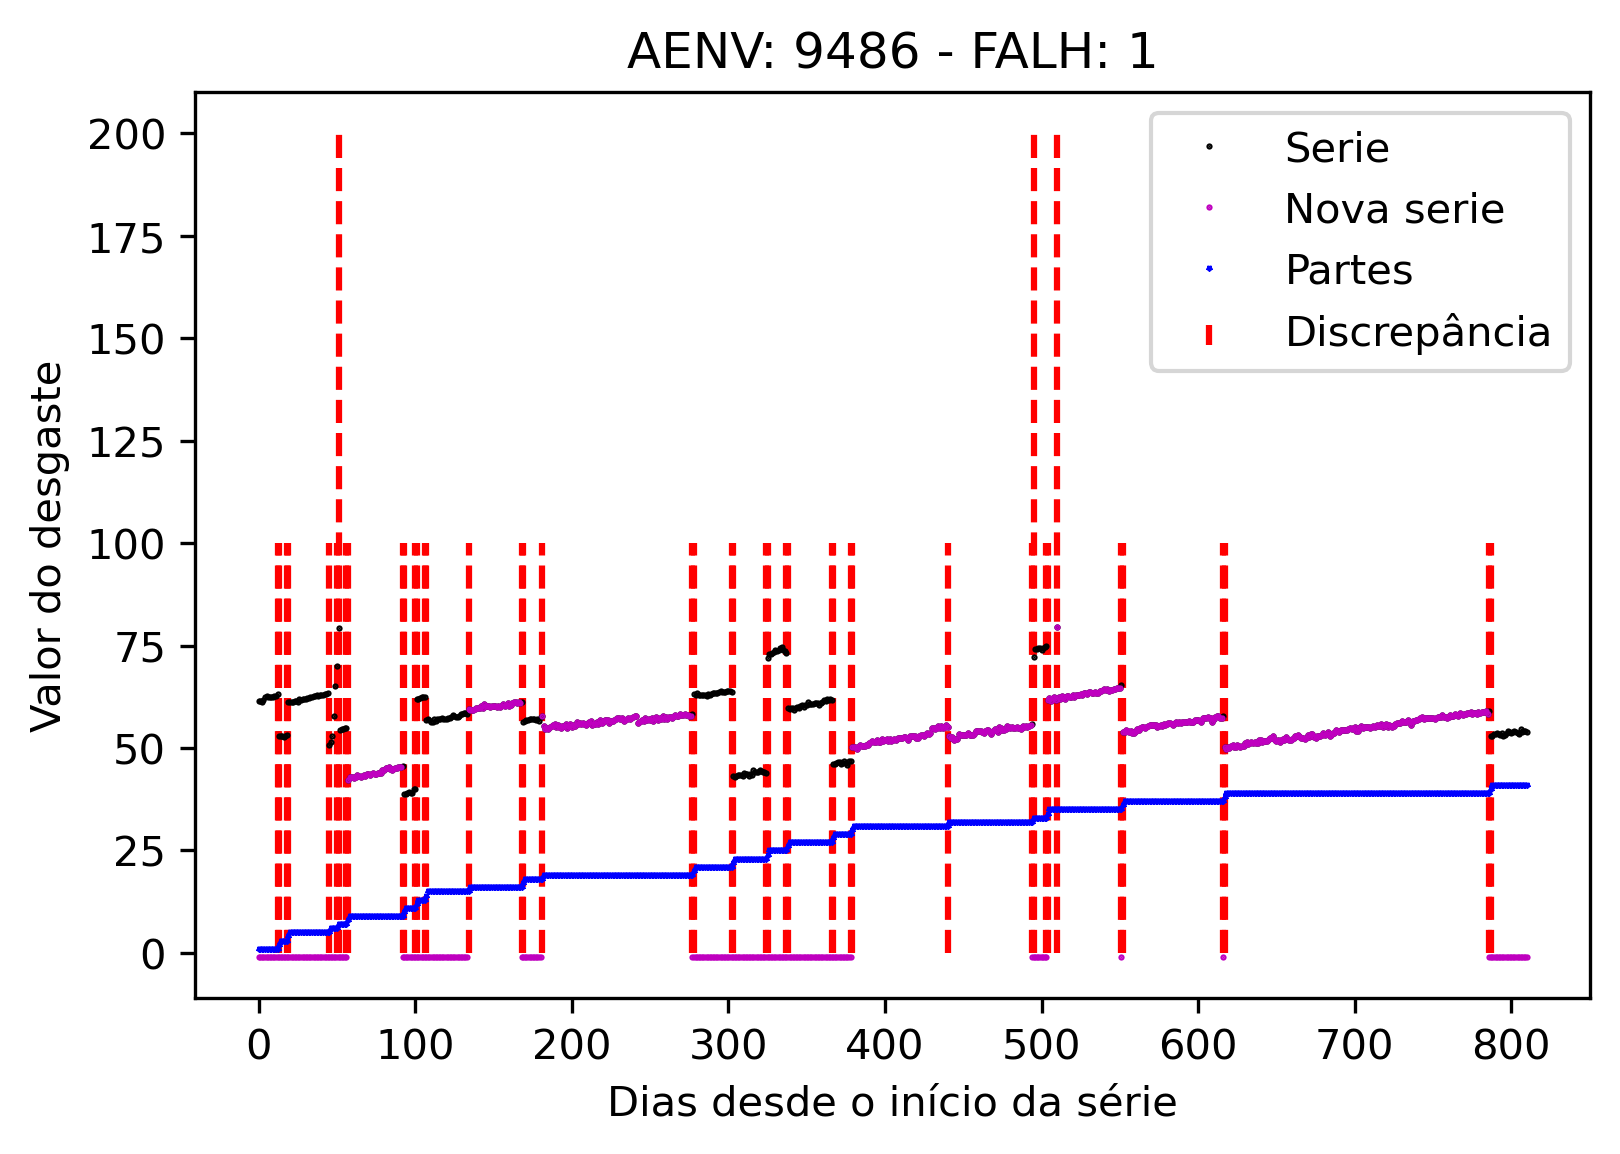

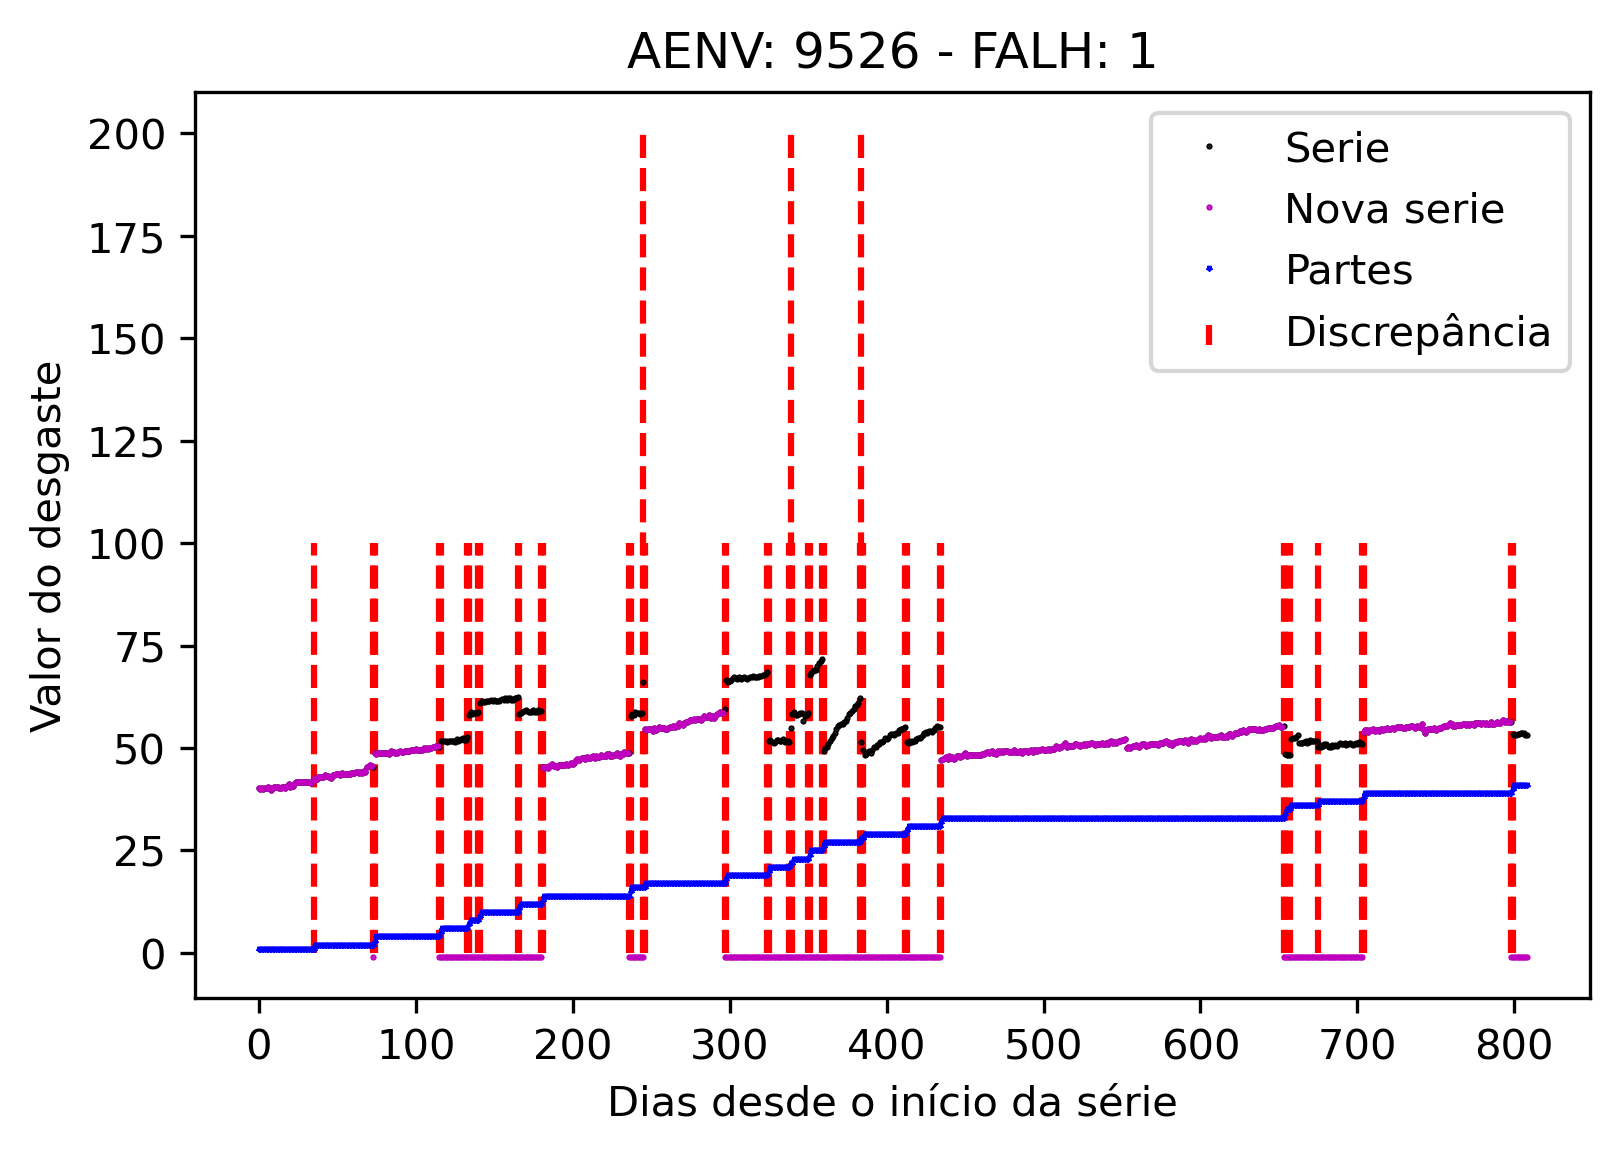

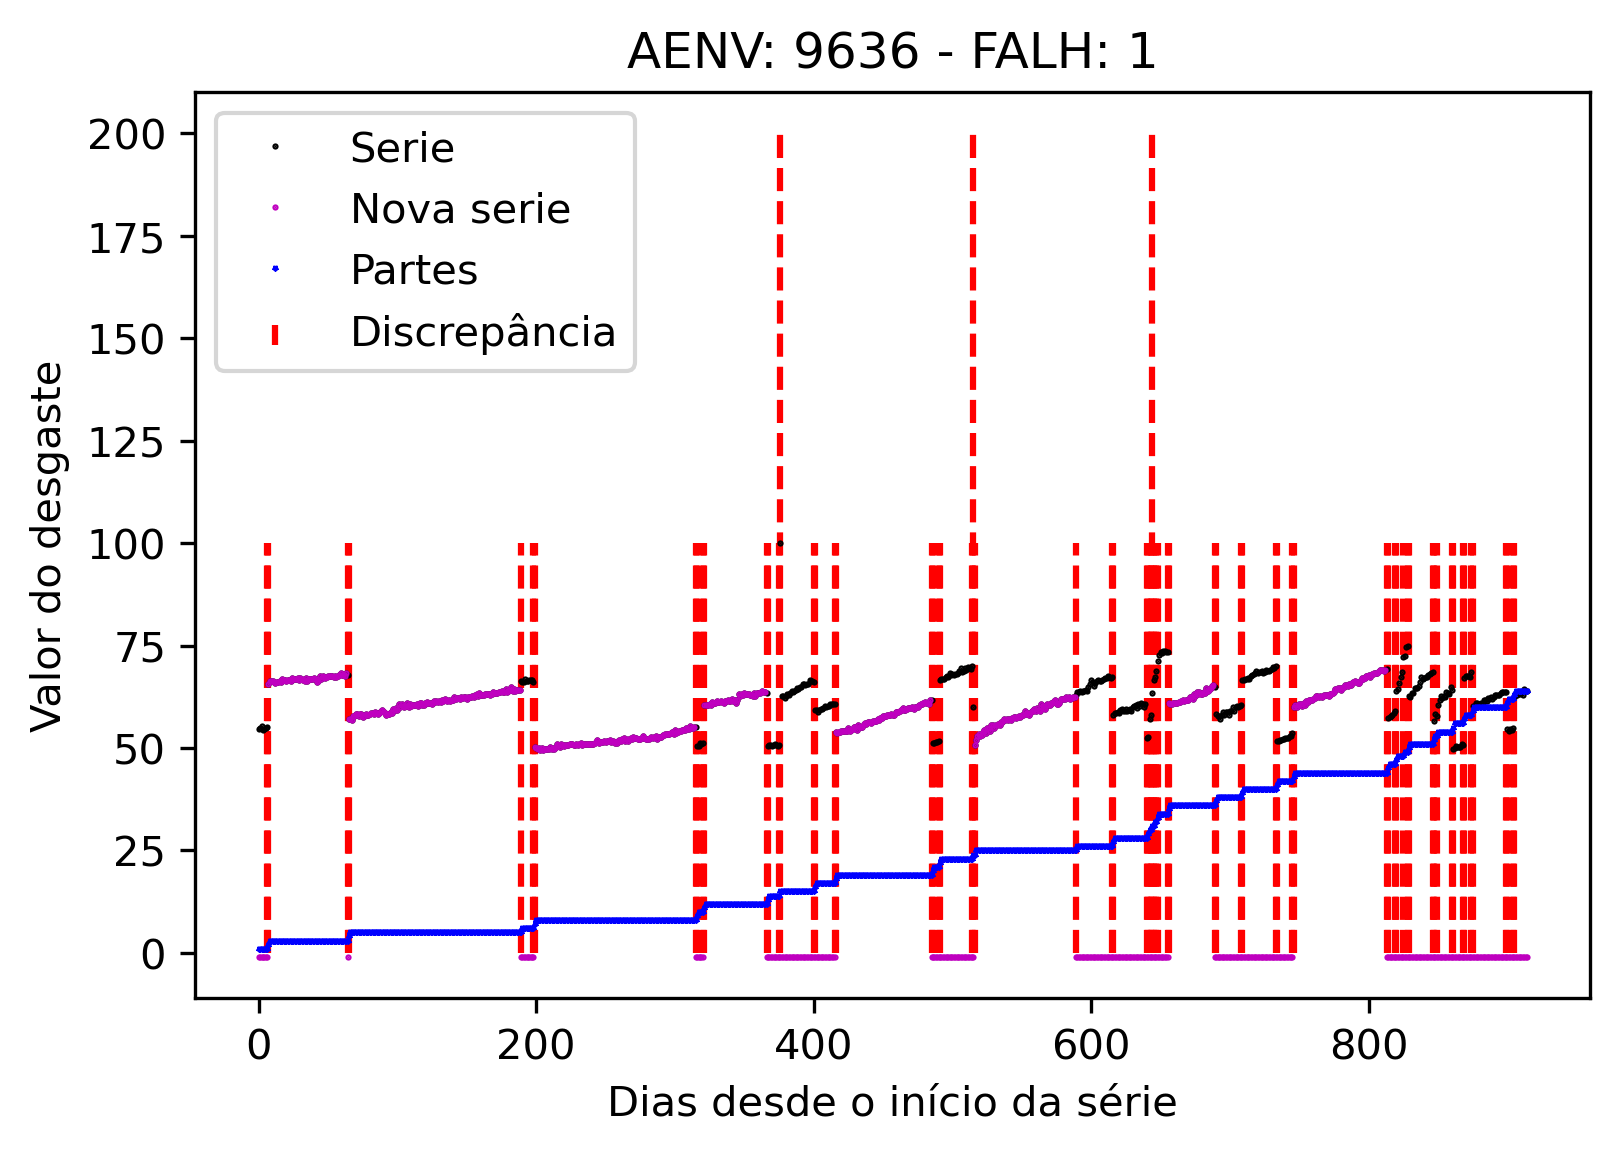

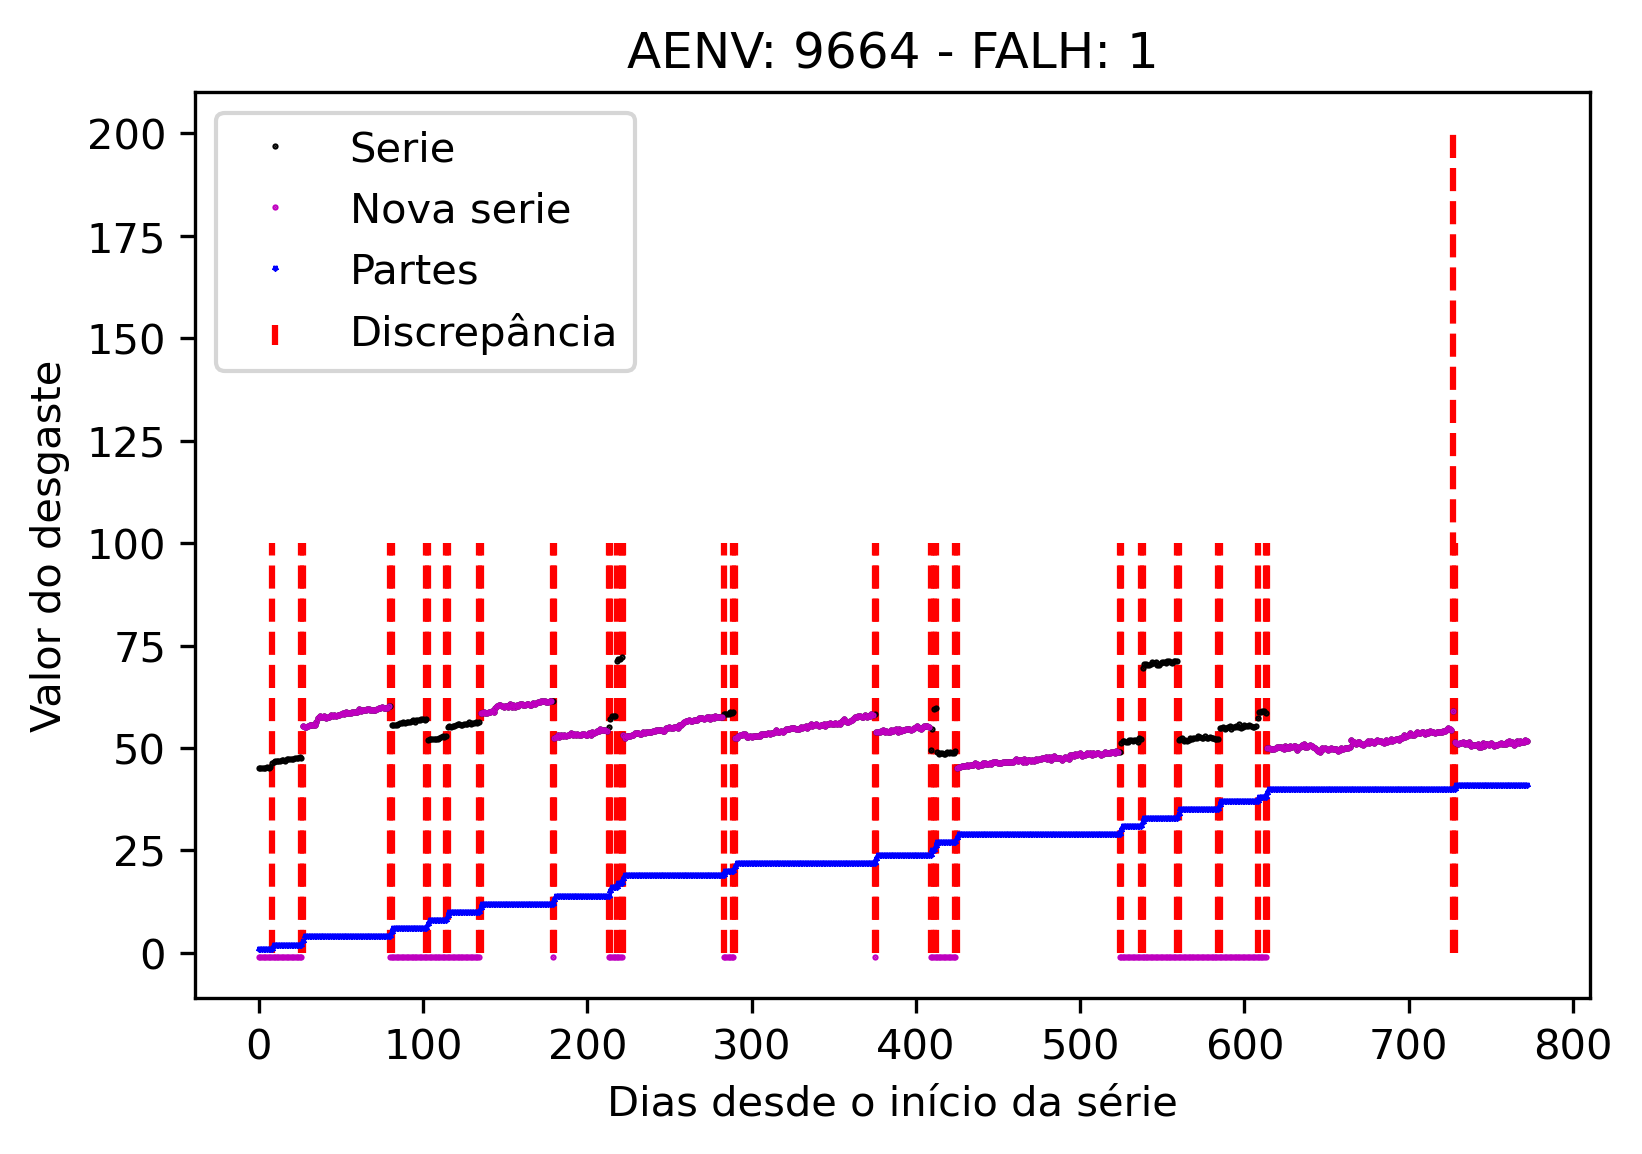

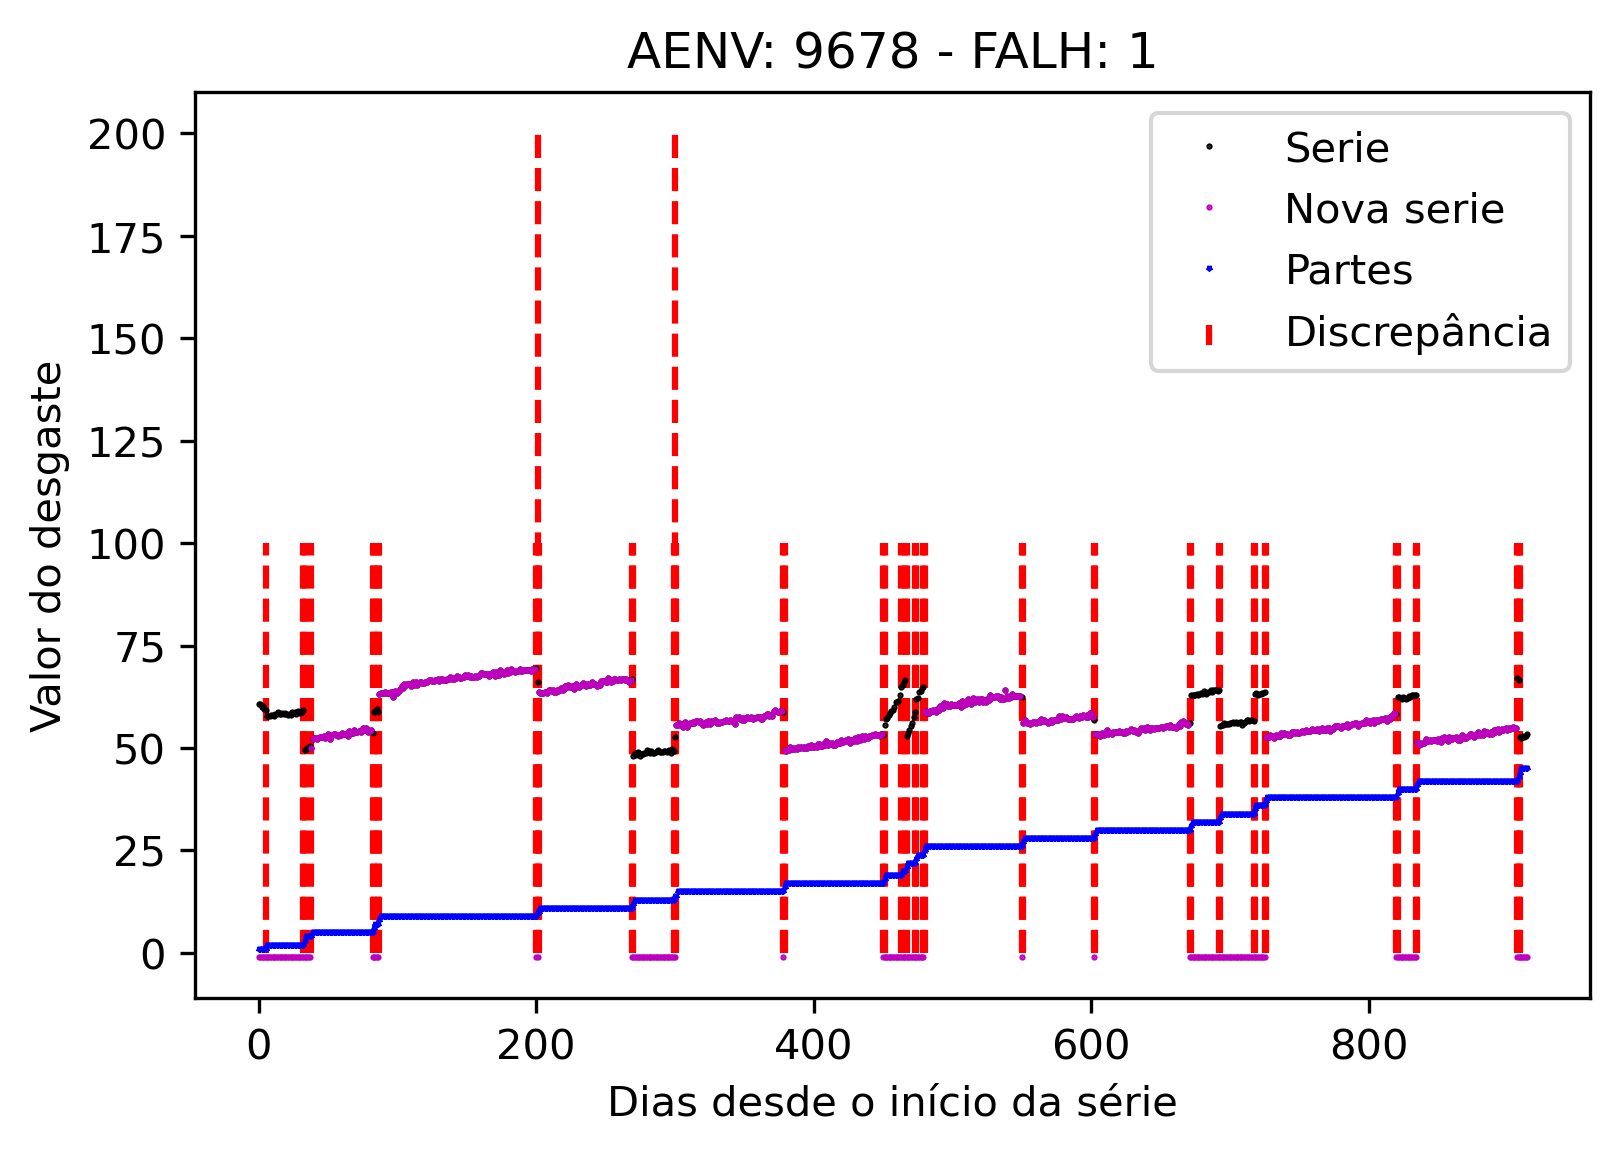

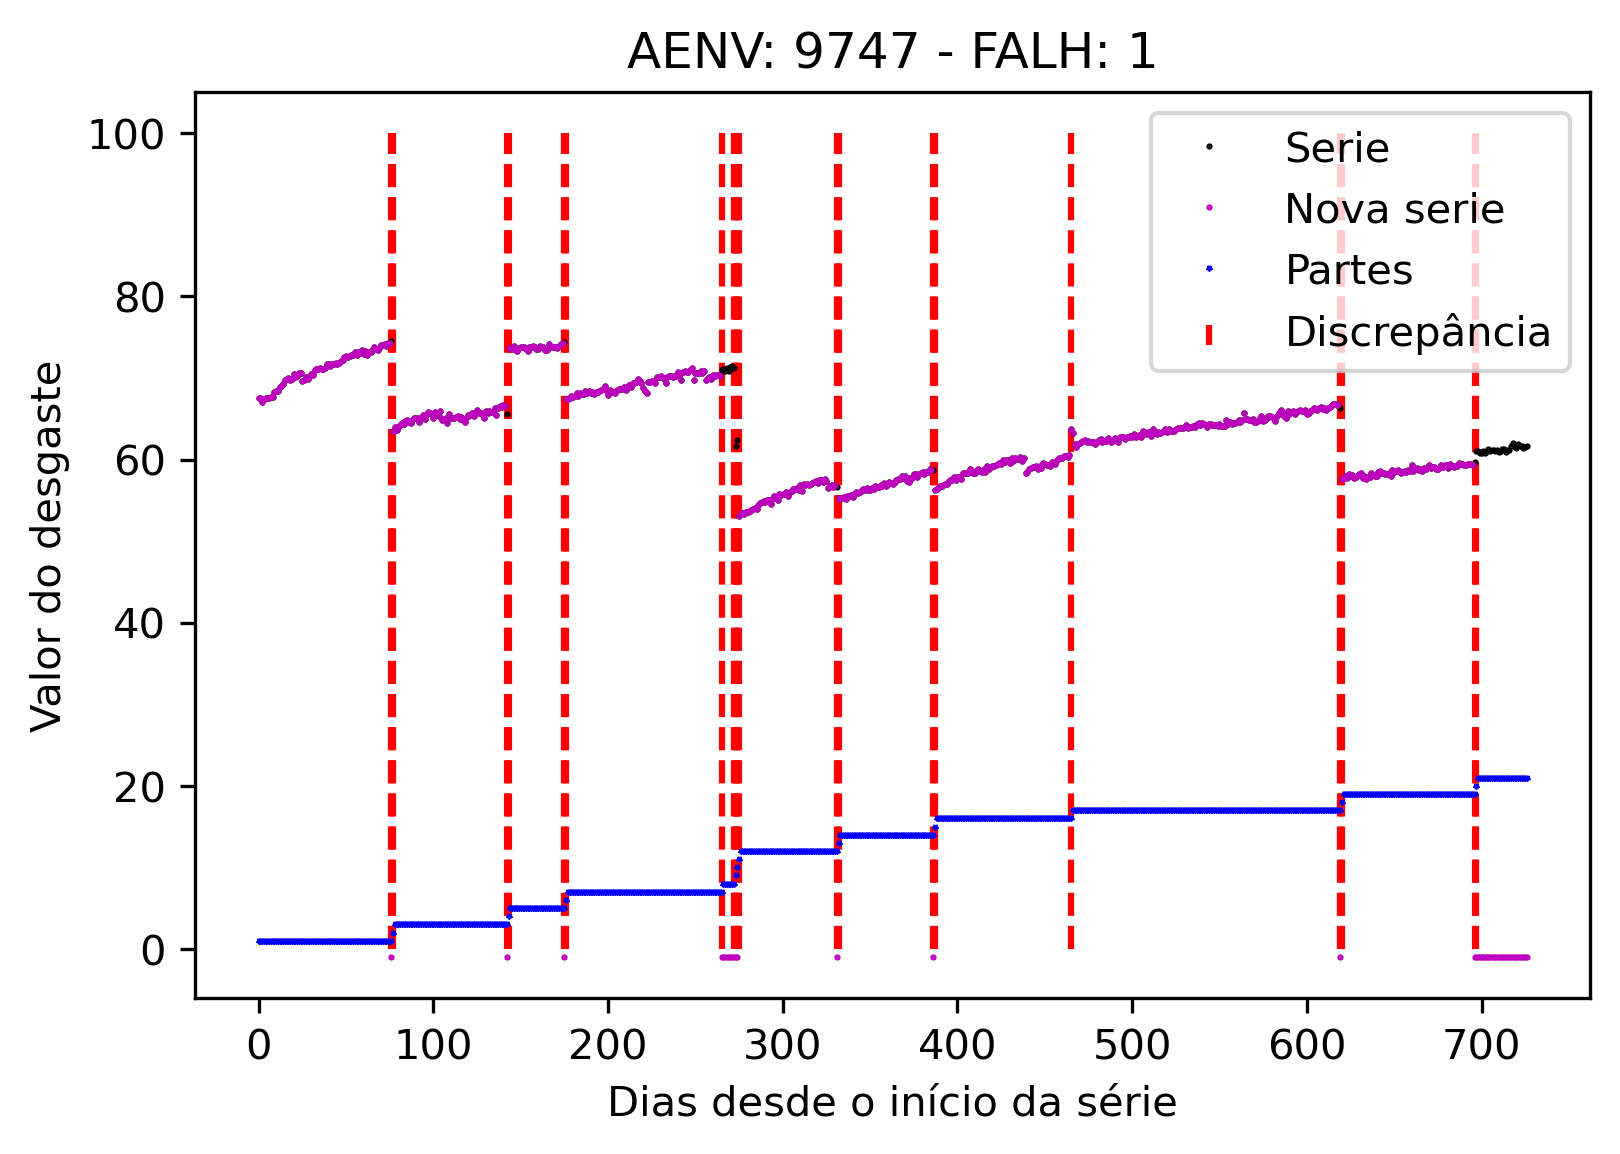

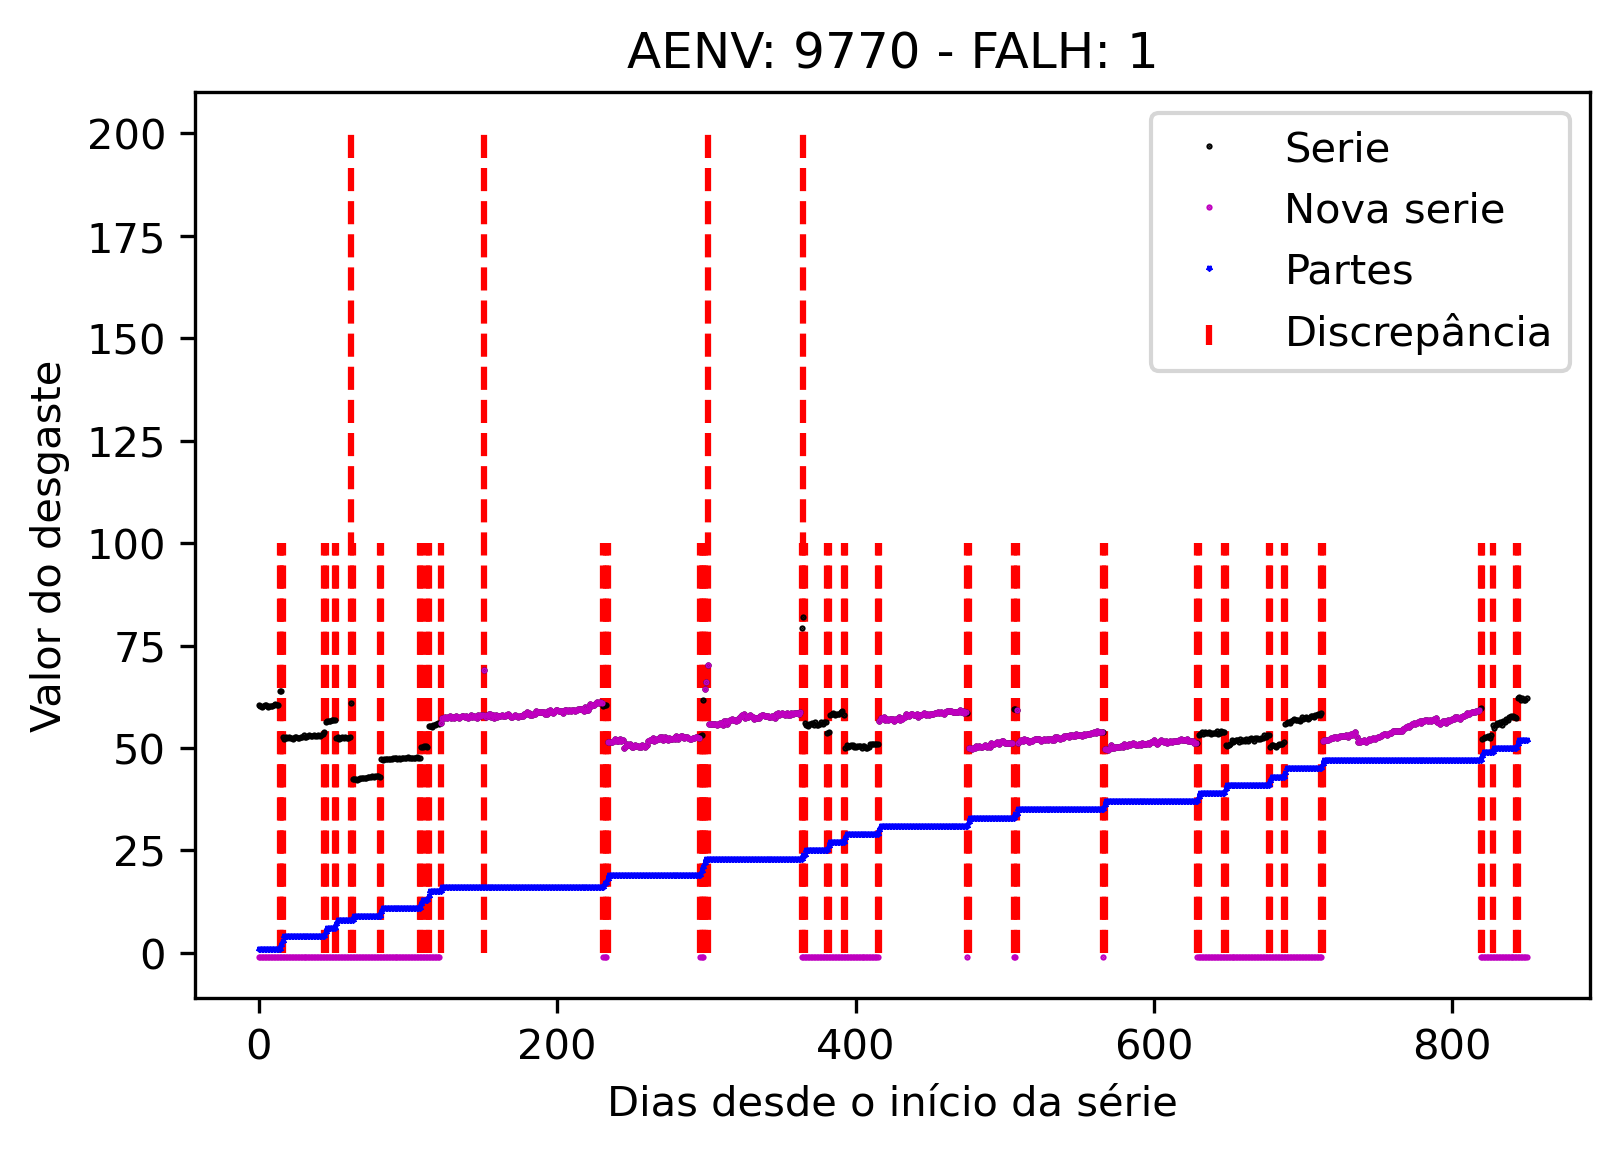

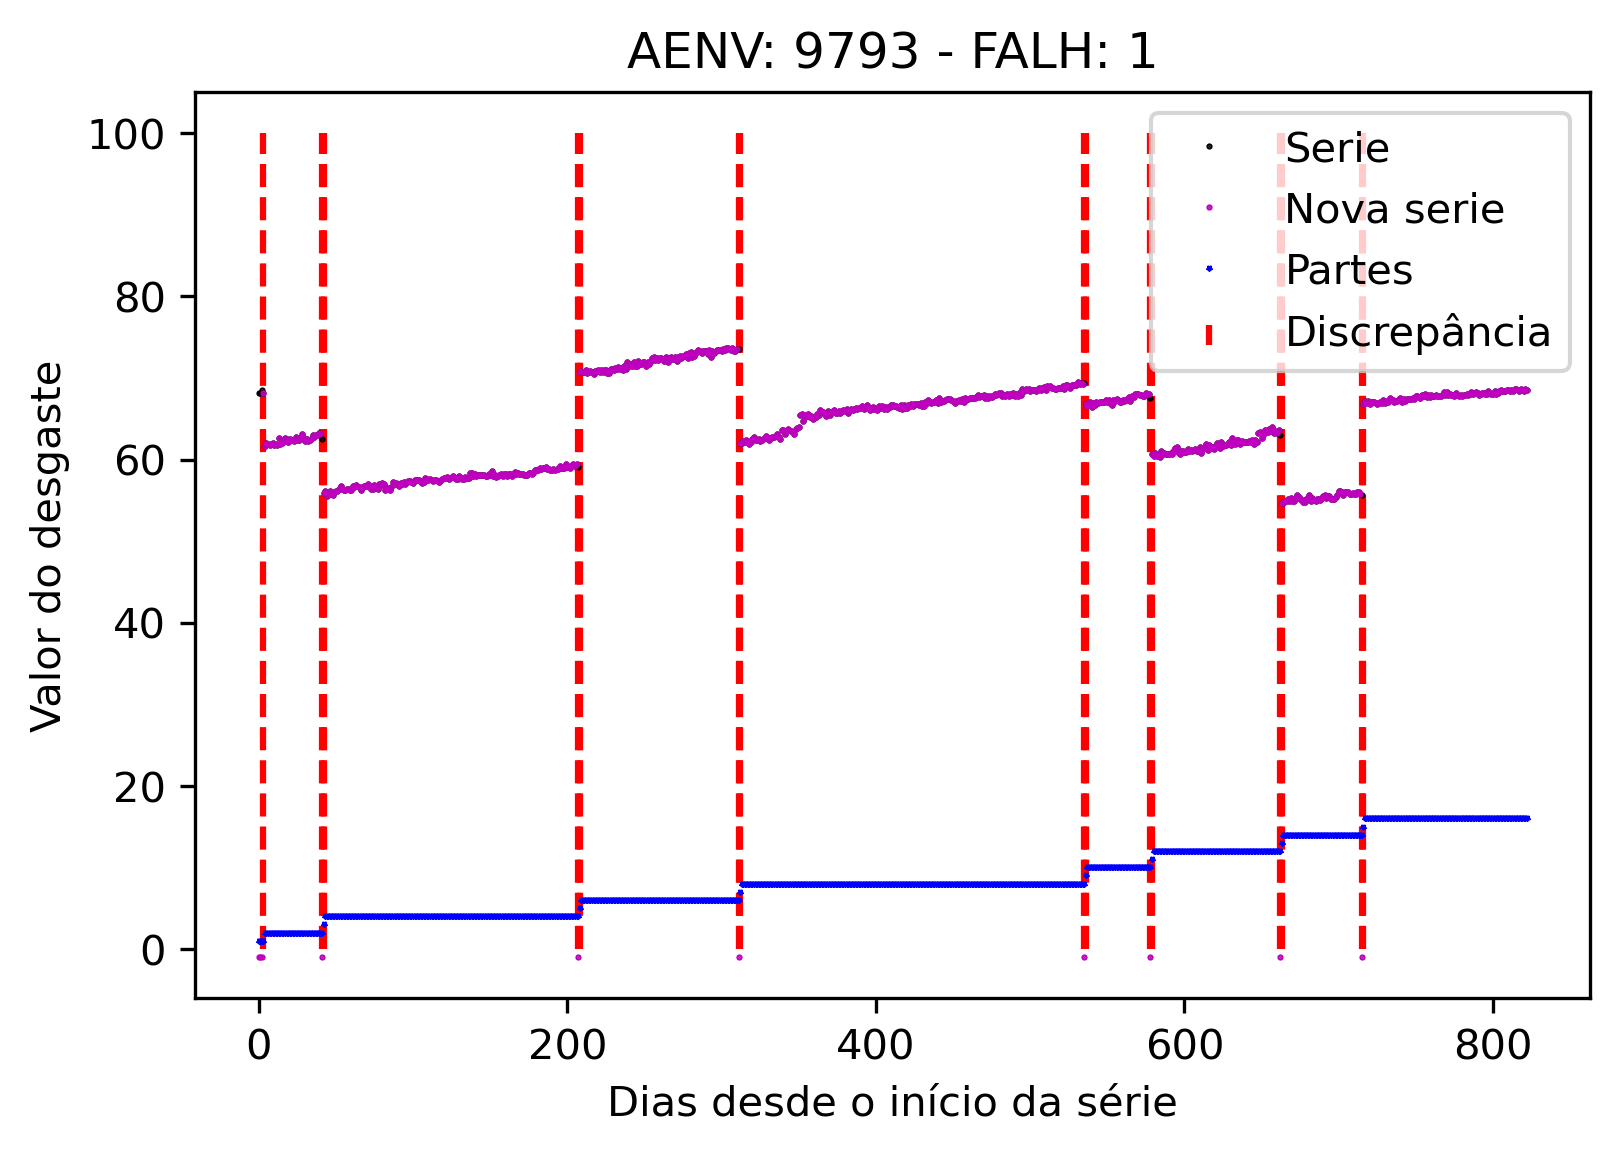

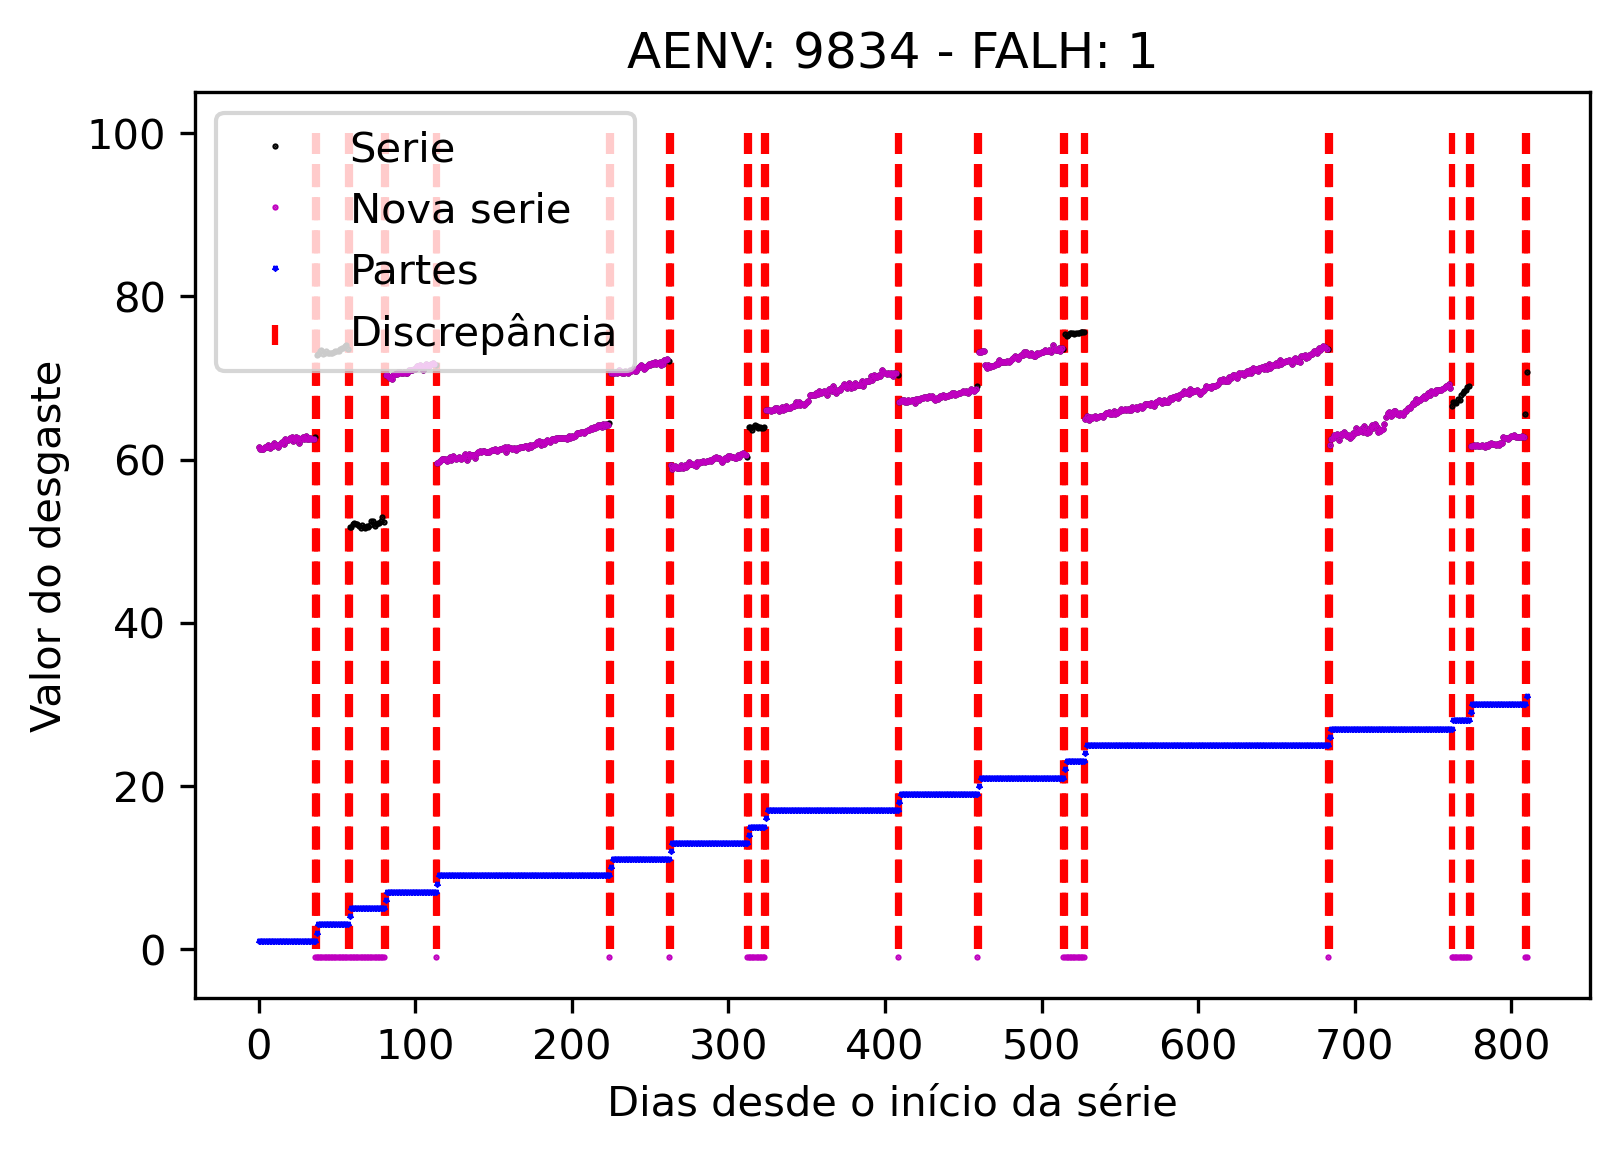

In [263]:
falh = 1
data = data_health[data_health.COD_FALH==falh]
fun_dis = discrepancy_4
disc = []
aenv= data.COD_AENV.unique()
leg = ['Serie','Nova serie','Partes','Discrepância']

data_f = pd.DataFrame()

for i in aenv:
    plt.figure(dpi=300)

    data_A=data[data['COD_AENV']==i].sort_values(by='DT_PROC')
    
    serie=data_A['VLR_DESG'].to_list()
    id = data_A['id'].to_list()
    
    plt.plot(serie,'.k',linewidth=0.5,markersize=1)
    
    disc1 = fun_dis(serie) + fun_dis(serie[::-1])[::-1]
    
    data_A['LOC_DISC'] = disc1
    
    serie,parts = loc_discrepancy(serie,disc1)
    
    data_A['VLR_DESG_new'] = serie
    data_A['SEC'] = parts
    
    data_A = data_A[data_A.VLR_DESG_new!=-1]
    
    data_A['COD'] = range(0,len(data_A['SEC'].tolist()))
    
    
    
    data_f = pd.concat([data_f,data_A])

    
    #break
    
    plt.stem(disc1, markerfmt=' ',use_line_collection=True,linefmt='r--',basefmt=' ')
    
    plt.plot(serie,'.m',linewidth=0.5,markersize=1)
    
    plt.plot(parts,'*b',linewidth=0.5,markersize=1)
    #plt.xlim([300,400])
    #plt.ylim([5,10])
    plt.xlabel('Dias desde o início da série')
    plt.ylabel('Valor do desgaste')
    plt.legend(leg)
    plt.title('AENV: '+str(i)+' - FALH: '+str(falh))

        

In [264]:
data_f.tail(10)

COD_FALH  COD_AENV     DT_PROC   VLR_DESG  COD_EVNT    id  LOC_DISC  \
8228         1      9834  2012-07-28  62.760758  431109.0  8228         0   
8229         1      9834  2012-07-29  62.848002  431118.5  8229         0   
8230         1      9834  2012-07-30  62.926847  431126.5  8230         0   
8231         1      9834  2012-07-31  62.965562  431134.5  8231         0   
8232         1      9834  2012-08-01  62.771534  431139.5  8232         0   
8233         1      9834  2012-08-02  62.809067  431144.0  8233         0   
8234         1      9834  2012-08-03  62.821404  431150.0  8234         0   
8235         1      9834  2012-08-04  62.781487  431157.5  8235         0   
8236         1      9834  2012-08-05  62.905248  431165.0  8236         0   
8237         1      9834  2012-08-06  62.765372  431172.5  8237         0   

      VLR_DESG_new  SEC  COD  
8228     62.760758   30  710  
8229     62.848002   30  711  
8230     62.926847   30  712  
8231     62.965562   30  713  
8232     62.771534   30  714  
8233     62.809067   30  715  
8234     62.821404   30  716  
8235     62.781487   30  717  
8236     62.905248   30  718  
8237     62.765372   30  719

In [267]:
px.line(data_f, x='COD', y='VLR_DESG', color='COD_AENV')

In [270]:
px.line(data_f[data_f['COD_AENV']==9486], x='COD', y='VLR_DESG', color='SEC')

# Tenatativas fracassadas

In [ ]:
def discrepancy_1(serie):
    n = 30
    discrip=[0]*(n)
    
    for i in range(len(serie)-n-1):
        dist1 = serie[i:i+n]        
        p = serie[i+n]

       
        if p>np.ptp(dist1)+np.max(dist1) or p<np.min(dist1)-np.ptp(dist1): # existe diferença entre as distribuições
            discrip.append(1)
            
        else: # não existe diferença entre as distribuições
            discrip.append(0)

    return np.array(discrip)*100


def discrepancy_2(serie):
    n = 30
    discrip=[0]*(n)
    
    for i in range(len(serie)-n-1):
        sample1 = serie[i:i+n]
        min1 = np.min(sample1)
        max1 = np.max(sample1) 
        
        sample2 = serie[i+n:i+2*n]
        min2 = np.min(sample2)
        max2 = np.max(sample2) 
        
        if min2>max1 or max2<min1: # existe diferença entre as distribuições
            discrip.append(1)
            
        else: # não existe diferença entre as distribuições
            discrip.append(0)

    return np.array(discrip)*100



def discrepancy_3(serie):
    n = 5
    discrip=[0]*(n)
    
    for i in range(len(serie)-n-1):
        sample1 = serie[i:i+n]
        min1 = np.min(sample1)
        max1 = np.max(sample1)
        
        
        sample2 = serie[i+n:i+2*n]
        min2 = np.min(sample2)
        max2 = np.max(sample2)
        
        ptp1 = 3*abs(max1-min1)
        
        if min2>max1+ptp1 or max2<min1-ptp1: # existe diferença entre as distribuições
            discrip.append(1)
            
        else: # não existe diferença entre as distribuições
            discrip.append(0)

    return np.array(discrip)*100